#### General Packages import

In [1]:
# Import general package
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import math
from numpy import concatenate
from pandas import concat

In [2]:
from sklearn.inspection import permutation_importance

In [3]:
print(pd.__version__)

2.2.2


In [4]:
from platform import python_version

print(python_version())

3.10.14


## 1. DATA
The Data that will be used in the present work consists of the following main datasets:

- a dataset containing time serie of historical news/headlines related to the tesla stock that will be used for sentiment analysis purpose and extract sentiment scores that will be used as indipendent variable for the predicitive models.
- a dataset containing time serie of historical market variables related to tesla stock, such as price and volume.
- a dataset containing time serie of historical sentiment scores (alredy computed) and market variables of Apple stock.
- a dataset containing the time serie of historical market variables related to the index Nasdaq100, whose features will be used as indipendent variables for predicting the the target variable considered (pct change of stocks volume).
- a dataset containing the time serie of Daili VIX index, whose features will be used as indipendent variables for predicting the the target variable considered (pct change of stocks volume).

In [5]:
#Importing the data
data_dir='C:/Users/loren/Desktop/IU_University_of_Applied_Science/Data_Science_Master/Thesis/Thesis_work/Volume_prediction/data/'
fig_dir='C:/Users/loren/Desktop/IU_University_of_Applied_Science/Data_Science_Master/Thesis/Thesis_work/Volume_prediction/figs/'
df_tsla_news=pd.read_excel(data_dir+'tesla_news.xlsx') #tesla news
df_tsla_hist=pd.read_csv(data_dir+'tsla_historical.csv') #historical tsla price and volume
df_appl_hist=pd.read_csv(data_dir+'aaplCombined.csv') #historical tsla price and volume
df_appl_hist['Date'] = pd.to_datetime(df_appl_hist.Date)
df_nasd_hist=pd.read_csv(data_dir+'Nasdaq100.csv') #historical tsla price and volume
df_vix_hist=pd.read_csv(data_dir+'VIX.csv') #historical tsla price and volume

#print('General news dataframe content:',df_headlines_gen.columns,)
print('TSLA news dataframe content:',df_tsla_news.columns)
print('Historical TSLA dataframe content:',df_tsla_hist.columns)
print('Historical APPL dataframe content:',df_appl_hist.columns)
print('Historical Nasdaq100 dataframe content:',df_nasd_hist.columns)
print('Historical VIX dataframe content:',df_vix_hist.columns)

TSLA news dataframe content: Index(['source', 'headlines', 'date'], dtype='object')
Historical TSLA dataframe content: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Historical APPL dataframe content: Index(['Date', 'compound', 'Low', 'Open', 'Volume', 'High', 'Close',
       'Adjusted Close'],
      dtype='object')
Historical Nasdaq100 dataframe content: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Historical VIX dataframe content: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


C:\Users\loren\AppData\Local\Temp\ipykernel_18596\470401850.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_appl_hist['Date'] = pd.to_datetime(df_appl_hist.Date)


In [6]:
print('TSLA news :', len(df_tsla_news))
print('Historical TSLA :', len(df_tsla_hist))
print('Historical APPL :',len(df_appl_hist))
print('Historical Nasdaq100 :',len(df_nasd_hist))
print('Historical VIX :', len(df_vix_hist))

TSLA news : 22274
Historical TSLA : 3530
Historical APPL : 2517
Historical Nasdaq100 : 4657
Historical VIX : 4829


### 1.1 Length of time intervals identification

The main goal of the present work is to predict the percentage change of Volume of stocks considered, which are TESLA and APPLE. It is worth to mention that time interval of the available data of TSLA and APPL differ, therefore the analysis applied to the two stocks will be on two different time periods.

In [7]:
#Identifying min and max dates
print('TSLA news data min:',df_tsla_news['date'].min(),',','TSLA news data max:',df_tsla_news['date'].max())
print('Historical TSLA data min:',df_tsla_hist['Date'].min(),',','Historical TSLA data max:',df_tsla_hist['Date'].max())
print('Historical APPL data min:',df_appl_hist['Date'].min(),',','Historical APPL data max:',df_appl_hist['Date'].max())
print('Historical Nasdaq100 data min:',df_nasd_hist['Date'].min(),',','Historical Nasdaq100 data max:',df_nasd_hist['Date'].max())
print('Historical VIX data min:',df_vix_hist['Date'].min(),',','Historical VIX data max:',df_vix_hist['Date'].max())

TSLA news data min: 2008-07-08 00:00:00 , TSLA news data max: 2023-04-10 00:00:00
Historical TSLA data min: 2010-07-01 , Historical TSLA data max: 2024-07-11
Historical APPL data min: 2006-12-01 00:00:00 , Historical APPL data max: 2016-11-30 00:00:00
Historical Nasdaq100 data min: 2006-01-03 , Historical Nasdaq100 data max: 2024-07-05
Historical VIX data min: 2006-01-03 , Historical VIX data max: 2024-07-05


The main discriminant in definying the length of the time period considered for the two stocks is the sentyment data available for APPL and the historical market data for TSLA, respectively. In order to have a consistent data time interval across the different datasets belonging to the two stocks, the longer time series are processed in order to meet the length of the shortest dataset available.

In [8]:
#TSLA TIME SERIES ADJUSTMENT
df_tsla_news1=df_tsla_news[(df_tsla_news['date']>='2010-07-01 00:00:00')].reset_index().drop(columns=['index'])
df_tsla_hist1=df_tsla_hist[(df_tsla_hist['Date']<='2023-04-10 00:00:00')].reset_index().drop(columns=['index'])
df_nasd_hist_tsla=df_nasd_hist[(df_nasd_hist['Date']>='2010-07-01 00:00:00')&(df_nasd_hist['Date']<='2023-04-10 00:00:00')].reset_index().drop(columns=['index'])
df_nasd_vix_tsla=df_vix_hist[(df_vix_hist['Date']>='2010-07-01 00:00:00')&(df_vix_hist['Date']<='2023-04-10 00:00:00')].reset_index().drop(columns=['index'])
#APPL TIME SERIES ADJUSTMENT
df_nasd_hist_appl=df_nasd_hist[(df_nasd_hist['Date']>='2006-12-01 00:00:00')&(df_nasd_hist['Date']<='2016-11-30 00:00:00')].reset_index().drop(columns=['index'])
df_nasd_vix_appl=df_vix_hist[(df_vix_hist['Date']>='2006-12-01 00:00:00')&(df_vix_hist['Date']<='2016-11-30 00:00:00')].reset_index().drop(columns=['index'])

In [9]:
print('TSLA news data min:',df_tsla_news1['date'].min(),',','TSLA news data max:',df_tsla_news1['date'].max(),',','Dataset lenght:',len(df_tsla_news1))
print('Historical TSLA data min:',df_tsla_hist1['Date'].min(),',','Historical TSLA data max:',df_tsla_hist1['Date'].max(),',','Dataset lenght:',len(df_tsla_hist1))
print('Historical Nasdaq100-tsla data min:',df_nasd_hist_tsla['Date'].min(),',','Historical Nasdaq100-tsla data max:',df_nasd_hist_tsla['Date'].max(),',','Dataset lenght:',len(df_nasd_hist_tsla))
print('Historical VIX-tsla data min:',df_nasd_vix_tsla['Date'].min(),',','Historical VIX-tsla data max:',df_nasd_vix_tsla['Date'].max(),',','Dataset lenght:',len(df_nasd_vix_tsla))


print('Historical APPL data min:',df_appl_hist['Date'].min(),',','Historical APPL data max:',df_appl_hist['Date'].max(),',','Dataset lenght:',len(df_appl_hist))
print('Historical Nasdaq100-appl data min:',df_nasd_hist_appl['Date'].min(),',','Historical Nasdaq100-appl data max:',df_nasd_hist_appl['Date'].max(),',','Dataset lenght:',len(df_nasd_hist_appl))
print('Historical VIX-appl data min:',df_nasd_vix_appl['Date'].min(),',','Historical VIX-appl data max:',df_nasd_vix_appl['Date'].max(),',','Dataset lenght:',len(df_nasd_vix_appl))

TSLA news data min: 2010-07-02 00:00:00 , TSLA news data max: 2023-04-10 00:00:00 , Dataset lenght: 22261
Historical TSLA data min: 2010-07-01 , Historical TSLA data max: 2023-04-10 , Dataset lenght: 3215
Historical Nasdaq100-tsla data min: 2010-07-02 , Historical Nasdaq100-tsla data max: 2023-04-10 , Dataset lenght: 3214
Historical VIX-tsla data min: 2010-07-02 , Historical VIX-tsla data max: 2023-04-10 , Dataset lenght: 3332
Historical APPL data min: 2006-12-01 00:00:00 , Historical APPL data max: 2016-11-30 00:00:00 , Dataset lenght: 2517
Historical Nasdaq100-appl data min: 2006-12-04 , Historical Nasdaq100-appl data max: 2016-11-30 , Dataset lenght: 2516
Historical VIX-appl data min: 2006-12-04 , Historical VIX-appl data max: 2016-11-30 , Dataset lenght: 2608


## 2. SENTIMENT ANALYSIS
Sentiment analysis is the practice of using algorithms to classify various samples of related text into overall positive and negative categories. The tool used to perform the sentiment analysis is the python packageNatural Language Toolkit (NLTK), whcih allows to process and analyzing text.  

Below the NLTK tool applied to TSLA dataset in order to obtain a daily sentiment score for each of the day beloging to the time interval considered. Please, bear in mind that the sentiment scores for the APPL stock was already computed and available among the features contained in the dataset retrieved.

In [10]:
#Import nltk packages
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
vader_tsla = SentimentIntensityAnalyzer()
scores_tsla= df_tsla_news1['headlines'].apply(vader_tsla.polarity_scores)
scores_tsla_df = pd.DataFrame.from_records(scores_tsla)

Below is displayed the head of hedalines/news dataset enriched with sentiment scores obtained out of NLTK process.

In [12]:
df_tsla_news2=pd.merge(df_tsla_news1, scores_tsla_df, left_index=True, right_index=True)
df_tsla_news2.head()

source                                          headlines       date    neg  \
0  tweet  Tesla shareholders can expect a key-person ris... 2023-03-22  0.117   
1  tweet  Here are Wednesday's biggest analyst calls: Me... 2023-03-22  0.000   
2  tweet  Tesla could be about to report one of its best... 2023-03-22  0.051   
3  tweet  Tesla is poised to report one of its best quar... 2023-03-21  0.000   
4  tweet  Tesla is expected to report one of its best qu... 2023-03-21  0.000   

     neu    pos  compound  
0  0.778  0.106   -0.0516  
1  1.000  0.000    0.0000  
2  0.847  0.102    0.4767  
3  0.838  0.162    0.7351  
4  0.833  0.167    0.7783

The next step is to compute the daily mean of the sentiment score.

In [13]:
mean_c_tsla = pd.DataFrame(df_tsla_news2.groupby(['date'])['compound'].mean()).reset_index()

Below the plot of the daily sentiment scores over the time for TSLA and APPL (red negative score, blu positive score). It is noticible that for TSLA, during the first period (2010-2015), the amount of news was very low and it makes difficult to compute appropriate sentiment scores.

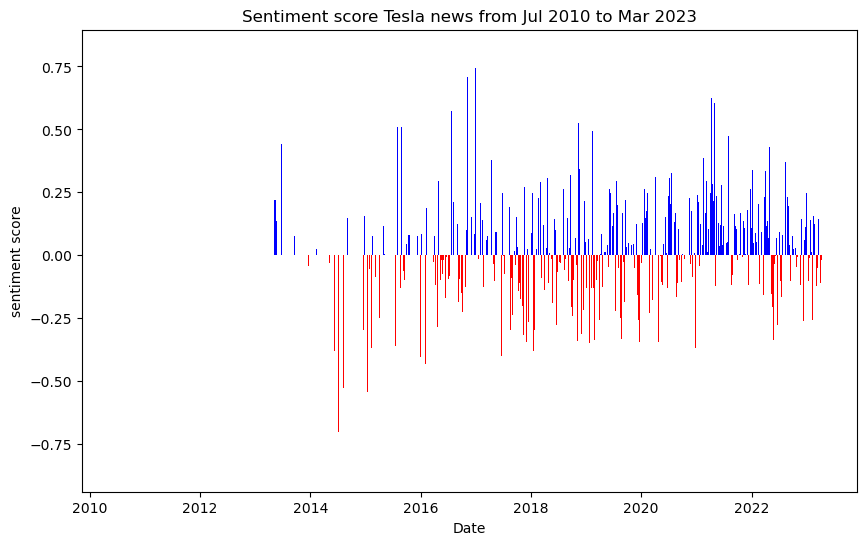

In [16]:
plt.figure(figsize=(10,6))
plt.bar(mean_c_tsla['date'],mean_c_tsla['compound'],color=np.where(mean_c_tsla['compound']>0, 'b', 'r'))
plt.ylabel('sentiment score')
plt.xlabel('Date')
plt.title('Sentiment score Tesla news from Jul 2010 to Mar 2023')
#plt.legend()
plt.show()

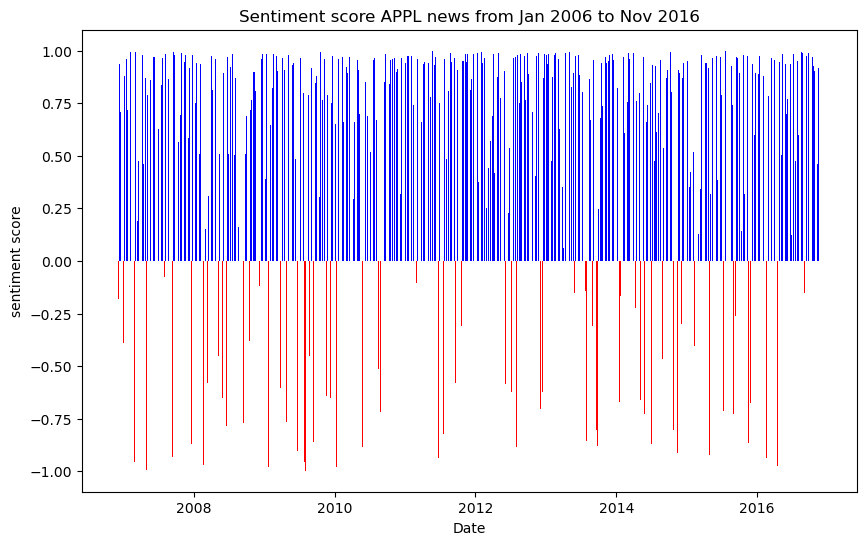

In [17]:
plt.figure(figsize=(10,6))
plt.bar(df_appl_hist['Date'],df_appl_hist['compound'],color=np.where(df_appl_hist['compound']>0, 'b', 'r'))
plt.ylabel('sentiment score')
plt.xlabel('Date')
plt.title('Sentiment score APPL news from Jan 2006 to Nov 2016')
#plt.legend()
plt.show()

## 3. CREATING THE FINAL DATAFRAMES

The next steps is to gather all the infromation and collected and produce the dataframes for both of the stocks that will be used for the future analysis.

### 3.1 TSLA DATAFRAME
The results coming form sentiment analysis are merged with the historical TSLA market data. In addtion, the data related to Index Nasdaq and VIX index will be merged as well.

In [18]:
mean_c_tsla.rename(columns = {'compound':'sent_score_tsla'}, inplace = True)
df_tsla_hist1.rename(columns = {'Date':'date'}, inplace = True)

In [19]:
df_tsla_hist1['date']=df_tsla_hist1.date.astype('datetime64[ns]')
df_nasd_hist_tsla.rename(columns = {'Date':'date'}, inplace = True)
df_nasd_hist_tsla['date']=df_nasd_hist_tsla.date.astype('datetime64[ns]')
df_nasd_vix_tsla.rename(columns = {'Date':'date'}, inplace = True)
df_nasd_vix_tsla['date']=df_nasd_vix_tsla.date.astype('datetime64[ns]')

In [20]:
df_tsla_hist_merged=df_tsla_hist1.merge(mean_c_tsla, on = 'date', how = 'left').reset_index().drop(columns=['index'])
df_tsla_hist_merged['sent_score_tsla'] = df_tsla_hist_merged['sent_score_tsla'].fillna(0)

In [21]:
df_tsla_hist_merged.rename(columns = {'Adj Close':'Adj Close_tsla','Volume':'Volume_tsla'}, inplace = True)
df_tsla_hist_merged1=df_tsla_hist_merged.merge(df_nasd_hist_tsla[['date','Adj Close','Volume']], on = 'date', how = 'left').reset_index().drop(columns=['index'])
df_tsla_hist_merged1.rename(columns = {'Adj Close':'Adj Close_nasdaq','Volume':'Volume_nasdaq'}, inplace = True)
df_tsla_hist_merged2=df_tsla_hist_merged1.merge(df_nasd_vix_tsla[['date','Adj Close']], on = 'date', how = 'left').reset_index().drop(columns=['index'])
df_tsla_hist_merged2.rename(columns = {'Adj Close':'Vix_index'}, inplace = True)

In [22]:
df_tsla_hist_merged2

date        Open        High         Low       Close  \
0    2010-07-01    1.666667    1.728000    1.351333    1.464000   
1    2010-07-02    1.533333    1.540000    1.247333    1.280000   
2    2010-07-06    1.333333    1.333333    1.055333    1.074000   
3    2010-07-07    1.093333    1.108667    0.998667    1.053333   
4    2010-07-08    1.076000    1.168000    1.038000    1.164000   
...         ...         ...         ...         ...         ...   
3210 2023-04-03  199.910004  202.690002  192.199997  194.770004   
3211 2023-04-04  197.320007  198.740005  190.320007  192.580002   
3212 2023-04-05  190.520004  190.679993  183.759995  185.520004   
3213 2023-04-06  183.080002  186.389999  179.740005  185.059998   
3214 2023-04-10  179.940002  185.100006  176.110001  184.509995   

      Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
0           1.464000    123282000         0.000000               NaN   
1           1.280000     77097000         0.000000       1728.339966   
2           1.074000    103003500         0.296000       1734.680054   
3           1.053333    103825500         0.000000       1789.719971   
4           1.164000    115671000         0.000000       1798.310059   
...              ...          ...              ...               ...   
3210      194.770004    169545900        -0.108126      13148.349609   
3211      192.580002    126463800        -0.271712      13100.080078   
3212      185.520004    133882500         0.010680      12967.200195   
3213      185.059998    123857900         0.194654      13062.599609   
3214      184.509995    142154600        -0.246950      13051.230469   

      Volume_nasdaq  Vix_index  
0               NaN        NaN  
1      1.672320e+09  30.120001  
2      2.173030e+09  29.650000  
3      2.199500e+09  26.840000  
4      2.034030e+09  25.709999  
...             ...        ...  
3210   4.816440e+09  18.549999  
3211   4.298760e+09  19.000000  
3212   4.378590e+09  19.080000  
3213   3.862800e+09  18.400000  
3214   4.334070e+09  18.969999  

[3215 rows x 11 columns]

### 3.2 APPL DATAFRAME
The same steps performed for TSLA in order to create the main datframe will be executed for APPL stock. 

In [24]:
df_appl_hist.rename(columns = {'Date':'date','Adjusted Close':'Adj Close_appl','Volume':'Volume_appl','compound':'sent_score_appl'}, inplace = True)
df_nasd_hist_appl.rename(columns = {'Date':'date'}, inplace = True)
df_nasd_hist_appl['date']=df_nasd_hist_appl.date.astype('datetime64[ns]')
df_appl_hist_merged1=df_appl_hist.merge(df_nasd_hist_appl[['date','Adj Close','Volume']], on = 'date', how = 'left').reset_index().drop(columns=['index'])
df_appl_hist_merged1.rename(columns = {'Adj Close':'Adj Close_nasdaq','Volume':'Volume_nasdaq'}, inplace = True)
df_nasd_vix_appl.rename(columns = {'Date':'date'}, inplace = True)
df_nasd_vix_appl['date']=df_nasd_vix_appl.date.astype('datetime64[ns]')
df_appl_hist_merged2=df_appl_hist_merged1.merge(df_nasd_vix_appl[['date','Adj Close']], on = 'date', how = 'left').reset_index().drop(columns=['index'])
df_appl_hist_merged2.rename(columns = {'Adj Close':'Vix_index'}, inplace = True)

df_appl_hist_merged2

date  sent_score_appl        Low       Open  Volume_appl  \
0    2006-12-01           0.7707   3.217857   3.278571    795079600   
1    2006-12-04           0.8720   3.232143   3.281429    709536800   
2    2006-12-05           0.0000   3.245357   3.273214    662838400   
3    2006-12-06           0.6858   3.202500   3.237143    638184400   
4    2006-12-07          -0.6712   3.103571   3.215357   1004827600   
...         ...              ...        ...        ...          ...   
2512 2016-11-23           0.0000  27.582500  27.840000    109705600   
2513 2016-11-25          -0.8990  27.737499  27.782499     45903600   
2514 2016-11-28           0.0000  27.847500  27.857500    108776000   
2515 2016-11-29           0.0000  27.517500  27.695000    114115200   
2516 2016-11-30           0.0000  27.567499  27.900000    144649200   

           High      Close  Adj Close_appl  Adj Close_nasdaq  Volume_nasdaq  \
0      3.297500   3.261429        2.809276               NaN            NaN   
1      3.287500   3.254286        2.803123       1799.930054   1.954530e+09   
2      3.297500   3.259643        2.807738       1804.849976   1.990600e+09   
3      3.263929   3.208214        2.763438       1799.130005   1.889000e+09   
4      3.232143   3.108571        2.677609       1777.459961   2.051030e+09   
...         ...        ...             ...               ...            ...   
2512  27.877501  27.807501       26.296761       4853.859863   1.617700e+09   
2513  27.967501  27.947500       26.429152       4870.020020   7.680800e+08   
2514  28.117500  27.892500       26.377140       4857.020020   1.630150e+09   
2515  28.007500  27.865000       26.351133       4873.209961   1.791760e+09   
2516  28.049999  27.629999       26.128902       4810.810059   2.056060e+09   

      Vix_index  
0           NaN  
1         11.23  
2         11.27  
3         11.33  
4         12.67  
...         ...  
2512      12.43  
2513      12.34  
2514      13.15  
2515      12.90  
2516      13.33  

[2517 rows x 11 columns]

## 4. DATA ENGINEERING

The Dataframe is further enriched with the daily percentage change of volume, which will be the target feature to be predicted through the employement of the several predictive models. In addition, other markets indicators will be computed out of the availble data. Specifically the following market indicator kind of related to volume are computed:

- **On-Balance Volume:** OBV is a technical trading momentum indicator that uses volume flow to predict changes in stock price. OBV shows crowd sentiment that can predict a bullish or bearish outcome.
- **Relative strength index:** RSI is a momentum oscillator to indicate overbought and oversold conditions in the market. It oscillates between 0 and 100 and its values are below a certain level.
- **The Average True Range:** ATR is a technical indicator that measures the volatility of the financial market by decomposing the entire range of the price of a stock or asset for a particular period.
- **Ease of Movement Value:** EMV is an oscillator that attempts to quantify both price and volume into one quantity. As it takes into account both price and volume, it is useful when determining the strength of a trend.
- **Volume-weighted average price:** VWAP is a trading indicator that determines, taking into consideration the volume of trading at each price level, the average price at which level the average price at which a specific item (such as a stock, commodity, or cryptocurrency) has been traded over a specified time period. So, if the VWAP of a item rises, it signals traders to either buy or hold the commodity.

In [25]:
#Function to compute On-Balance Volume (OBV)
def OBV_ind(df,stock):
  df['OBV_{}'.format(stock)]=0
  nelements=len(df['Price_variation_{}'.format(stock)])
  pvariation=df.columns.get_loc('Price_variation_{}'.format(stock))
  pvolume=df.columns.get_loc('Volume_{}'.format(stock))
  pobv=df.columns.get_loc('OBV_{}'.format(stock))
  
  for i in range(nelements):
    daily_change=df.iloc[i,pvariation]
    if daily_change>0:
      volume=df.iloc[i,pvolume]
    elif daily_change==0:
      volume=0
    elif daily_change<0:
      volume=-df.iloc[i,pvolume]
    
    if i==0:
      df.iloc[i,pobv]=volume
    else:
      df.iloc[i,pobv]=df.iloc[i-1,pobv]+volume
  return df

In [26]:
#Function to compute RSI values
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [27]:
# Function to compute Ease of Movement (EVM)
def EMV_ind(data, ndays, stock): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume_{}'.format(stock)] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data = data.join(EMV_MA)
    #data.rename(columns = {'EMV':'EMV_{}'.format(stock)}, inplace = True)
    return data 

In [28]:
# Function to compute ATR Average True Range
def atr(high, low, close, n=14):
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

### 4.1 TSLA Featuring Engineering

In [29]:
df_tsla_hist_merged2['pct_change_Volume_TSLA']=df_tsla_hist_merged2['Volume_tsla'].pct_change()
df_tsla_hist_merged2['Price_variation_tsla']=df_tsla_hist_merged2['Close'].diff()

In [30]:
df_tsla_hist_merged2.dropna(inplace=True)

In [31]:
df_tsla_hist_merged2=OBV_ind(df_tsla_hist_merged2,'tsla')
df_tsla_hist_merged2['VWAP_tsla'] = (((df_tsla_hist_merged2['High'] + df_tsla_hist_merged2['Low'] + df_tsla_hist_merged2['Close']) / 3) * df_tsla_hist_merged2['Volume_tsla']).cumsum() / df_tsla_hist_merged2['Volume_tsla'].cumsum()
df_tsla_hist_merged2['RSI_tsla'] = rsi(df_tsla_hist_merged2['Close'])
df_tsla_hist_merged3=EMV_ind(df_tsla_hist_merged2, 14, 'tsla')
df_tsla_hist_merged3.rename(columns = {'EMV':'EMV_tsla'}, inplace = True)
df_tsla_hist_merged3['ATR_tsla'] = atr(df_tsla_hist_merged3['High'], df_tsla_hist_merged3['Low'], df_tsla_hist_merged3['Close'], 14)
df_tsla_hist_merged3.dropna(inplace=True)
df_tsla_hist_merged3

date        Open        High         Low       Close  \
15   2010-07-23    1.412667    1.437333    1.404000    1.419333   
16   2010-07-26    1.433333    1.433333    1.353333    1.396667   
17   2010-07-27    1.394000    1.412000    1.350667    1.370000   
18   2010-07-28    1.370000    1.393333    1.367333    1.381333   
19   2010-07-29    1.384667    1.392000    1.333333    1.356667   
...         ...         ...         ...         ...         ...   
3210 2023-04-03  199.910004  202.690002  192.199997  194.770004   
3211 2023-04-04  197.320007  198.740005  190.320007  192.580002   
3212 2023-04-05  190.520004  190.679993  183.759995  185.520004   
3213 2023-04-06  183.080002  186.389999  179.740005  185.059998   
3214 2023-04-10  179.940002  185.100006  176.110001  184.509995   

      Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
15          1.419333      9804000         0.000000       1875.380005   
16          1.396667     13833000         0.000000       1890.400024   
17          1.370000      9295500         0.000000       1888.810059   
18          1.381333      7008000         0.000000       1872.619995   
19          1.356667      9240000         0.000000       1860.300049   
...              ...          ...              ...               ...   
3210      194.770004    169545900        -0.108126      13148.349609   
3211      192.580002    126463800        -0.271712      13100.080078   
3212      185.520004    133882500         0.010680      12967.200195   
3213      185.059998    123857900         0.194654      13062.599609   
3214      184.509995    142154600        -0.246950      13051.230469   

      Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
15     2.410600e+09  23.469999               -0.317603              0.019333   
16     2.164280e+09  22.730000                0.410955             -0.022666   
17     2.065390e+09  23.190001               -0.328020             -0.026667   
18     1.848520e+09  24.250000               -0.246087              0.011333   
19     2.324590e+09  24.129999                0.318493             -0.024666   
...             ...        ...                     ...                   ...   
3210   4.816440e+09  18.549999               -0.003972            -12.690003   
3211   4.298760e+09  19.000000               -0.254103             -2.190002   
3212   4.378590e+09  19.080000                0.058663             -7.059998   
3213   3.862800e+09  18.400000               -0.074876             -0.460006   
3214   4.334070e+09  18.969999                0.147723             -0.550003   

         OBV_tsla  VWAP_tsla   RSI_tsla  EMV_tsla  ATR_tsla  
15      -48204000   1.225878  62.836694  0.000226  0.114190  
16      -62037000   1.228745  59.995004  0.002940  0.100047  
17      -71332500   1.230426  56.743647  0.003439  0.096571  
18      -64324500   1.231695  57.790569  0.003016  0.089143  
19      -73564500   1.233116  54.688179  0.001735  0.086905  
...           ...        ...        ...       ...       ...  
3210  18885581600  67.784320  53.164119  6.656324  8.000716  
3211  18759117800  67.836553  51.637397  5.666733  8.151430  
3212  18625235300  67.888635  46.955982  1.677423  8.147859  
3213  18501377400  67.935592  46.659162  0.346171  7.987858  
3214  18359222800  67.988591  46.282453 -0.553882  7.909288  

[3200 rows x 18 columns]

Below, for visualization purpose, the plots of the market indicators computed for TSLA are plotted.

#### RSI TSLA

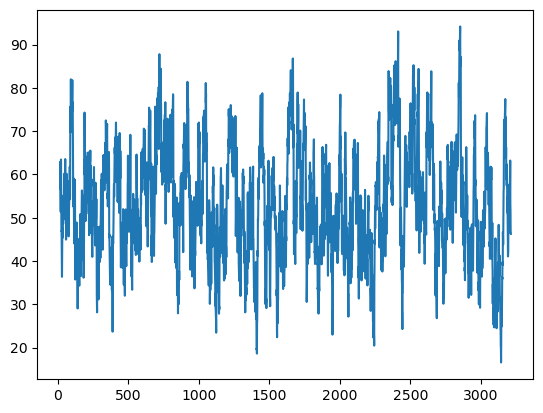

In [32]:
plt.plot(df_tsla_hist_merged2['RSI_tsla'])

#### VWAP TSLA

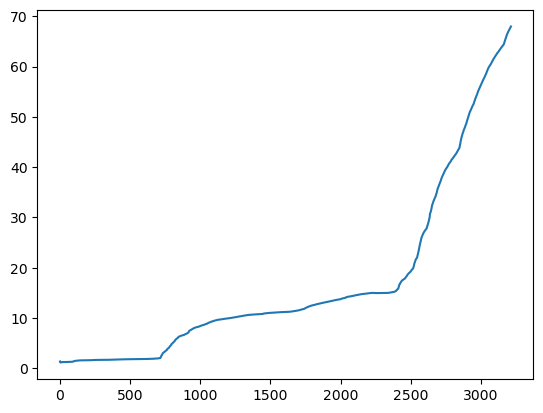

In [33]:
plt.plot(df_tsla_hist_merged2['VWAP_tsla'])

#### OBV TSLA

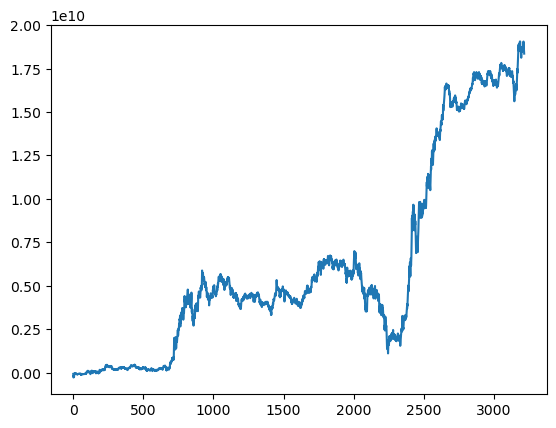

In [34]:
plt.plot(df_tsla_hist_merged2['OBV_tsla'])

#### EMV TSLA

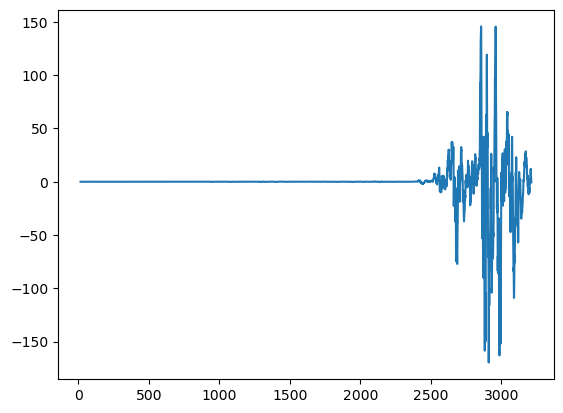

In [35]:
plt.plot(df_tsla_hist_merged3['EMV_tsla'])

#### ATR TSLA

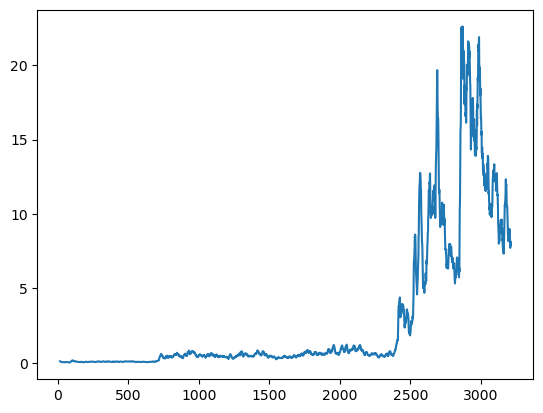

In [36]:
plt.plot(df_tsla_hist_merged3['ATR_tsla'])

### 4.2 APPL Featuring Engineering

In [37]:
df_appl_hist_merged2['pct_change_Volume_appl']=df_appl_hist_merged2['Volume_appl'].pct_change()
df_appl_hist_merged2['Price_variation_appl']=df_appl_hist_merged2['Close'].diff()
df_appl_hist_merged2.dropna(inplace=True)

In [38]:
df_appl_hist_merged2=OBV_ind(df_appl_hist_merged2,'appl')
df_appl_hist_merged2['VWAP_appl'] = (((df_appl_hist_merged2['High'] + df_appl_hist_merged2['Low'] + df_appl_hist_merged2['Close']) / 3) * df_appl_hist_merged2['Volume_appl']).cumsum() / df_appl_hist_merged2['Volume_appl'].cumsum()
df_appl_hist_merged2['RSI_appl'] = rsi(df_appl_hist_merged2['Close'])
df_appl_hist_merged3=EMV_ind(df_appl_hist_merged2, 14, 'appl')
df_appl_hist_merged3.rename(columns = {'EMV':'EMV_appl'}, inplace = True)
df_appl_hist_merged3['ATR_appl'] = atr(df_appl_hist_merged2['High'], df_appl_hist_merged2['Low'], df_appl_hist_merged2['Close'], 14)
df_appl_hist_merged3.dropna(inplace=True)
df_appl_hist_merged3

date  sent_score_appl        Low       Open  Volume_appl  \
15   2006-12-22           0.7269   2.914286   2.980714    613303600   
16   2006-12-26          -0.7685   2.888929   2.933929    490688800   
17   2006-12-27           0.9488   2.741786   2.791071   1935754800   
18   2006-12-28           0.8636   2.844643   2.865000   1119876800   
19   2006-12-29           0.8914   2.977143   2.998214   1076429200   
...         ...              ...        ...        ...          ...   
2512 2016-11-23           0.0000  27.582500  27.840000    109705600   
2513 2016-11-25          -0.8990  27.737499  27.782499     45903600   
2514 2016-11-28           0.0000  27.847500  27.857500    108776000   
2515 2016-11-29           0.0000  27.517500  27.695000    114115200   
2516 2016-11-30           0.0000  27.567499  27.900000    144649200   

           High      Close  Adj Close_appl  Adj Close_nasdaq  Volume_nasdaq  \
15     3.001429   2.935714        2.528717       1748.609985   1.306530e+09   
16     2.948929   2.911071        2.507491       1753.550049   1.016200e+09   
17     2.928571   2.911429        2.507798       1763.410034   1.216260e+09   
18     2.901786   2.888214        2.487802       1758.939941   1.237530e+09   
19     3.050000   3.030000        2.609932       1756.900024   1.413920e+09   
...         ...        ...             ...               ...            ...   
2512  27.877501  27.807501       26.296761       4853.859863   1.617700e+09   
2513  27.967501  27.947500       26.429152       4870.020020   7.680800e+08   
2514  28.117500  27.892500       26.377140       4857.020020   1.630150e+09   
2515  28.007500  27.865000       26.351133       4873.209961   1.791760e+09   
2516  28.049999  27.629999       26.128902       4810.810059   2.056060e+09   

      Vix_index  pct_change_Volume_appl  Price_variation_appl     OBV_appl  \
15        11.36               -0.321266             -0.025000  -4042256400   
16        11.26               -0.199925             -0.024643  -4532945200   
17        10.64                2.944974              0.000358  -2597190400   
18        10.99               -0.421478             -0.023215  -3717067200   
19        11.56               -0.038797              0.141786  -2640638000   
...         ...                     ...                   ...          ...   
2512      12.43                0.056263             -0.142500  33276839600   
2513      12.34               -0.581575              0.139999  33322743200   
2514      13.15                1.369662             -0.055000  33213967200   
2515      12.90                0.049084             -0.027500  33099852000   
2516      13.33                0.267572             -0.235001  32955202800   

      VWAP_appl   RSI_appl  EMV_appl  ATR_appl  
15     3.124948  25.553987 -0.000310  0.085204  
16     3.116390  24.161564 -0.000350  0.085765  
17     3.080766  24.226136 -0.000382  0.094719  
18     3.065663  22.866022 -0.000308  0.089617  
19     3.062546  43.667788 -0.000226  0.088724  
...         ...        ...       ...       ...  
2512  10.829469  49.710255 -0.009152  0.562857  
2513  10.830047  51.719905  0.005495  0.541071  
2514  10.831423  50.860018  0.004902  0.541607  
2515  10.832853  50.408741 -0.008584  0.540535  
2516  10.834660  46.603317 -0.001161  0.516607  

[2502 rows x 18 columns]

Below, for visualization purpose, the plots of the market indicators computed for APPL are plotted.

#### RSI APPL

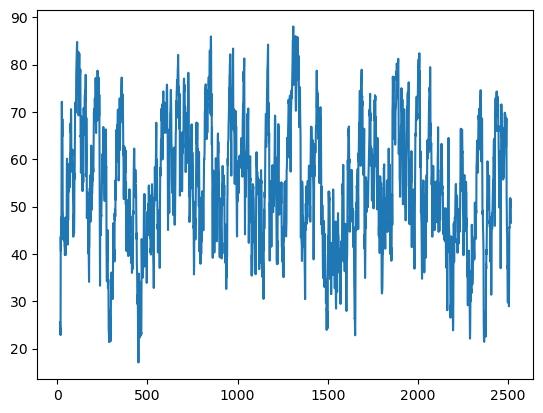

In [39]:
plt.plot(df_appl_hist_merged3['RSI_appl'])

#### VWAP APPL

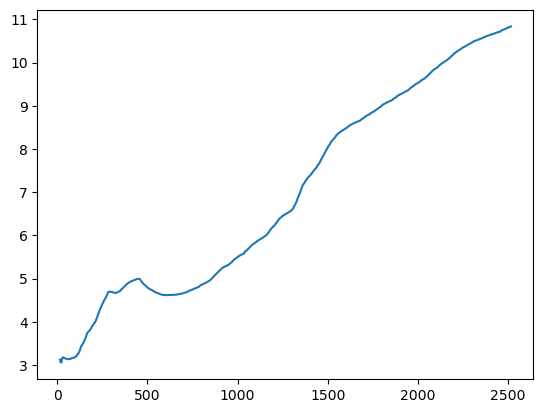

In [40]:
plt.plot(df_appl_hist_merged3['VWAP_appl'])

#### OBV APPL

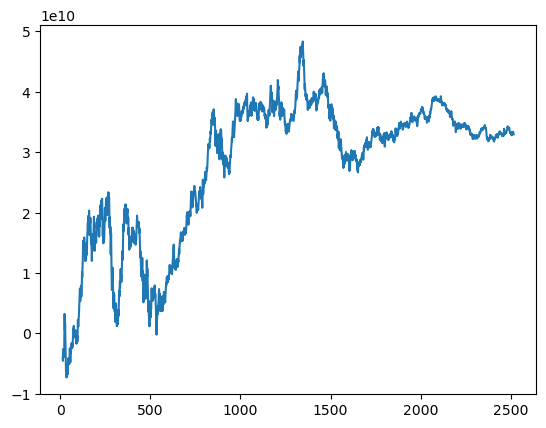

In [41]:
plt.plot(df_appl_hist_merged3['OBV_appl'])

#### EMV APPL

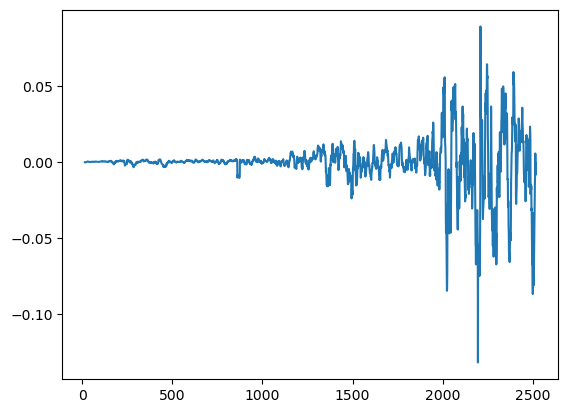

In [42]:
plt.plot(df_appl_hist_merged3['EMV_appl'])

#### ATR APPL

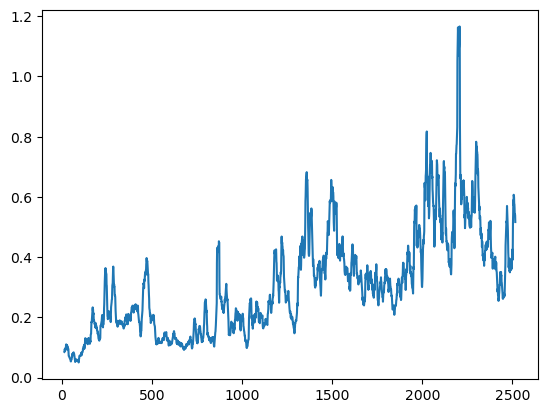

In [43]:
plt.plot(df_appl_hist_merged3['ATR_appl'])

## 5 FEATURES SELECTION
Feature Selection is one of the core concepts in machine learning and Deep learning. The main goal is identifying the related features from a set of data and removing the irrelevant or less important features that do not contribute much to our target variable in order to achieve better accuracy for our model. The features selection here will be performed by relying on the results coming from VIF analysi and Pearson correlation.

<font size="4">**5.1 Variation Inflation Factor (VIF) analysis**</font>

<font size="2"> VIF is a test used for measuring multicollinearity issues between the indipendent variables, whose presence can adversely affect the results of the predictive model. VIF provide a measure about how much of an independent feature is influenced by its correlation with the other independent features. In general, we have the follwoing thresholds:</font>

    -VIF equal to 1 = variables are not correlated
    -VIF between 1 and 5 = variables are moderately correlated 
    -VIF greater than 5 = variables are highly correlated

<font size="2"> One approch for reducing multicollinearity issues is to eliminate the indipendent variables whose VIF is high (greater than 5), although for the present work only features with very relative high values of VIF will be eliminated.</font>

### 5.1.1 VIF TSLA

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
df_tsla_VIF = df_tsla_hist_merged3.drop(['date','pct_change_Volume_TSLA'], axis = 1)
# VIF dataframe
vif_data_tsla = pd.DataFrame()
vif_data_tsla["feature"] = df_tsla_VIF.columns
# calculating VIF for each feature
vif_data_tsla["VIF"] = [variance_inflation_factor(df_tsla_VIF.values, i)
                          for i in range(len(df_tsla_VIF.columns))]
  
vif_data_tsla

C:\Users\loren\anaconda3\envs\myenvpython\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature          VIF
0                   Open  6669.213677
1                   High  7984.824587
2                    Low  6428.710231
3                  Close          inf
4         Adj Close_tsla          inf
5            Volume_tsla     3.984053
6        sent_score_tsla     1.051785
7       Adj Close_nasdaq    32.529943
8          Volume_nasdaq    25.111654
9              Vix_index     9.538290
10  Price_variation_tsla     3.536180
11              OBV_tsla    38.043312
12             VWAP_tsla    20.417537
13              RSI_tsla     9.110270
14              EMV_tsla     1.629770
15              ATR_tsla    25.023162

It observable a really highly multicollinearity between the stock price features, which is to be expected.

### 5.1.1 VIF APPL

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_appl_VIF = df_appl_hist_merged3.drop(['date','pct_change_Volume_appl'], axis = 1)
# VIF dataframe
vif_data_appl = pd.DataFrame()
vif_data_appl["feature"] = df_appl_VIF.columns
# calculating VIF for each feature
vif_data_appl["VIF"] = [variance_inflation_factor(df_appl_VIF.values, i)
                          for i in range(len(df_appl_VIF.columns))]
  
vif_data_appl

feature           VIF
0        sent_score_appl      1.597602
1                    Low  36136.020802
2                   Open  32215.109578
3            Volume_appl      8.147933
4                   High  44408.143272
5                  Close  54985.809666
6         Adj Close_appl   6410.972528
7       Adj Close_nasdaq    323.864968
8          Volume_nasdaq     30.239170
9              Vix_index     13.769412
10  Price_variation_appl      2.446102
11              OBV_appl     30.475099
12             VWAP_appl    188.904102
13              RSI_appl     26.006464
14              EMV_appl      1.496326
15              ATR_appl     21.500846

Similar to TSLA case, high multicollinearity is observed for the stock price features for APPL as well. 

<font size="5">**5.2. Correlation**</font>

<font size="2"> In addition to VIF analysis, measuring the Pearson coefficient between the indipendent variable can provide further information about how strong a relantioship is between data. The correlation coefficient range from -1 to 1:</font>

  - 1 indicates a strong positive relationship.
  - 1 indicates a strong negative relationship.
  - A result of zero indicates no relationship at all.

<font size="2">If two variables are highly correlated, it implies that they contribute with the same information and it would be redundant including all of them in a model. High correlation can cause multicollinearity issue again, making difficult the act of determining the independent effect of each variable on the target variable. To address this issue, counting out variables with high correlation is advisable whenever possible in order to improve the efficiency and accuracy of the prediction model.  
Looking at the matrix correlations below, the results of both TSLA and APPL approximatly reflect what was observed in VIF analysis with high correletion between the stock price features (Open, Close, High, etc.) which is to be expected. A relevant correlation between stock price and index price variables is observed as well.

</font>

### 5.2.1 Pearson correlation TSLA

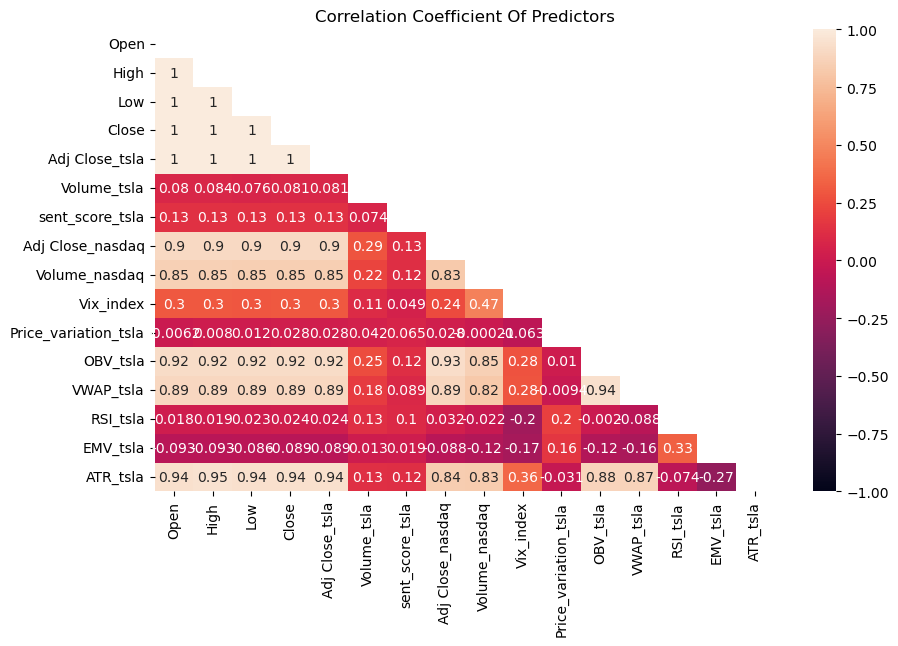

In [46]:
### Pearson Cooefficient
df_tsla_corr=df_tsla_hist_merged3.drop(['date','pct_change_Volume_TSLA'], axis = 1)

# set figure size
plt.figure(figsize=(10,6))
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df_tsla_corr.corr(), dtype=bool))
# generate heatmap of correlation
sns.heatmap(df_tsla_corr.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.savefig(fig_dir+'Corr_TSLA.png', transparent=False)
plt.show()

### 5.2.2 Pearson correlation APPL

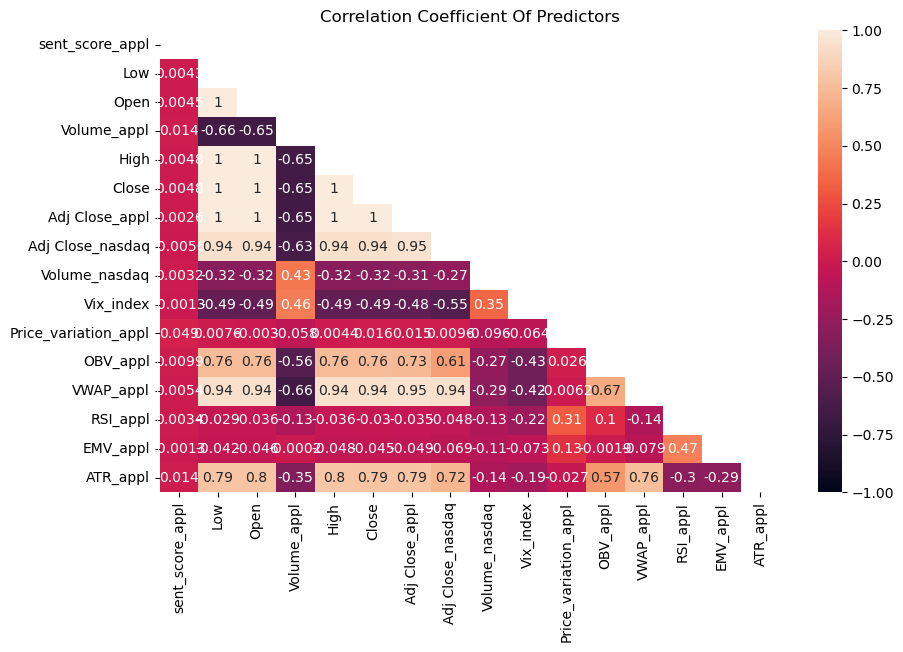

In [47]:
### Pearson Cooefficient
df_appl_corr=df_appl_hist_merged3.drop(['date','pct_change_Volume_appl'], axis = 1)

# set figure size
plt.figure(figsize=(10,6))
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df_appl_corr.corr(), dtype=bool))
# generate heatmap of correlation
sns.heatmap(df_appl_corr.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.savefig(fig_dir+'Corr_APPL.png', transparent=False)
plt.show()

## 6. ASSES THE STATIONARITY OF DATA
Stationarity is really the foundational concept in time series analysis. Maintaining stationarity might be relvant in prediction since:  
- it is among Assumptions of many time series models,  
- easier modeling and forecasting since stationarity simplifies the complexities within time series data, making it easier to model and forecast than non-stationary time series,  
- improved model performance. A stationary time series typically results in improved model performance.

### 6.1. TSLA Time serie visual inspection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


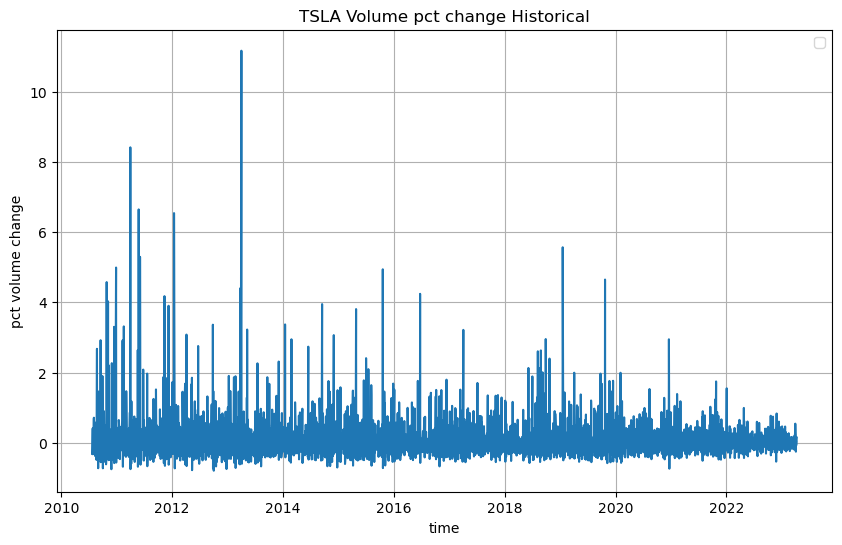

In [48]:
#Plotting the percent change of Volume over the time
plt.figure(figsize=(10,6))
plt.plot(df_tsla_hist_merged3['date'],df_tsla_hist_merged3['pct_change_Volume_TSLA'])
plt.grid()
plt.xlabel('time')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('TSLA Volume pct change Historical')
#plt.savefig(fig_dir+'AR_TSLA.png', transparent=False)
plt.show()

### 6.2 APPL Time serie visual inspection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


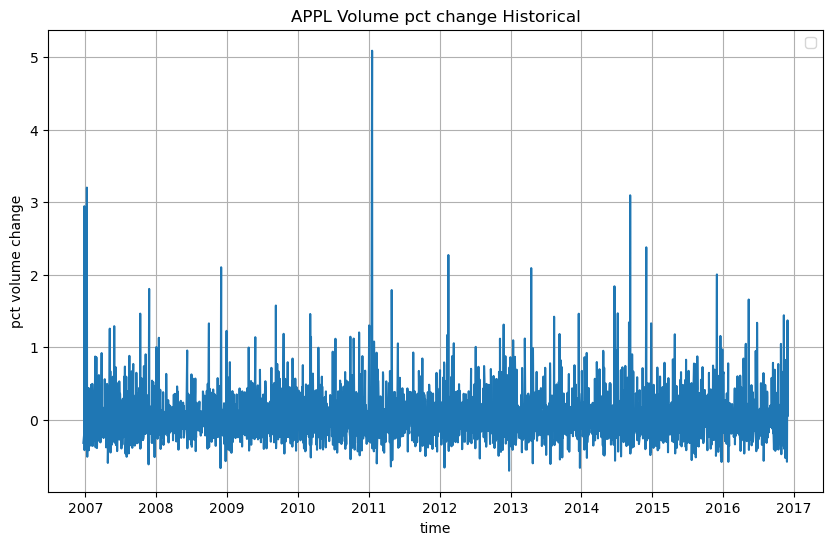

In [49]:
#Plotting the percent change of Volume over the time
plt.figure(figsize=(10,6))
plt.plot(df_appl_hist_merged3['date'],df_appl_hist_merged3['pct_change_Volume_appl'])
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('pct volume change')
plt.title('APPL Volume pct change Historical')
plt.show()

The visual inspection led to regard the time serie of the volume percent change of both stock as stationarity.

An additional and useful process to explore relevant characteristics of the time series is breaking it down into individual components.  
Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise. Trend can be reagrded as the increasing or decreasing value in the series, Seasonality as the repeating short-term cycle in the series and Noise as the random variation in the series.


### 6.3 TSLA Time series decomposition

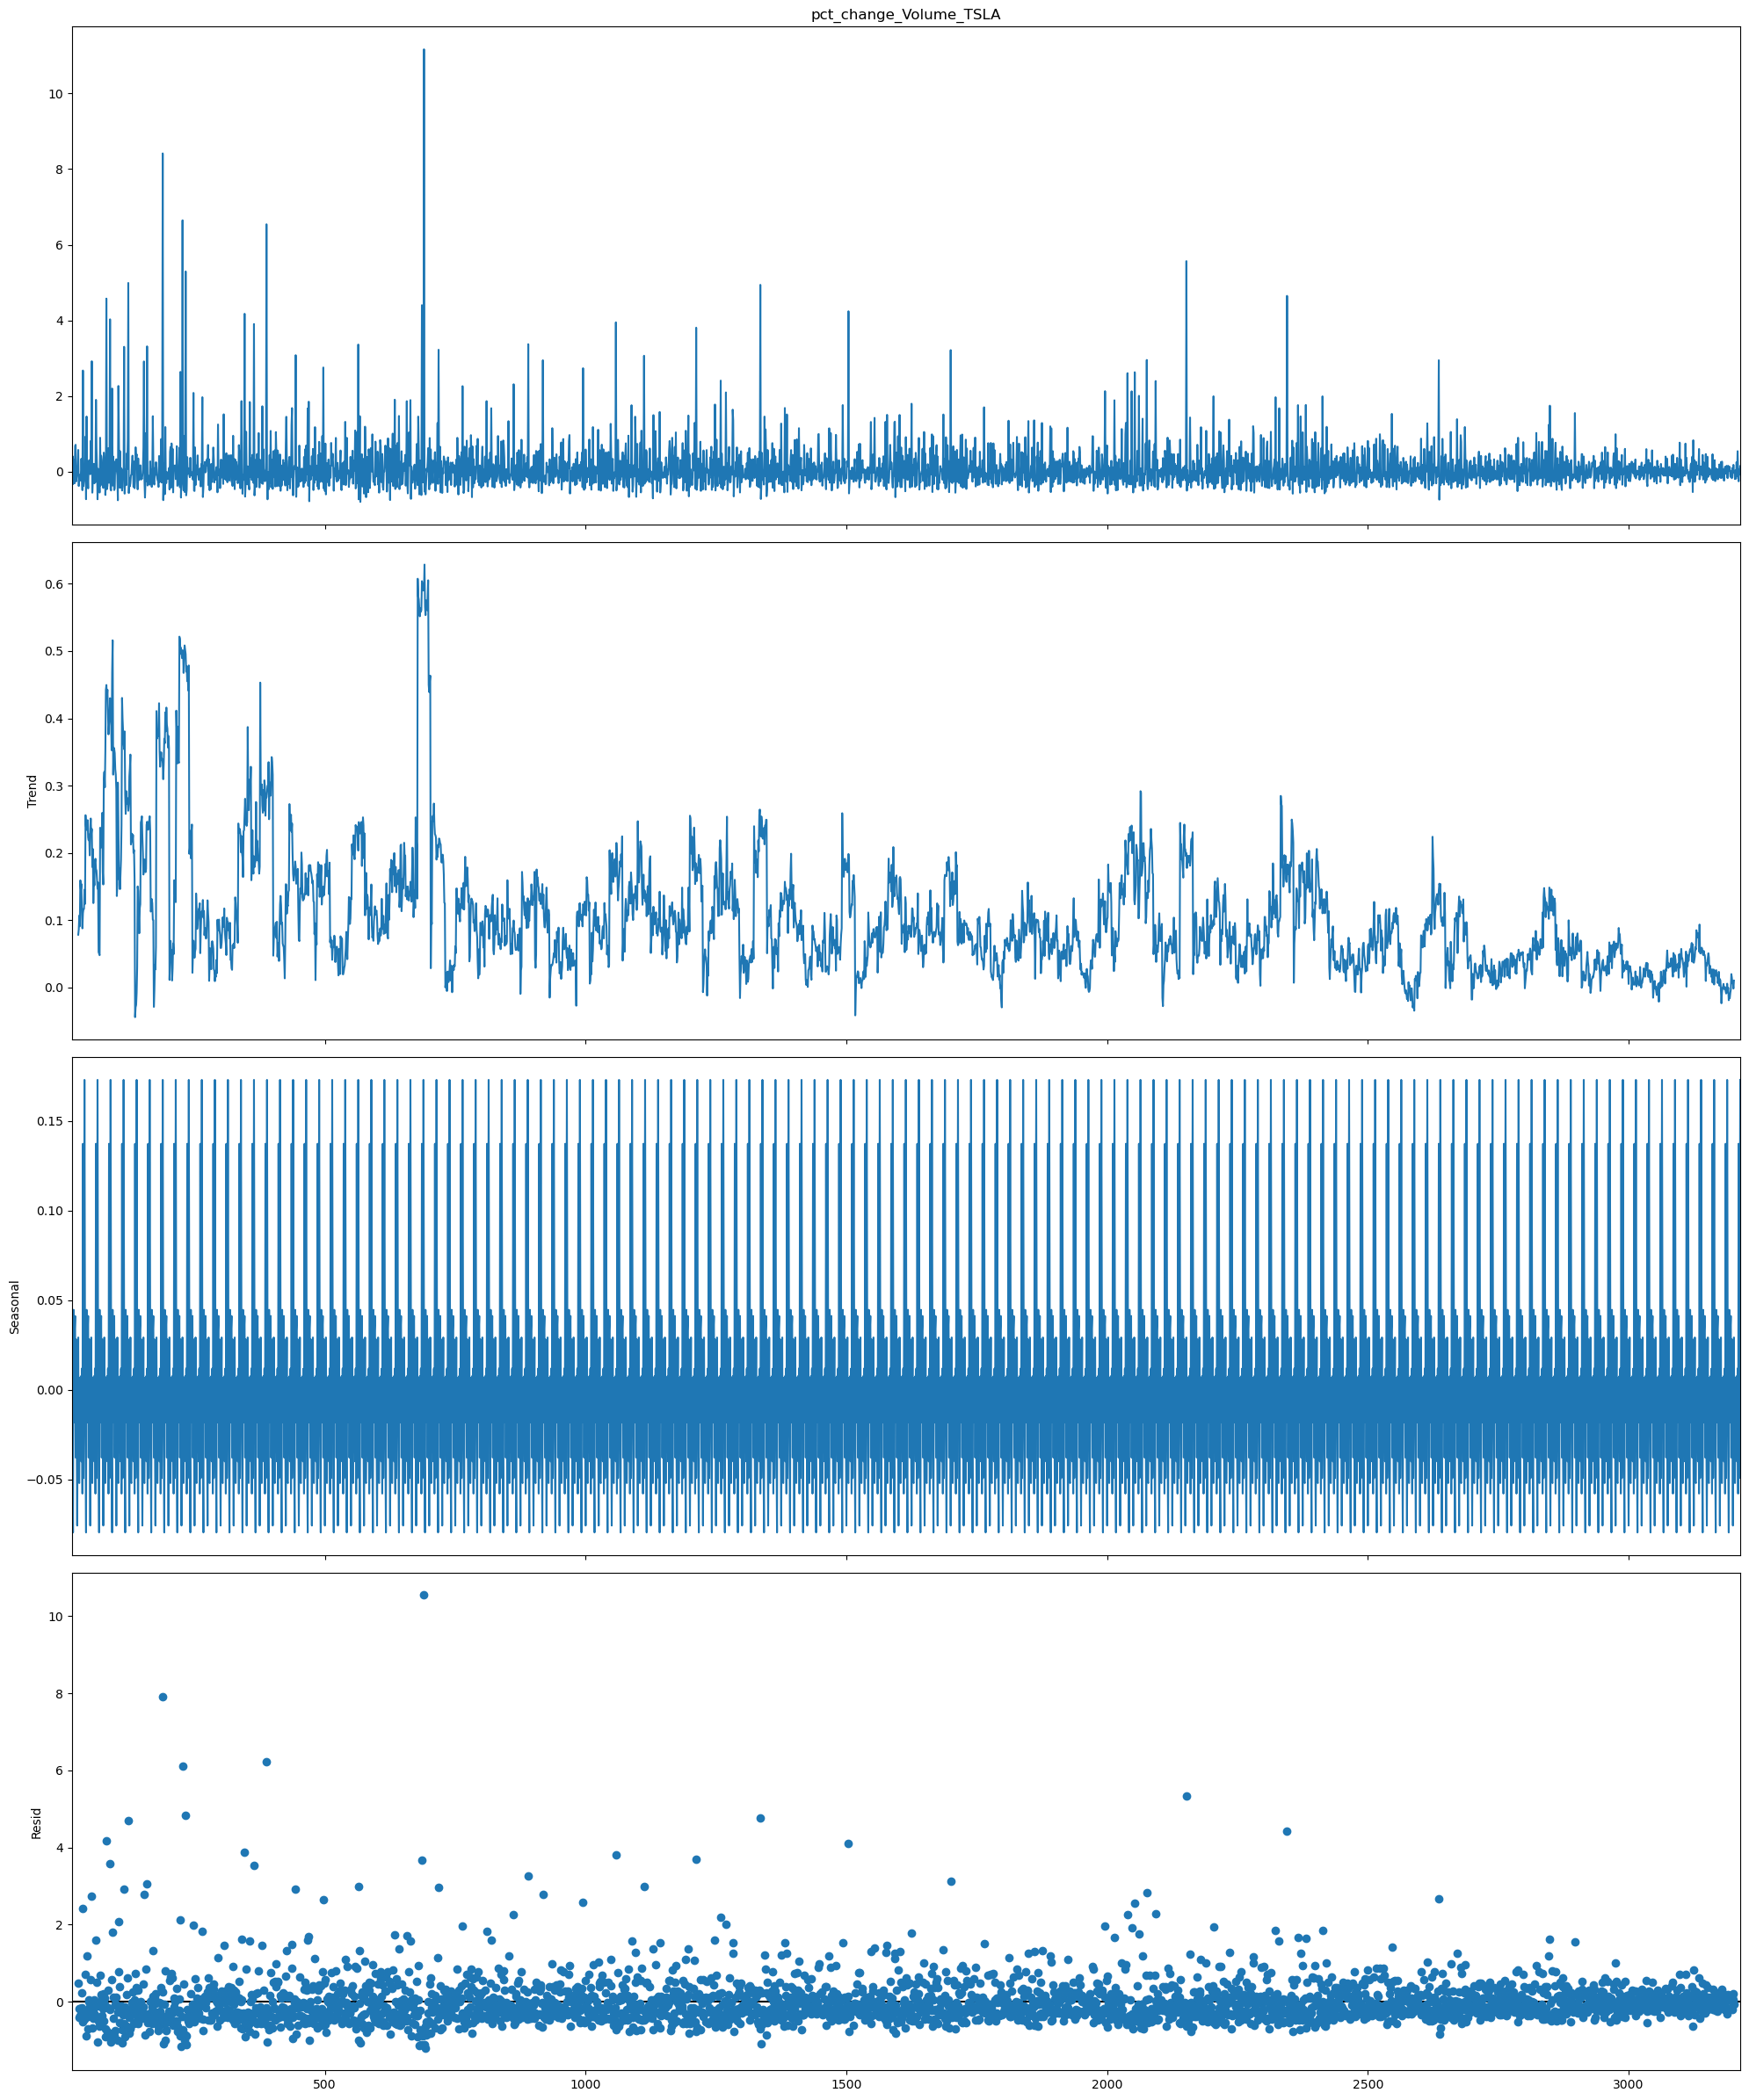

In [50]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20,24
decomposition = sm.tsa.seasonal_decompose(df_tsla_hist_merged3.pct_change_Volume_TSLA, model='additive',period=25) # additive seasonal index
fig = decomposition.plot()
plt.show()

### 6.4 APPL Time series decomposition

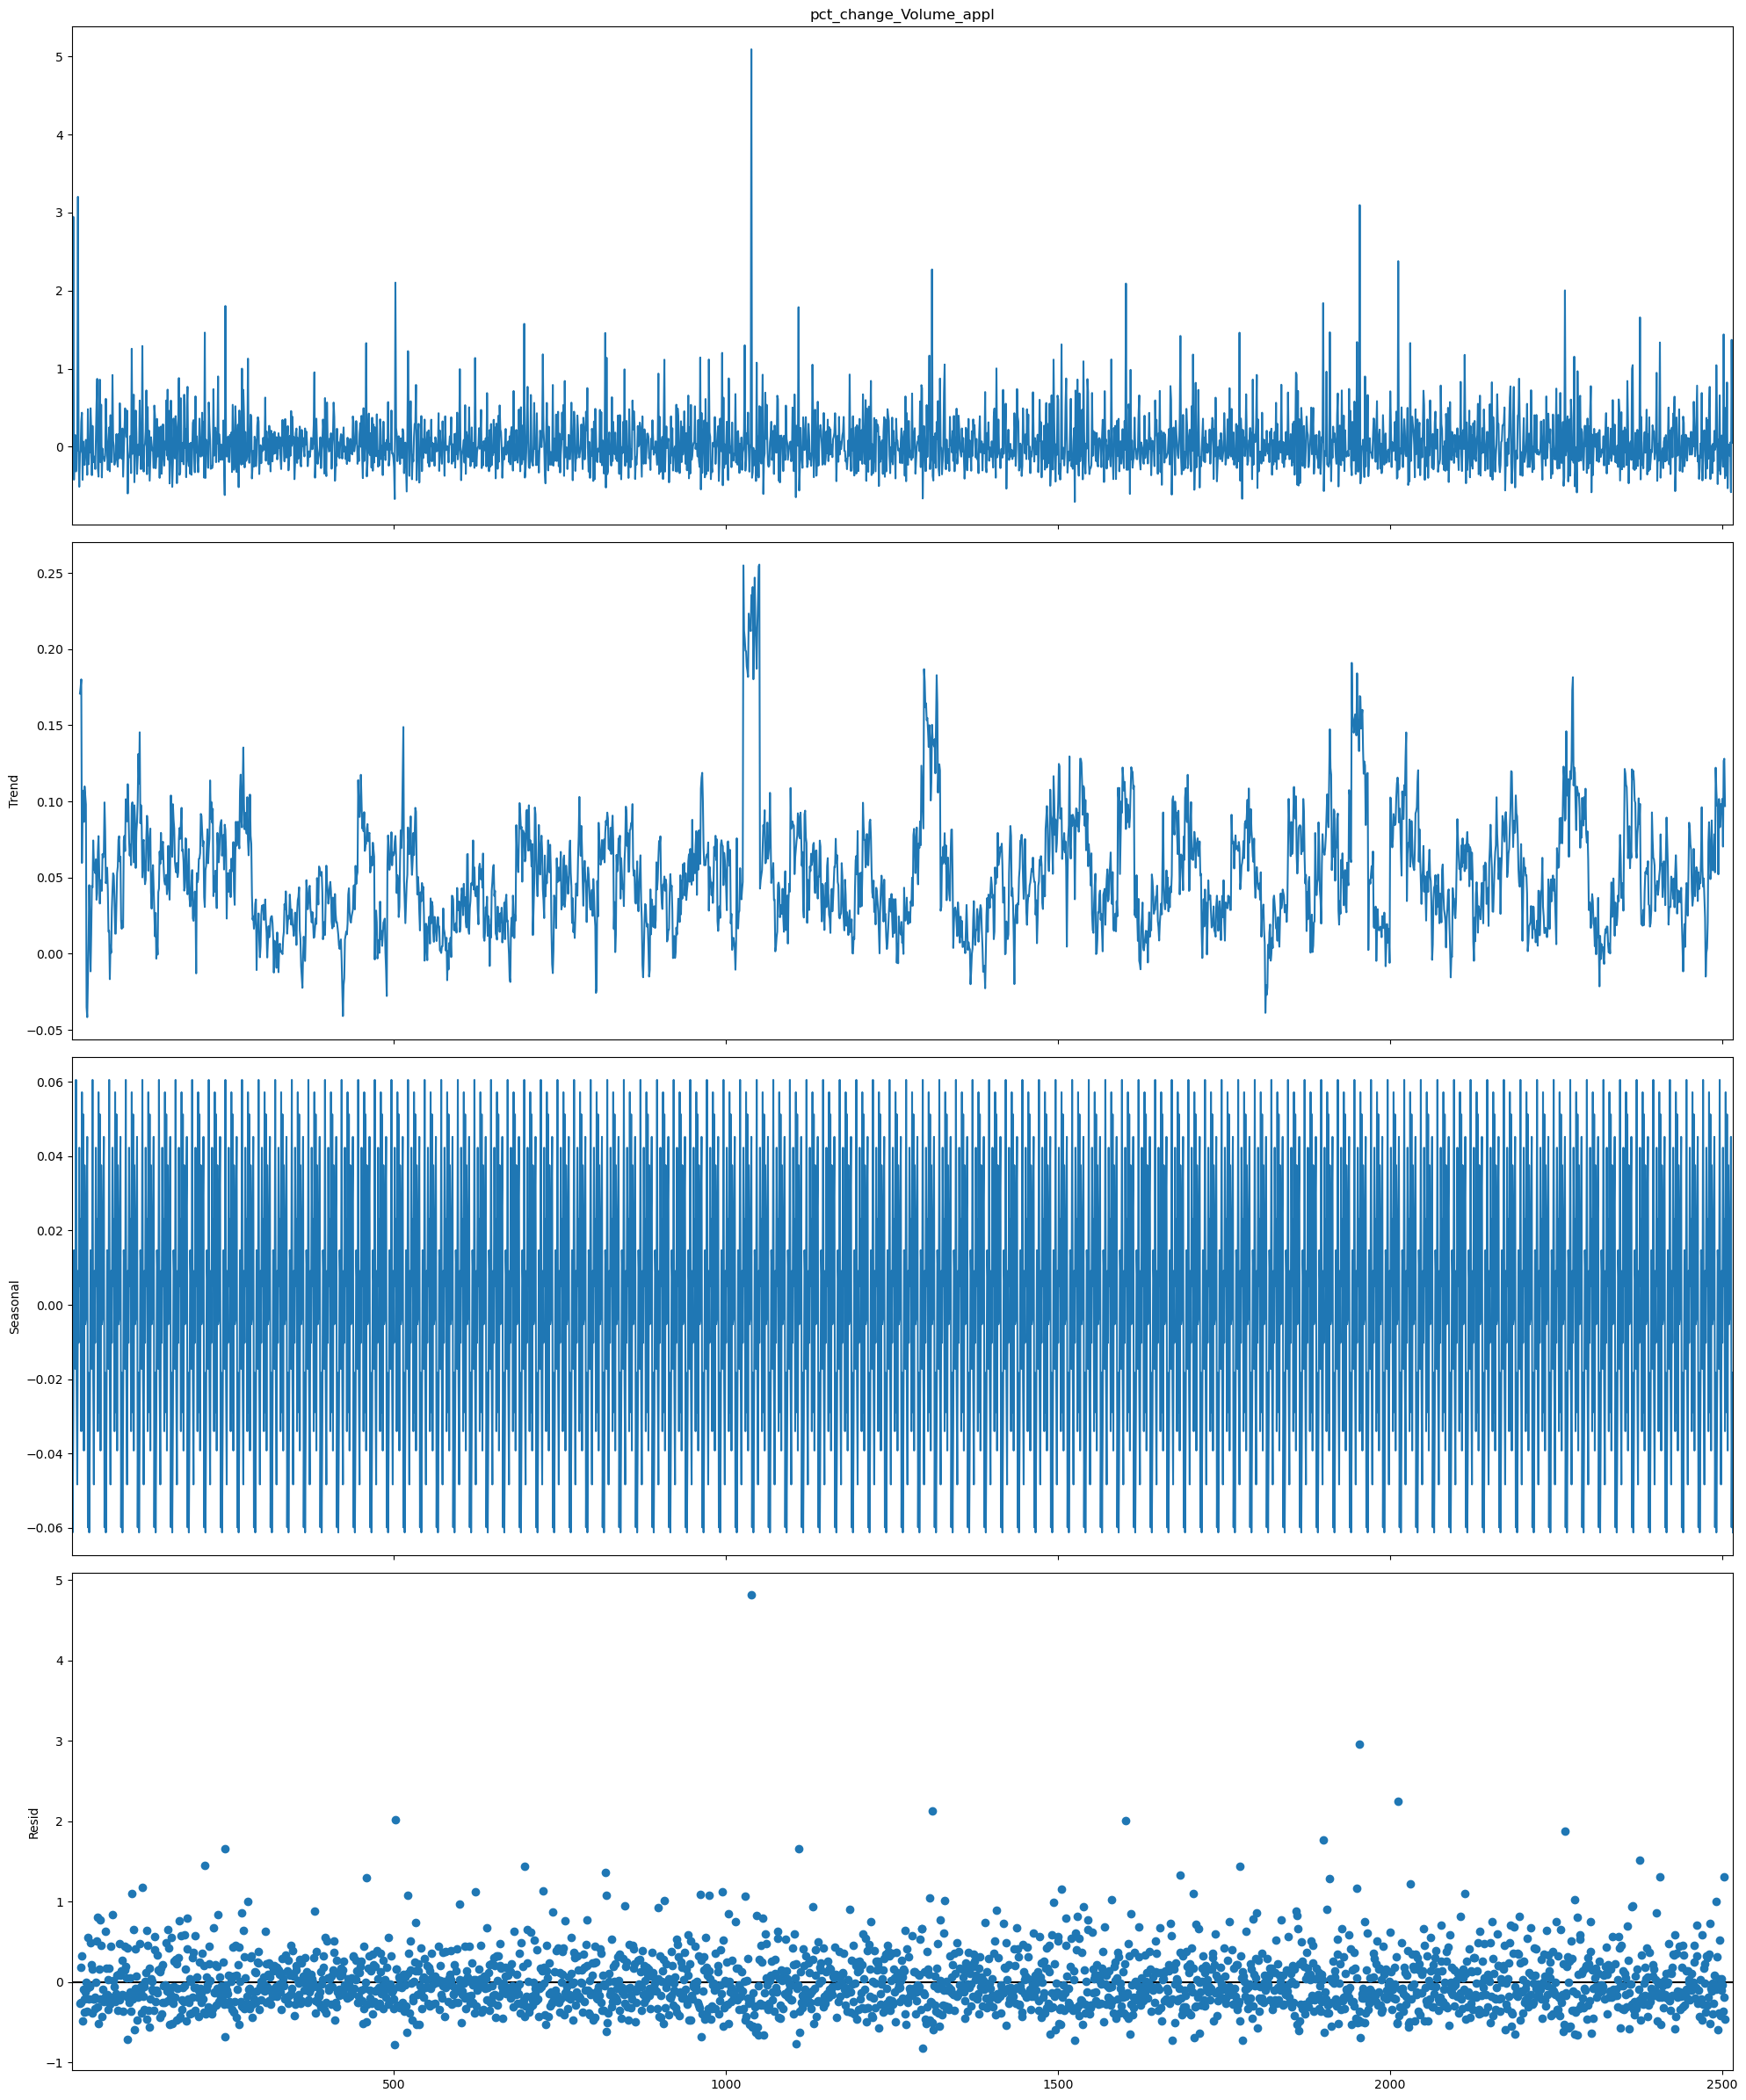

In [51]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20,24
decomposition = sm.tsa.seasonal_decompose(df_appl_hist_merged3.pct_change_Volume_appl, model='additive',period=25) # additive seasonal index
fig = decomposition.plot()
plt.show()

### 6.5 Augmented Dickey Fuller test (ADF Test)

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. 
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.  
In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. In simple terms, the unit root is non-stationary but does not always have a trend component.  
ADF test is conducted with the following assumptions:  
- Null Hypothesis (HO): Series is non-stationary, or series has a unit root.  
- Alternate Hypothesis(HA): Series is stationary, or series has no unit root.  
- If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

In [52]:
def dickey_fuller(series,title=' '):
    '''This is a convenience function to help interpret the result of the Augmented Dickey Fuller Test'''
    
    from statsmodels.tsa.stattools import adfuller
    
    print(f'Augmented Dickey Fuller test for stationarity:{title}')
    
    result = adfuller(series,autolag='AIC')
    labels = ['ADF test statistics','p-value','# lags used','# observations']
    
    adf_outcome = pd.Series(data=result[0:4],index=labels)
    
    for key,val in result[4].items():
        adf_outcome[f'critical value ({key})'] = val
        
    print(adf_outcome.to_string())   # to_string will get rid of the dtype:float64 which gets printed
    
    # Hypothesis Test Outcome
    
    if result[1] < 0.05:
        print('Strong evidence against the Null hypothesis')
        print('Reject the Null hypothesis')
        print('The time series data is stationary')
    else:
        print('There is not enough evidence against the Null hypothesis')
        print('Fail to reject the Null hypothesis')
        print('The time series data is non stationary') 

### 6.5.1 TSLA Augmented Dickey Fuller test (ADF Test)

In [53]:
dickey_fuller(df_tsla_hist_merged3['pct_change_Volume_TSLA'],title='TSLA_pct_Volume_change')

Augmented Dickey Fuller test for stationarity:TSLA_pct_Volume_change
ADF test statistics      -20.112943
p-value                    0.000000
# lags used                8.000000
# observations          3191.000000
critical value (1%)       -3.432401
critical value (5%)       -2.862446
critical value (10%)      -2.567252
Strong evidence against the Null hypothesis
Reject the Null hypothesis
The time series data is stationary


### 6.5.2 APPL Augmented Dickey Fuller test (ADF Test)

In [54]:
dickey_fuller(df_appl_hist_merged3['pct_change_Volume_appl'],title='APPL_pct_Volume_change')

Augmented Dickey Fuller test for stationarity:APPL_pct_Volume_change
ADF test statistics      -21.023552
p-value                    0.000000
# lags used                8.000000
# observations          2493.000000
critical value (1%)       -3.432976
critical value (5%)       -2.862700
critical value (10%)      -2.567388
Strong evidence against the Null hypothesis
Reject the Null hypothesis
The time series data is stationary


## 7. STATISTICS
Below are shown the statistics of the distribution of Volume percentage change and itsplot is displayed.

### 7.1 TSLA Statistic and Distribution plot

In [55]:
df_tsla_hist_merged3['pct_change_Volume_TSLA'].describe()

count    3200.000000
mean        0.105303
std         0.639718
min        -0.796381
25%        -0.227293
50%        -0.028958
75%         0.263591
max        11.167515
Name: pct_change_Volume_TSLA, dtype: float64

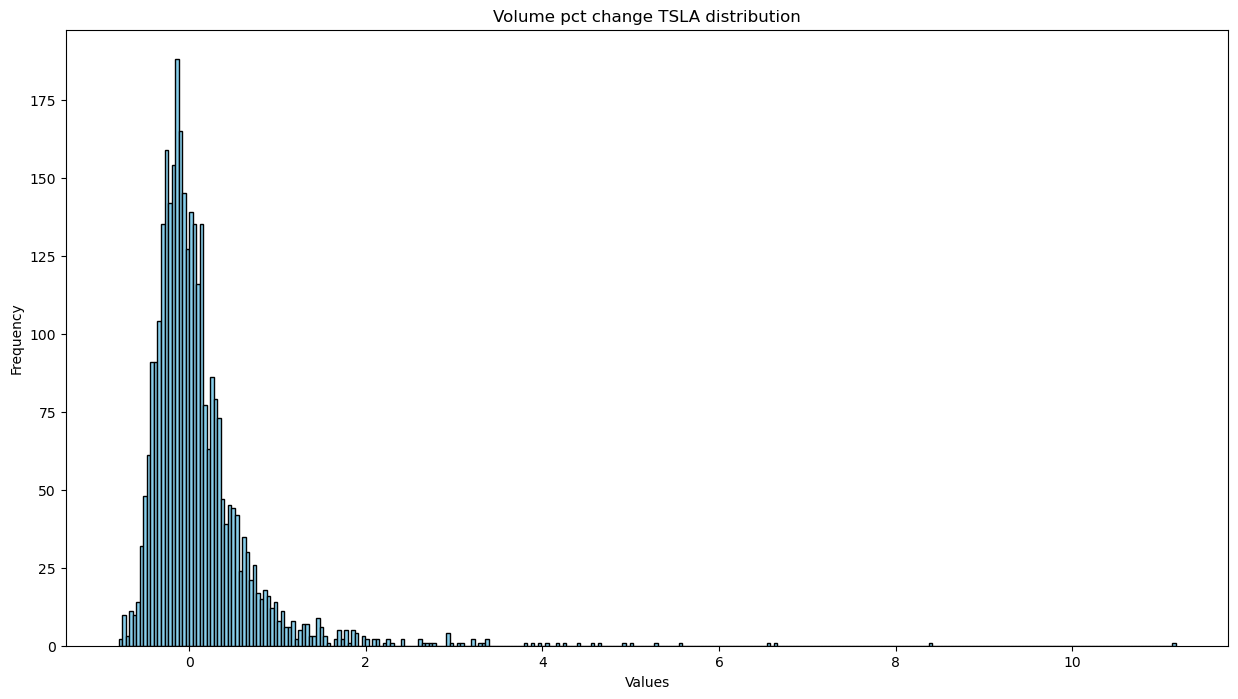

In [56]:
plt.figure(figsize=(15,8))
plt.hist(df_tsla_hist_merged3['pct_change_Volume_TSLA'], bins=300, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Volume pct change TSLA distribution')
plt.show()

### 7.2 APPL Statistic and Distribution plot

In [57]:
df_appl_hist_merged3['pct_change_Volume_appl'].describe()

count    2502.000000
mean        0.053262
std         0.378656
min        -0.705245
25%        -0.184318
50%        -0.017475
75%         0.210879
max         5.090526
Name: pct_change_Volume_appl, dtype: float64

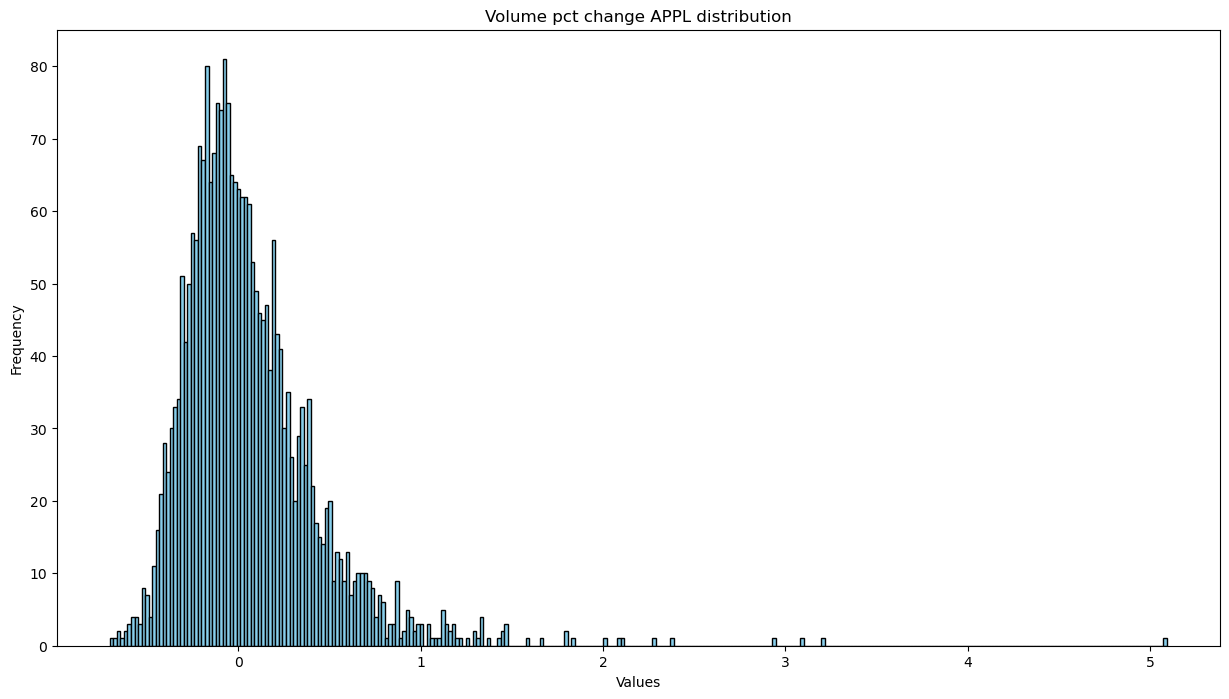

In [58]:
plt.figure(figsize=(15,8))
plt.hist(df_appl_hist_merged3['pct_change_Volume_appl'], bins=300, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Volume pct change APPL distribution')
plt.show()

## 8. ROLLING AVERAGES DATA

In order to try to improve the quality of the predictions, we try now to define smoothed indipendent and target variable. The current target variable (daily volume percentage change), as it is, looks similar to white noise, which might turn out being more difficult to be predicted.  From economical perspective, this would mean that we are going to focus more on medium-term changes of volume instead of random daily fluctuations.  
A rolling window process will aplied on the data in order to compute the medium-term averages. The size of the rolling window choosen is 10 days.

### 8.1 TSLA Data Rolling

In [59]:
df_tsla_hist_merged4=df_tsla_hist_merged3.drop(['date'], axis = 1).reset_index().drop(columns=['index'])

In [60]:
df_tsla_hist_merged_roll=df_tsla_hist_merged4.rolling(10).mean()
df_tsla_hist_merged_roll

Open        High         Low       Close  Adj Close_tsla  \
0            NaN         NaN         NaN         NaN             NaN   
1            NaN         NaN         NaN         NaN             NaN   
2            NaN         NaN         NaN         NaN             NaN   
3            NaN         NaN         NaN         NaN             NaN   
4            NaN         NaN         NaN         NaN             NaN   
...          ...         ...         ...         ...             ...   
3195  194.706000  198.317000  190.341997  194.375002      194.375002   
3196  195.610001  198.391000  190.569998  193.875002      193.875002   
3197  194.732001  197.392999  189.850998  193.312003      193.312003   
3198  193.514002  196.100999  188.959999  192.596002      192.596002   
3199  192.343002  195.375000  187.856000  192.006001      192.006001   

      Volume_tsla  sent_score_tsla  Adj Close_nasdaq  Volume_nasdaq  \
0             NaN              NaN               NaN            NaN   
1             NaN              NaN               NaN            NaN   
2             NaN              NaN               NaN            NaN   
3             NaN              NaN               NaN            NaN   
4             NaN              NaN               NaN            NaN   
...           ...              ...               ...            ...   
3195  135746050.0        -0.013434      12822.738086   4.702981e+09   
3196  133053290.0        -0.056066      12858.602051   4.649870e+09   
3197  131403900.0        -0.069168      12898.607031   4.589570e+09   
3198  129370300.0        -0.030865      12931.943945   4.484104e+09   
3199  131954520.0        -0.030030      12960.362012   4.481146e+09   

      Vix_index  pct_change_Volume_TSLA  Price_variation_tsla      OBV_tsla  \
0           NaN                     NaN                   NaN           NaN   
1           NaN                     NaN                   NaN           NaN   
2           NaN                     NaN                   NaN           NaN   
3           NaN                     NaN                   NaN           NaN   
4           NaN                     NaN                   NaN           NaN   
...         ...                     ...                   ...           ...   
3195     20.395                0.046903              1.152000  1.877270e+10   
3196     20.157                0.003212             -0.500000  1.877348e+10   
3197     19.839                0.011044             -0.562999  1.877592e+10   
3198     19.418                0.007668             -0.716000  1.875154e+10   
3199     19.141                0.041776             -0.590001  1.872459e+10   

      VWAP_tsla   RSI_tsla  EMV_tsla  ATR_tsla  
0           NaN        NaN       NaN       NaN  
1           NaN        NaN       NaN       NaN  
2           NaN        NaN       NaN       NaN  
3           NaN        NaN       NaN       NaN  
4           NaN        NaN       NaN       NaN  
...         ...        ...       ...       ...  
3195  67.524110  54.917432  3.055642  8.525787  
3196  67.579684  54.314307  3.924793  8.476073  
3197  67.634189  53.687692  3.871187  8.411930  
3198  67.687415  52.967639  4.020229  8.309930  
3199  67.741258  52.340403  4.171237  8.207859  

[3200 rows x 17 columns]

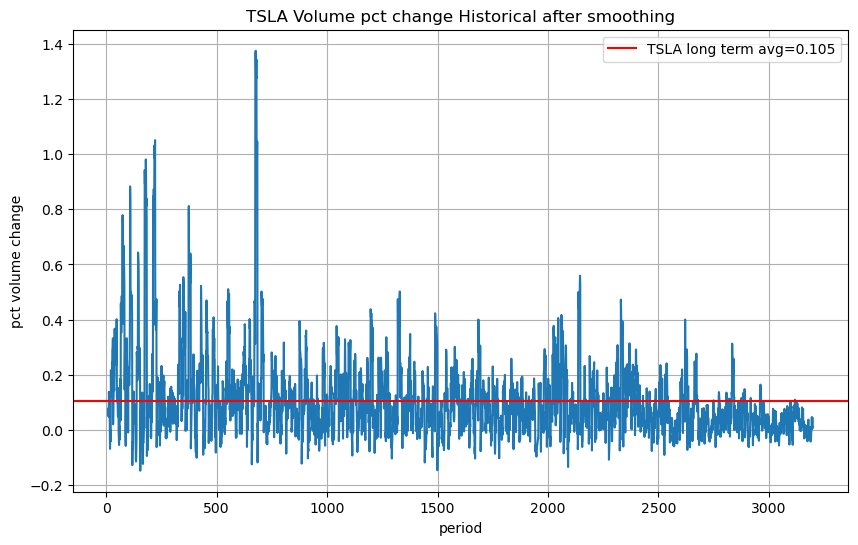

In [61]:
plt.figure(figsize=(10,6))
plt.plot(df_tsla_hist_merged_roll['pct_change_Volume_TSLA'])
#plt.plot(df_tsla_hist_merged3['date'],df_tsla_hist_merged3['pct_change_Volume_TSLA'])
plt.axhline(0.1055, color='r',label='TSLA long term avg=0.105')
plt.grid()
plt.legend(loc='best')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.title('TSLA Volume pct change Historical after smoothing')
plt.show()

In [62]:
df_tsla_hist_merged_roll['pct_change_Volume_TSLA'].mean()

0.10553674348256165

### 8.2 APPL Data Rolling

In [63]:
df_appl_hist_merged4=df_appl_hist_merged3.drop(['date'], axis = 1).reset_index().drop(columns=['index'])

In [64]:
df_appl_hist_merged_roll=df_appl_hist_merged4.rolling(10).mean()
df_appl_hist_merged_roll

sent_score_appl       Low      Open  Volume_appl      High     Close  \
0                 NaN       NaN       NaN          NaN       NaN       NaN   
1                 NaN       NaN       NaN          NaN       NaN       NaN   
2                 NaN       NaN       NaN          NaN       NaN       NaN   
3                 NaN       NaN       NaN          NaN       NaN       NaN   
4                 NaN       NaN       NaN          NaN       NaN       NaN   
...               ...       ...       ...          ...       ...       ...   
2497          0.34737  26.98625  27.30375  148910520.0  27.56225  27.34500   
2498          0.15882  27.11425  27.30475  130647080.0  27.58175  27.44500   
2499          0.07416  27.23525  27.41250  127867120.0  27.67175  27.52350   
2500         -0.01770  27.38500  27.48925  118808440.0  27.77725  27.66725   
2501          0.02249  27.48775  27.61500  120367560.0  27.89025  27.75250   

      Adj Close_appl  Adj Close_nasdaq  Volume_nasdaq  Vix_index  \
0                NaN               NaN            NaN        NaN   
1                NaN               NaN            NaN        NaN   
2                NaN               NaN            NaN        NaN   
3                NaN               NaN            NaN        NaN   
4                NaN               NaN            NaN        NaN   
...              ...               ...            ...        ...   
2497       25.859387       4797.908984   2.108081e+09     13.394   
2498       25.953954       4810.208008   1.886213e+09     13.154   
2499       26.028189       4820.714990   1.820220e+09     13.052   
2500       26.164129       4837.831983   1.762206e+09     12.894   
2501       26.244748       4842.465967   1.751894e+09     12.890   

      pct_change_Volume_appl  Price_variation_appl      OBV_appl  VWAP_appl  \
0                        NaN                   NaN           NaN        NaN   
1                        NaN                   NaN           NaN        NaN   
2                        NaN                   NaN           NaN        NaN   
3                        NaN                   NaN           NaN        NaN   
4                        NaN                   NaN           NaN        NaN   
...                      ...                   ...           ...        ...   
2497               -0.001255               0.00875  3.309200e+10  10.822398   
2498               -0.055962               0.10000  3.313766e+10  10.823985   
2499                0.121244               0.07850  3.315878e+10  10.825547   
2500                0.076270               0.14375  3.318897e+10  10.827014   
2501                0.139981               0.08525  3.319178e+10  10.828510   

       RSI_appl  EMV_appl  ATR_appl  
0           NaN       NaN       NaN  
1           NaN       NaN       NaN  
2           NaN       NaN       NaN  
3           NaN       NaN       NaN  
4           NaN       NaN       NaN  
...         ...       ...       ...  
2497  42.089375 -0.044908  0.574428  
2498  44.075003 -0.038645  0.577214  
2499  45.665255 -0.031600  0.577232  
2500  47.811877 -0.024356  0.572357  
2501  48.959250 -0.018225  0.566643  

[2502 rows x 17 columns]

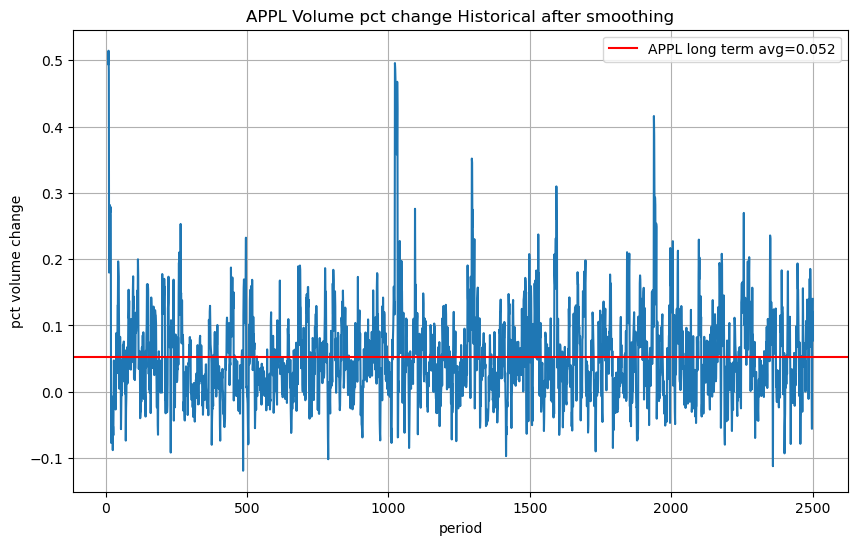

In [65]:
plt.figure(figsize=(10,6))
plt.plot(df_appl_hist_merged_roll['pct_change_Volume_appl'])
plt.axhline(0.05259, color='r',label='APPL long term avg=0.052')
plt.grid()
plt.legend(loc='best')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.title('APPL Volume pct change Historical after smoothing')
plt.show()

In [66]:
df_appl_hist_merged_roll['pct_change_Volume_appl'].mean()

0.05259855940342715

## 9. SELECTING THE INDIPENDENT VARIABLES
Based on the results obtained in section 5 by performing VIF and Correlation analysis, we select the indipendent variables that will be used to predict the target variable and discard the variables that are supposed to not contribute to the prediction of the pct change of Volume.  
The features Open, High, Low, Close, and VWAP are discarded for both TSLA and APPL.

### 9.1 TSLA Indipendnet variable selection

In [67]:
df_tsla_hist_merged_roll.dropna(inplace=True)

In [68]:
df_tsla_hist_merged_roll_f=df_tsla_hist_merged_roll.drop(['Open','High','Low','Close','VWAP_tsla'], axis = 1).reset_index().drop(columns=['index'])
df_tsla_hist_merged_roll_f['Id']=df_tsla_hist_merged_roll_f.index
df_tsla_hist_merged_roll_f

Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
0           1.389200   11045100.0         0.000000       1885.646008   
1           1.377867   11177550.0         0.000000       1888.396008   
2           1.368867   11013300.0         0.000000       1890.873010   
3           1.358733   12005700.0         0.000000       1891.916003   
4           1.339933   12501300.0         0.000000       1889.192004   
...              ...          ...              ...               ...   
3186      194.375002  135746050.0        -0.013434      12822.738086   
3187      193.875002  133053290.0        -0.056066      12858.602051   
3188      193.312003  131403900.0        -0.069168      12898.607031   
3189      192.596002  129370300.0        -0.030865      12931.943945   
3190      192.006001  131954520.0        -0.030030      12960.362012   

      Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
0      2.069850e+09     23.022                0.054048             -0.003667   
1      2.016453e+09     22.849                0.078988             -0.011333   
2      1.961483e+09     22.790                0.047436             -0.009000   
3      1.958903e+09     22.708                0.137898             -0.010133   
4      2.001497e+09     22.822                0.124756             -0.018800   
...             ...        ...                     ...                   ...   
3186   4.702981e+09     20.395                0.046903              1.152000   
3187   4.649870e+09     20.157                0.003212             -0.500000   
3188   4.589570e+09     19.839                0.011044             -0.562999   
3189   4.484104e+09     19.418                0.007668             -0.716000   
3190   4.481146e+09     19.141                0.041776             -0.590001   

          OBV_tsla   RSI_tsla  EMV_tsla  ATR_tsla    Id  
0    -6.601770e+07  57.500583  0.000613  0.086819     0  
1    -6.994785e+07  55.908102 -0.000123  0.082114     1  
2    -7.127565e+07  54.606542 -0.001014  0.078219     2  
3    -7.359585e+07  53.290087 -0.001844  0.074400     3  
4    -7.781325e+07  51.285659 -0.002988  0.071395     4  
...            ...        ...       ...       ...   ...  
3186  1.877270e+10  54.917432  3.055642  8.525787  3186  
3187  1.877348e+10  54.314307  3.924793  8.476073  3187  
3188  1.877592e+10  53.687692  3.871187  8.411930  3188  
3189  1.875154e+10  52.967639  4.020229  8.309930  3189  
3190  1.872459e+10  52.340403  4.171237  8.207859  3190  

[3191 rows x 13 columns]

In [69]:
df_tsla_roll_VIF = df_tsla_hist_merged_roll_f.drop(['pct_change_Volume_TSLA'], axis = 1)
# VIF dataframe
vif_data_tsla_roll = pd.DataFrame()
vif_data_tsla_roll["feature"] = df_tsla_roll_VIF.columns
# calculating VIF for each feature
vif_data_tsla_roll["VIF"] = [variance_inflation_factor(df_tsla_roll_VIF.values, i)
                          for i in range(len(df_tsla_roll_VIF.columns))]
  
vif_data_tsla_roll

feature         VIF
0         Adj Close_tsla   62.000777
1            Volume_tsla    6.226235
2        sent_score_tsla    1.287785
3       Adj Close_nasdaq  128.201416
4          Volume_nasdaq   44.591055
5              Vix_index   12.467562
6   Price_variation_tsla    1.320104
7               OBV_tsla   35.515721
8               RSI_tsla   10.830940
9               EMV_tsla    1.948265
10              ATR_tsla   26.205825
11                    Id   70.235626

### 9.2 APPL Indipendent variable selection

In [70]:
df_appl_hist_merged_roll.dropna(inplace=True)

In [71]:
df_appl_hist_merged_roll_f=df_appl_hist_merged_roll.drop(['Open','High','Low','Close','VWAP_appl'], axis = 1).reset_index().drop(columns=['index'])
df_appl_hist_merged_roll_f['Id']=df_appl_hist_merged_roll_f.index
df_appl_hist_merged_roll_f

sent_score_appl   Volume_appl  Adj Close_appl  Adj Close_nasdaq  \
0             0.40233  1.230278e+09        2.594827       1770.176013   
1             0.24499  1.464236e+09        2.640356       1776.930017   
2             0.38693  1.559192e+09        2.684316       1785.061011   
3             0.38885  1.496886e+09        2.724616       1793.201013   
4             0.22037  1.509306e+09        2.774544       1801.551013   
...               ...           ...             ...               ...   
2488          0.34737  1.489105e+08       25.859387       4797.908984   
2489          0.15882  1.306471e+08       25.953954       4810.208008   
2490          0.07416  1.278671e+08       26.028189       4820.714990   
2491         -0.01770  1.188084e+08       26.164129       4837.831983   
2492          0.02249  1.203676e+08       26.244748       4842.465967   

      Volume_nasdaq  Vix_index  pct_change_Volume_appl  Price_variation_appl  \
0      1.684007e+09     11.541                0.494006              0.034536   
1      1.780775e+09     11.552                0.514297              0.052857   
2      1.922782e+09     11.513                0.483064              0.051036   
3      2.018737e+09     11.464                0.179710              0.046786   
4      2.108939e+09     11.439                0.216631              0.057964   
...             ...        ...                     ...                   ...   
2488   2.108081e+09     13.394               -0.001255              0.008750   
2489   1.886213e+09     13.154               -0.055962              0.100000   
2490   1.820220e+09     13.052                0.121244              0.078500   
2491   1.762206e+09     12.894                0.076270              0.143750   
2492   1.751894e+09     12.890                0.139981              0.085250   

          OBV_appl   RSI_appl  EMV_appl  ATR_appl    Id  
0    -3.109656e+09  38.751052 -0.000252  0.093110     0  
1    -2.382145e+09  43.409632 -0.000215  0.095635     1  
2    -1.749591e+09  47.830071 -0.000171  0.097753     2  
3    -1.441882e+09  51.885199 -0.000127  0.098949     3  
4    -8.977774e+08  56.450360 -0.000082  0.100278     4  
...            ...        ...       ...       ...   ...  
2488  3.309200e+10  42.089375 -0.044908  0.574428  2488  
2489  3.313766e+10  44.075003 -0.038645  0.577214  2489  
2490  3.315878e+10  45.665255 -0.031600  0.577232  2490  
2491  3.318897e+10  47.811877 -0.024356  0.572357  2491  
2492  3.319178e+10  48.959250 -0.018225  0.566643  2492  

[2493 rows x 13 columns]

In [72]:
df_appl_roll_VIF = df_appl_hist_merged_roll_f.drop(['pct_change_Volume_appl'], axis = 1)
# VIF dataframe
vif_data_appl_roll = pd.DataFrame()
vif_data_appl_roll["feature"] = df_appl_roll_VIF.columns
# calculating VIF for each feature
vif_data_appl_roll["VIF"] = [variance_inflation_factor(df_appl_roll_VIF.values, i)
                          for i in range(len(df_appl_roll_VIF.columns))]
  
vif_data_appl_roll

feature         VIF
0        sent_score_appl    5.768173
1            Volume_appl   15.403021
2         Adj Close_appl  116.892915
3       Adj Close_nasdaq  189.781679
4          Volume_nasdaq   67.873768
5              Vix_index   14.930744
6   Price_variation_appl    1.475149
7               OBV_appl   25.150716
8               RSI_appl   35.537163
9               EMV_appl    1.595194
10              ATR_appl   24.287914
11                    Id   94.952956

## 10. METHODOLOGY OF THE WORK

The goal of this present work is to predict the daily percentage change of volume traded of TESLA and APPL stock. The percentage change of the volume is regarded as the target dependent variable to be predicted. The indipendent variables considered are some of the daily market data related to the assets such as: Volume, Adjusted close price of stock, Adjusted close price of stock index and several market indicators. In addition to them, the daily sentiment score computed on the ground of the stock news will be factored in as well.  
The volume percentage change predicition will be performed by both not factoring and factoring in the sentiment score for each of the predictive model use. That way, the impact of introducing sentiment information on prediction of volume change will be assessed.

### 10.1 PREDICTIVE MODEL

In the present work, the following predictive model will be used:  
- Moving Average model and Autoregressive model, which are regarded as a benchmark model,  
- Linear Regression model, which is a supervised machine learning model,  
- Support Vector Regressor Model, which is a supervised machine learning model,  
- Random Forest Regressor model, which is a supervised machine learning model,  
- Long Short-Term Memory Networks model, which is a deep learning model

### 10.2 MODEL EVALUATION METRICS
In order to assess and compare the performance of the predictive models, the following two metrics are used: Root Mean Square Error, Mean Absolute Error and Mean Directional Accuracy (MDA).
Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) are two common metrics used to measure the accuracy of a predictive model. Both metrics quantify the difference between the actual (observed) values and the predicted (forecasted) values, but they do so in slightly different ways.  
RMSE is the square root of the average of the squared differences between the predicted and actual values. MAE is the average of the absolute differences between the predicted and actual values.  
- RMSE gives more weight to larger errors due to the squaring operation. Therefore, it may be more sensitive to outliers (more sensitive to outliers).  
- Unlike RMSE, MAE treats all errors equally, regardless of their size. Therefore, it is less sensitive to outliers.  

MDA is a measure of the prediction accuracy of a forecasting method in statistics. It compares the forecast direction (upward or downward) to the actual realized direction. It is a popular metric for forecasting performance in economics and finance. MDA is used where we are often interested only in the directional movement of variables of interest.

In [73]:
def mda(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda

## 11. RESULTS

### 11.1 MOVING AVERAGE
MA is a basic time series forecasting techinque and allow to establish the underlying trend in a set of data. Moving Average (MA) is a statistical technique used in time series analysis to estimate the underlying trend or pattern in the data by averaging the values of a certain number of preceding periods. The MA method is based on the idea that the current value of a time series is a function of the average of the values of previous periods. For the present work the lenght of the time window is set to 30.


In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 11.1.1 TSLA Moving Average

In [75]:
train_len_ma_tsla = int(0.80*len(df_tsla_hist_merged_roll_f))
train_ma_tsla = df_tsla_hist_merged_roll_f[0:train_len_ma_tsla].reset_index() # first 120 months as training set
test_ma_tsla = df_tsla_hist_merged_roll_f[train_len_ma_tsla:].reset_index()

train_ma_tsla=train_ma_tsla[['index','pct_change_Volume_TSLA']]
test_ma_tsla=test_ma_tsla[['index','pct_change_Volume_TSLA']]




y_hat_sma_tsla = pd.DataFrame(df_tsla_hist_merged_roll_f['pct_change_Volume_TSLA'].copy())
ma_window_tsla = 30
y_hat_sma_tsla['sma_forecast']=df_tsla_hist_merged_roll_f['pct_change_Volume_TSLA'].rolling(ma_window_tsla).mean()
y_hat_sma_tsla=y_hat_sma_tsla.reset_index().drop(columns=['index'])
y_hat_sma_tsla['sma_forecast'][train_len_ma_tsla:] = y_hat_sma_tsla['sma_forecast'][train_len_ma_tsla:].shift(1,axis=0)

C:\Users\loren\AppData\Local\Temp\ipykernel_18596\1672966472.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  y_hat_sma_tsla['sma_forecast'][train_len_ma_tsla:] = y_hat_sma_tsla['sma_forecast'][train_len_ma_tsla:].shift(1,axis=0)


In [76]:
y_hat_sma_tsla_test=y_hat_sma_tsla[train_len_ma_tsla:].reset_index()
y_hat_sma_tsla_test

index  pct_change_Volume_TSLA  sma_forecast
0     2552                0.038896           NaN
1     2553                0.037008      0.083982
2     2554               -0.025747      0.078479
3     2555               -0.041939      0.074171
4     2556               -0.020355      0.066364
..     ...                     ...           ...
634   3186                0.046903     -0.004200
635   3187                0.003212     -0.002791
636   3188                0.011044     -0.002979
637   3189                0.007668     -0.003127
638   3190                0.041776     -0.002693

[639 rows x 3 columns]

In [77]:
y_hat_sma_tsla_test['pct_change_Volume_TSLA'].mean()

0.041583718869036605

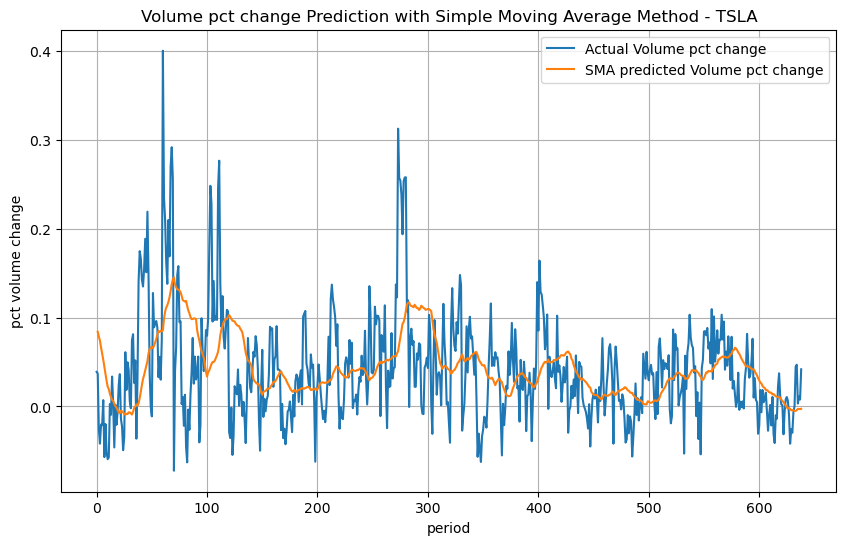

In [78]:
plt.figure(figsize=(10,6))
plt.grid()
#plt.plot(train_ma_tsla['index'],train_ma_tsla['pct_change_Volume_TSLA'], label='Train')
plt.plot(y_hat_sma_tsla_test['pct_change_Volume_TSLA'], label='Actual Volume pct change')
plt.plot(y_hat_sma_tsla_test['sma_forecast'], label='SMA predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Simple Moving Average Method - TSLA')
plt.savefig(fig_dir+'SMA_TSLA.png', transparent=False)
plt.show()

In [79]:
mae_ma = mean_absolute_error(y_hat_sma_tsla[train_len_ma_tsla+1:]['pct_change_Volume_TSLA'], y_hat_sma_tsla[train_len_ma_tsla+1:]['sma_forecast'])
rmse_ma = np.sqrt(mean_squared_error(y_hat_sma_tsla[train_len_ma_tsla+1:]['pct_change_Volume_TSLA'], y_hat_sma_tsla[train_len_ma_tsla+1:]['sma_forecast']))
mda_ma= mda(y_hat_sma_tsla[train_len_ma_tsla+1:]['pct_change_Volume_TSLA'],y_hat_sma_tsla[train_len_ma_tsla+1:]['sma_forecast'])
print('Mean Absolute Error:', mae_ma)
print('Root Mean Squared Error:', rmse_ma)
print('Mean Directional Accuracy:', mda_ma)

Mean Absolute Error: 0.044186473005314454
Root Mean Squared Error: 0.059748465668559105
Mean Directional Accuracy: 0.40345368916797486


### 11.1.2 APPL Moving Average

In [80]:
train_len_ma_appl = int(0.80*len(df_appl_hist_merged_roll_f))
train_ma_appl = df_appl_hist_merged_roll_f[0:train_len_ma_appl].reset_index() # first 120 months as training set
test_ma_appl = df_appl_hist_merged_roll_f[train_len_ma_appl:].reset_index()

train_ma_appl=train_ma_appl[['index','pct_change_Volume_appl']]
test_ma_appl=test_ma_appl[['index','pct_change_Volume_appl']]




y_hat_sma_appl = pd.DataFrame(df_appl_hist_merged_roll_f['pct_change_Volume_appl'].copy())
ma_window_appl = 30
y_hat_sma_appl['sma_forecast']=df_appl_hist_merged_roll_f['pct_change_Volume_appl'].rolling(ma_window_appl).mean()
y_hat_sma_appl=y_hat_sma_appl.reset_index().drop(columns=['index'])
y_hat_sma_appl['sma_forecast'][train_len_ma_appl:] = y_hat_sma_appl['sma_forecast'][train_len_ma_appl:].shift(1,axis=0)

C:\Users\loren\AppData\Local\Temp\ipykernel_18596\345418533.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  y_hat_sma_appl['sma_forecast'][train_len_ma_appl:] = y_hat_sma_appl['sma_forecast'][train_len_ma_appl:].shift(1,axis=0)


In [81]:
y_hat_sma_appl_test=y_hat_sma_appl[train_len_ma_appl:].reset_index()
y_hat_sma_appl_test

index  pct_change_Volume_appl  sma_forecast
0     1994                0.189969           NaN
1     1995                0.118911      0.049873
2     1996                0.152590      0.053306
3     1997                0.227051      0.059490
4     1998                0.009260      0.067967
..     ...                     ...           ...
494   2488               -0.001255      0.089263
495   2489               -0.055962      0.086080
496   2490                0.121244      0.081988
497   2491                0.076270      0.083805
498   2492                0.139981      0.083902

[499 rows x 3 columns]

In [82]:
y_hat_sma_appl_test['pct_change_Volume_appl'].mean()

0.05483925988491841

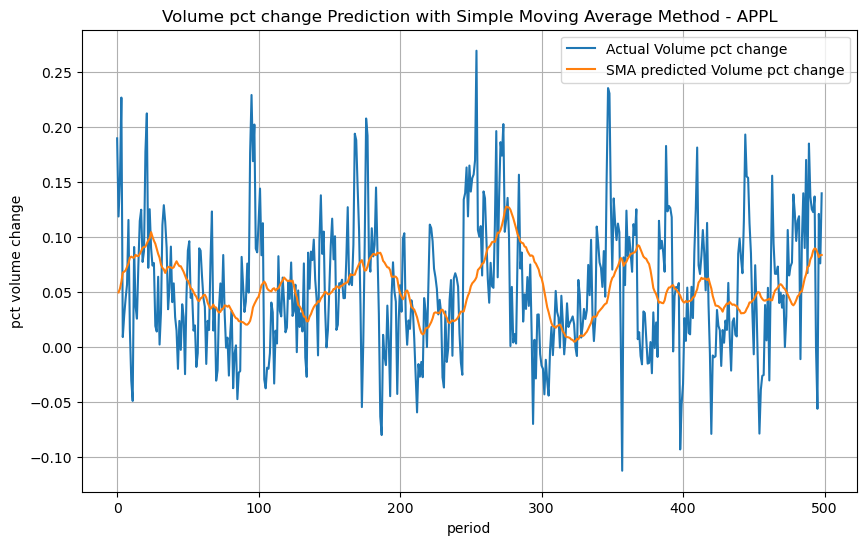

In [83]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(y_hat_sma_appl_test['pct_change_Volume_appl'], label='Actual Volume pct change')
plt.plot(y_hat_sma_appl_test['sma_forecast'], label='SMA predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Simple Moving Average Method - APPL')
plt.savefig(fig_dir+'SMA_APPL.png', transparent=False)
plt.show()

In [84]:
# plt.figure(figsize=(20,5))
# plt.grid()
# plt.plot(train_ma_appl['index'],train_ma_appl['pct_change_Volume_appl'], label='Train')
# plt.plot(test_ma_appl['index'],test_ma_appl['pct_change_Volume_appl'], label='Test')
# plt.plot(y_hat_sma_appl['sma_forecast'], label='Simple moving average forecast')
# plt.legend(loc='best')
# plt.title('Simple Moving Average Method')
# plt.show()

In [85]:
mae_ma_appl = mean_absolute_error(y_hat_sma_appl[train_len_ma_appl+1:]['pct_change_Volume_appl'], y_hat_sma_appl[train_len_ma_appl+1:]['sma_forecast'])
rmse_ma_appl = np.sqrt(mean_squared_error(y_hat_sma_appl[train_len_ma_appl+1:]['pct_change_Volume_appl'], y_hat_sma_appl[train_len_ma_appl+1:]['sma_forecast']))
mad_ma_appl=mda(y_hat_sma_appl[train_len_ma_appl+1:]['pct_change_Volume_appl'],y_hat_sma_appl[train_len_ma_appl+1:]['sma_forecast'])
print('Mean Absolute Error:', mae_ma_appl)
print('Root Mean Squared Error:', rmse_ma_appl)
print('Mean Directional Accuracy', mad_ma_appl)

Mean Absolute Error: 0.047223012365764025
Root Mean Squared Error: 0.060362602477143125
Mean Directional Accuracy 0.4104627766599598


### 11.2 AUTOREGRESSIVE MODEL (AR)
Autoregressive (AR) models is common method in the field of time series forecasting. They assume that the current value of a time series can be expressed as a linear combination of its previous values plus a stochastic error term. This model is particularly powerful when dealing with time series data where current observations are correlated with past observations.  
Stationarity is a fundamental assumption in many time series models, including AR models.

### 11.2.1 TSLA AUTOREGRESSIVE MODEL (AR)

In [86]:
df_tsla_hist_ar=df_tsla_hist_merged_roll_f.copy()

In [87]:
# Split the data into training and testing sets
train_size_ar = int(0.8 * len(df_tsla_hist_ar))
train_data_ar = df_tsla_hist_ar[:train_size_ar].reset_index().drop(columns=['index'])
test_data_ar = df_tsla_hist_ar[train_size_ar:].reset_index().drop(columns=['index'])

# Define the input features (lag features) and target variable
 
y_train_ar = train_data_ar['pct_change_Volume_TSLA']
 
y_test_ar = test_data_ar['pct_change_Volume_TSLA']

By looking at the autocorrelation function (ACF) plots of the differenced serie, it might possible to identify the most suitable order of AR.  
ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Simply stated: ACF explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. 

<Figure size 1000x600 with 0 Axes>

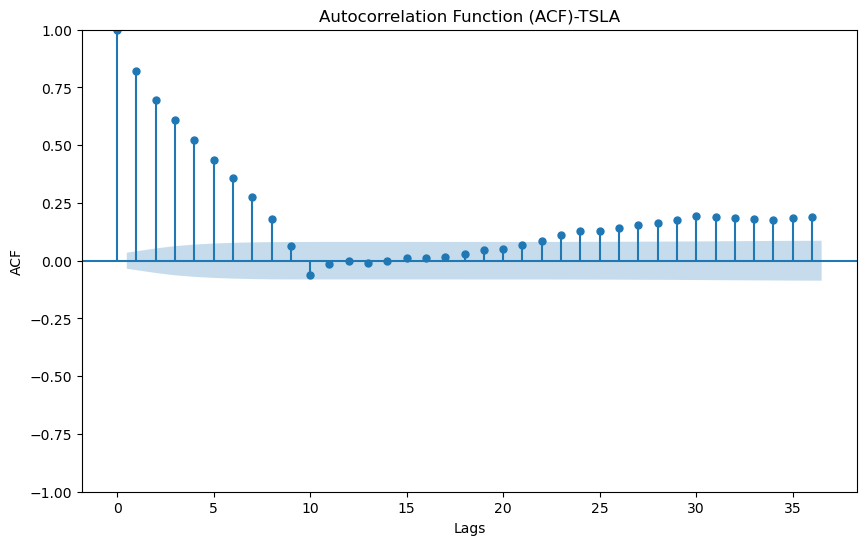

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

series = df_tsla_hist_ar['pct_change_Volume_TSLA']


plt.rc("figure", figsize=(10,6))
plt.figure(figsize=(10,6))
plot_acf(series)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)-TSLA')
plt.show()

<Figure size 1000x600 with 0 Axes>

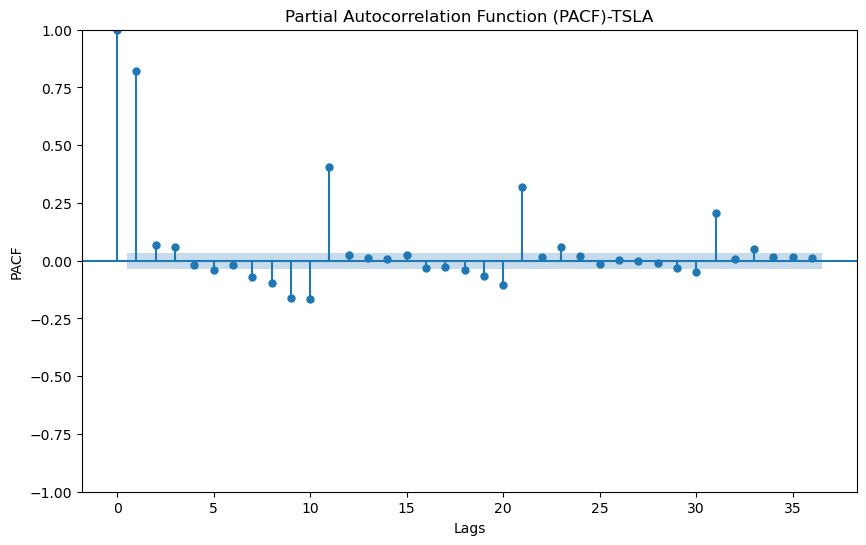

In [89]:
# Plot PACF
plt.rc("figure", figsize=(10,6))
plt.figure(figsize=(10,6))
plot_pacf(series)  # Change lags according to your data
plt.title('Partial Autocorrelation Function (PACF)-TSLA')
plt.xlabel('Lags')
plt.ylabel('PACF')
#plt.grid(True)
plt.show()

Looking at the ACF plot, a strong correlation for the first two term, which suggest an AR(2) model.

In [90]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg

In [91]:
# Create and train the autoregressive model
lag_order = 5 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train_ar, lags=lag_order)
ar_results = ar_model.fit()

In [92]:
# Make predictions on the test set
y_pred_ar = ar_results.predict(start=len(train_data_ar), end=len(train_data_ar) + len(test_data_ar) - 1, dynamic=False).reset_index()

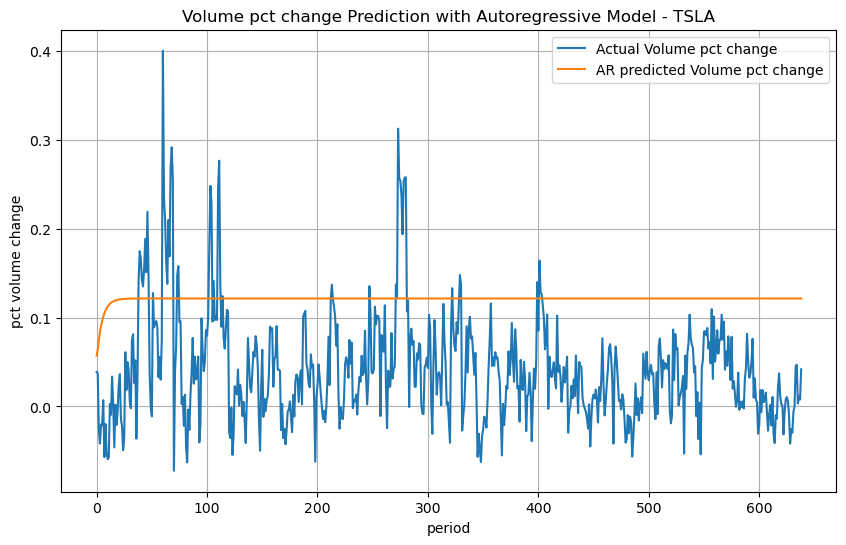

In [93]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(y_test_ar, label='Actual Volume pct change')
plt.plot(y_pred_ar[0], label='AR predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Autoregressive Model - TSLA')
plt.savefig(fig_dir+'AR_TSLA.png', transparent=False)
plt.show()

In [94]:
# Calculate MAE and RMSE
mae_ar = mean_absolute_error(y_test_ar, y_pred_ar[0])
rmse_ar = np.sqrt(mean_squared_error(y_test_ar, y_pred_ar[0]))
mad_ar=mda(y_test_ar,y_pred_ar[0])
print('Mean Absolute Error:', mae_ar)
print('Root Mean Squared Error:', rmse_ar)
print('Mean Directional Accuracy:', mad_ar)

Mean Absolute Error: 0.09004627119475715
Root Mean Squared Error: 0.09989496462174735
Mean Directional Accuracy: 0.3996865203761755


### 11.2.2 APPL AUTOREGRESSIVE MODEL (AR)

In [95]:
df_appl_hist_ar=df_appl_hist_merged_roll_f.copy()

In [96]:
# Split the data into training and testing sets
train_appl_size_ar = int(0.8 * len(df_appl_hist_ar))
train_appl_data_ar = df_appl_hist_ar[:train_appl_size_ar].reset_index().drop(columns=['index'])
test_appl_data_ar = df_appl_hist_ar[train_appl_size_ar:].reset_index().drop(columns=['index'])

# Define the input features (lag features) and target variable
 
y_train_appl_ar = train_appl_data_ar['pct_change_Volume_appl']
 
y_test_appl_ar = test_appl_data_ar['pct_change_Volume_appl']

<Figure size 1000x600 with 0 Axes>

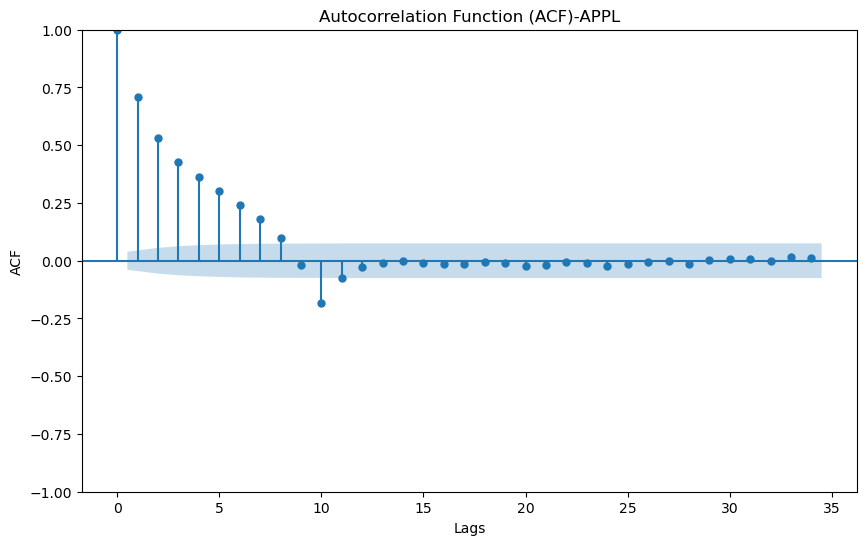

In [97]:
series_appl = df_appl_hist_ar['pct_change_Volume_appl']

plt.rc("figure", figsize=(10,6))
plt.figure(figsize=(10,6))
plot_acf(series_appl)
plt.title('Autocorrelation Function (ACF)-APPL')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

<Figure size 1000x600 with 0 Axes>

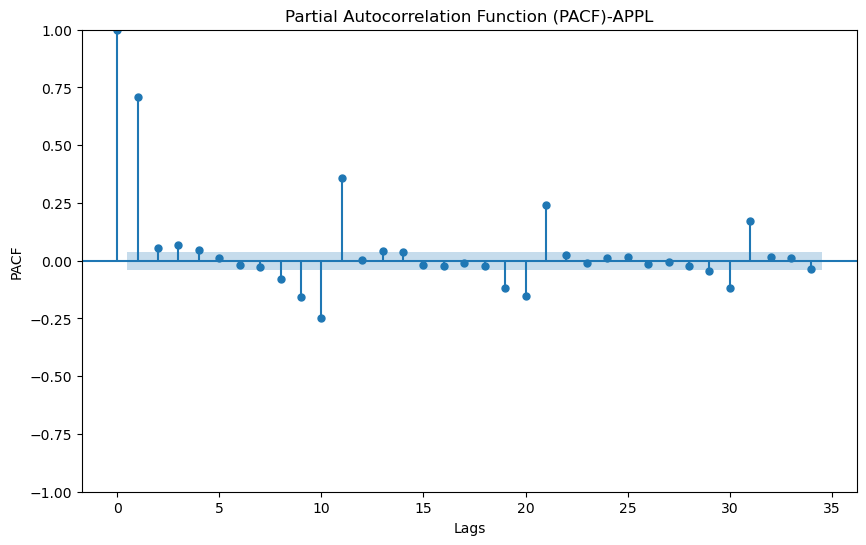

In [98]:
# Plot PACF
plt.rc("figure", figsize=(10,6))
plt.figure(figsize=(10,6))
plot_pacf(series_appl)  # Change lags according to your data
plt.title('Partial Autocorrelation Function (PACF)-APPL')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [99]:
# Create and train the autoregressive model
lag_order_appl = 5 # Adjust this based on the ACF plot
ar_model_appl = AutoReg(y_train_appl_ar, lags=lag_order_appl)
ar_results_appl = ar_model_appl.fit()

In [100]:
# Make predictions on the test set
y_pred_appl_ar = ar_results_appl.predict(start=len(train_appl_data_ar), end=len(train_appl_data_ar) + len(test_appl_data_ar) - 1, dynamic=False).reset_index()

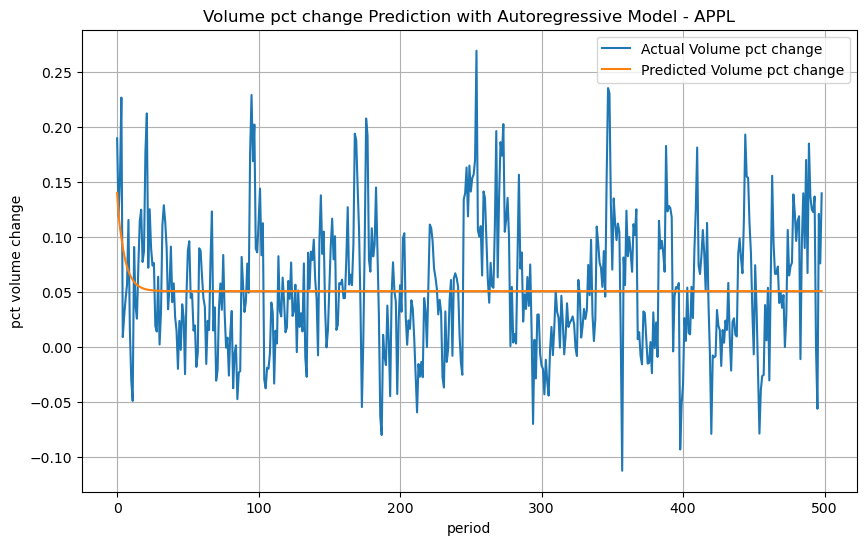

In [101]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(y_test_appl_ar, label='Actual Volume pct change')
plt.plot(y_pred_appl_ar[0], label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Autoregressive Model - APPL')
plt.savefig(fig_dir+'AR_APPL.png', transparent=False)
plt.show()

In [102]:
# Calculate MAE and RMSE
mae_ar_appl = mean_absolute_error(y_test_appl_ar, y_pred_appl_ar[0])
rmse_ar_appl = np.sqrt(mean_squared_error(y_test_appl_ar, y_pred_appl_ar[0]))
mad_ar_appl=mda(y_test_appl_ar,y_pred_appl_ar[0])
print('Mean Absolute Error:', mae_ar_appl)
print('Root Mean Squared Error:', rmse_ar_appl)
print('Mean Directional Accuracy:', mad_ar_appl)

Mean Absolute Error: 0.04770967440725778
Root Mean Squared Error: 0.060040678819693896
Mean Directional Accuracy: 0.18473895582329317


### 11.3 LINERA REGRESSION MODEL
Linear Regression is a Supervised Machine Learning algorithm that is used to solve Regression problems. Regression models are used to predict a continuous output based on some other factors. In the present work a multiple linear regression is used, i.e. it uses two or more independent variables (Open, Close, High,etc..) to predict the outcome of a dependent variable (volume pct change). 

Assumptions for Linear Regression:  
- the independent and dependent variables must follow a linear relationship.  
- Homoscedasticity, which states that the variance of the residual errors must be constant.  
- No Multicollinearity. Multicollinearity means there is a correlation between the independent variables. So in Linear Regression, the independent variables must not be correlated with each other.

### 11.3.1 TSLA LINEAR REGRESSION MODEL

#### 11.3.1.1 TSLA LR1 (No general News and no tsla news)

In [103]:
df_tsla_hist_lr1=df_tsla_hist_merged_roll_f.copy()
df_tsla_hist_lr1.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'sent_score_tsla', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_TSLA',
       'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla', 'ATR_tsla',
       'Id'],
      dtype='object')

In [104]:
# Split the data into training and testing sets
train_size_lr1 = int(0.8 * len(df_tsla_hist_lr1))
train_data_lr1 = df_tsla_hist_lr1[:train_size_lr1].reset_index().drop(columns=['index'])
test_data_lr1 = df_tsla_hist_lr1[train_size_lr1:].reset_index().drop(columns=['index'])

X_train_lr1, Y_train_lr1= train_data_lr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), train_data_lr1['pct_change_Volume_TSLA']
X_test_lr1, Y_test_lr1= test_data_lr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), test_data_lr1['pct_change_Volume_TSLA']

In [105]:
#Import the LR package
from sklearn.linear_model import LinearRegression

#initializing the multiple LR model and model fitting
lr1 = LinearRegression()
lr1.fit(X_train_lr1, Y_train_lr1)

#printing the coeffienct and the intercept of the mdoel
print('LR Coefficients: \n', lr1.coef_)
print('LR Intercept: \n', lr1.intercept_)

LR Coefficients: 
 [ 5.34208676e-03  4.77449518e-10 -1.84725741e-05  2.49229637e-11
 -2.75190806e-03 -1.04506748e-03 -3.04546769e-11  1.47238970e-04
 -1.53799599e-02 -4.40156112e-02]
LR Intercept: 
 0.20948375088280974


In [106]:
# Make predictions on the test set
Y_test_pred_lr1 = lr1.predict(X_test_lr1)

In [107]:
#from yellowbrick.regressor import ResidualsPlot

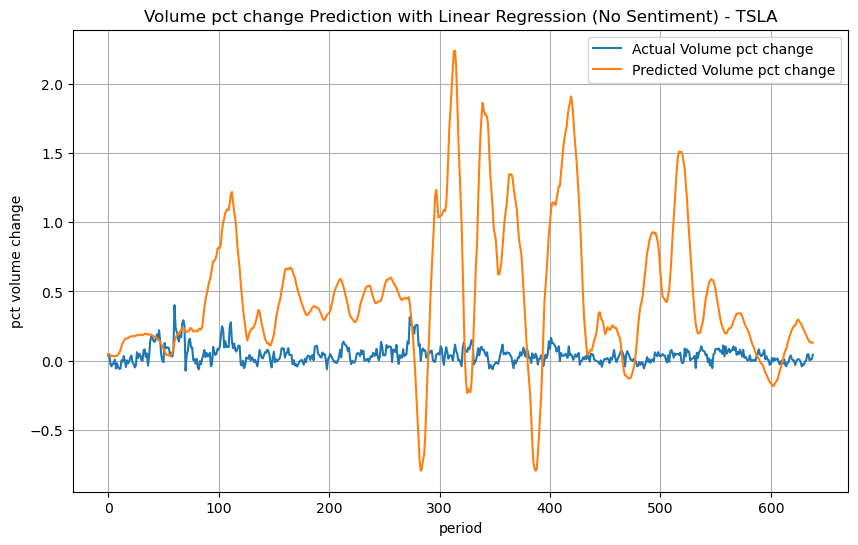

In [108]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_lr1, label='Actual Volume pct change')
plt.plot( Y_test_pred_lr1, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Linear Regression (No Sentiment) - TSLA')
plt.savefig(fig_dir+'LR_TSLA_NoSent.png', transparent=False)
plt.show()

In [109]:
# Calculate MAE and RMSE
from sklearn import metrics
mae_lr1=metrics.mean_absolute_error(Y_test_lr1,Y_test_pred_lr1)
rmse_lr1=np.sqrt(metrics.mean_squared_error(Y_test_lr1,Y_test_pred_lr1))
mad_lr1=mda(Y_test_lr1,Y_test_pred_lr1)
print("Test MAE: ", mae_lr1)
print("Test RMSE: ", rmse_lr1)
print("Test MDA: ", mad_lr1)

Test MAE:  0.4918534121172058
Test RMSE:  0.6636804304253178
Test MDA:  0.5313479623824452


In [110]:
# visualizer = ResidualsPlot(lr1)

# plt.figure(figsize=(10, 6))
# visualizer.fit(X_train_lr1, Y_train_lr1)  # Fit the training data to the visualizer
# visualizer.score(X_test_lr1, Y_test_lr1)  # Evaluate the model on the test data
# plt.savefig(fig_dir+'LR_RES_TSLA_NoSent.png', transparent=False)
# visualizer.show()  

In [ ]:
# plt.title('Volume pct change Prediction with Linear Regression (No Sentiment) - TSLA')
# plt.savefig(fig_dir+'LR_TSLA_NoSent.png', transparent=False)
# plt.show()

In [111]:
X_train_lr1.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla',
       'ATR_tsla'],
      dtype='object')

In [112]:
lr1.coef_

array([ 5.34208676e-03,  4.77449518e-10, -1.84725741e-05,  2.49229637e-11,
       -2.75190806e-03, -1.04506748e-03, -3.04546769e-11,  1.47238970e-04,
       -1.53799599e-02, -4.40156112e-02])

In [113]:
importance_lr1

NameError: name 'importance_lr1' is not defined

In [114]:
features=['ATR_tsla','EMV_tsla','Adj Close_tsla','Vix_index', 'Price_variation_tsla', 
          'RSI_tsla', 'Adj Close_nasdaq','Volume_tsla','OBV_tsla','Volume_nasdaq']

features

['ATR_tsla',
 'EMV_tsla',
 'Adj Close_tsla',
 'Vix_index',
 'Price_variation_tsla',
 'RSI_tsla',
 'Adj Close_nasdaq',
 'Volume_tsla',
 'OBV_tsla',
 'Volume_nasdaq']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Feature: 0, Score: 0.04402
Feature: 1, Score: 0.01538
Feature: 2, Score: 0.00534
Feature: 3, Score: 0.00275
Feature: 4, Score: 0.00105
Feature: 5, Score: 0.00015
Feature: 6, Score: 0.00002
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000


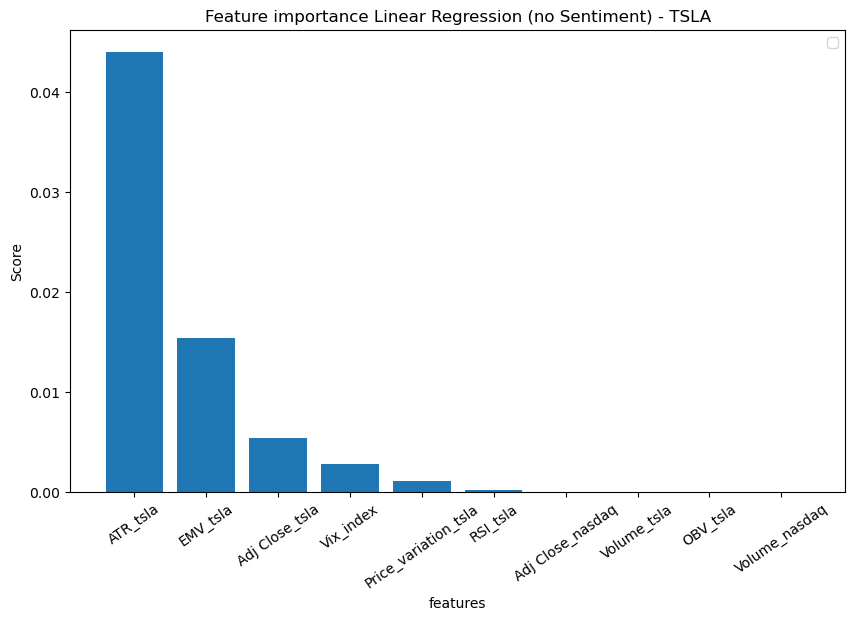

In [116]:
#Computing the features importance
# get importance
importance_lr1 = np.abs(lr1.coef_)
importance_lr1[::-1].sort()

# summarize feature importance
for i,v in enumerate(importance_lr1):
 print('Feature: %0d, Score: %.5f' % (i,v))



# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features, importance_lr1)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Linear Regression (no Sentiment) - TSLA')
plt.xticks(rotation = 35)
plt.savefig(fig_dir+'LR_TSLA_FI_NoSent.png', transparent=False)
plt.show()

#### 11.3.1.2 TSLA LR2 (tsla news factored in) 

In [117]:
df_tsla_hist_lr2=df_tsla_hist_merged_roll_f.copy()

In [118]:
# Split the data into training and testing sets
train_size_lr2 = int(0.8 * len(df_tsla_hist_lr2))
train_data_lr2 = df_tsla_hist_lr1[:train_size_lr2].reset_index().drop(columns=['index'])
test_data_lr2 = df_tsla_hist_lr1[train_size_lr2:].reset_index().drop(columns=['index'])

X_train_lr2, Y_train_lr2= train_data_lr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), train_data_lr1['pct_change_Volume_TSLA']
X_test_lr2, Y_test_lr2= test_data_lr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), test_data_lr1['pct_change_Volume_TSLA']

In [119]:
#initializing the multiple LR model and model fitting
lr2 = LinearRegression()
lr2.fit(X_train_lr2, Y_train_lr2)

#printing the coeffienct and the intercept of the mdoel
print('LR Coefficients: \n', lr2.coef_)
print('LR Intercept: \n', lr2.intercept_)

LR Coefficients: 
 [ 5.55510036e-03  4.58465022e-10  1.81883267e-01 -1.82504771e-05
  2.55962756e-11 -2.74775012e-03 -5.70039629e-03 -3.02690359e-11
  1.79042500e-05 -1.69846976e-02 -4.86931373e-02]
LR Intercept: 
 0.21327649196299983


In [120]:
# Make predictions on the test set
Y_test_pred_lr2 = lr2.predict(X_test_lr2)

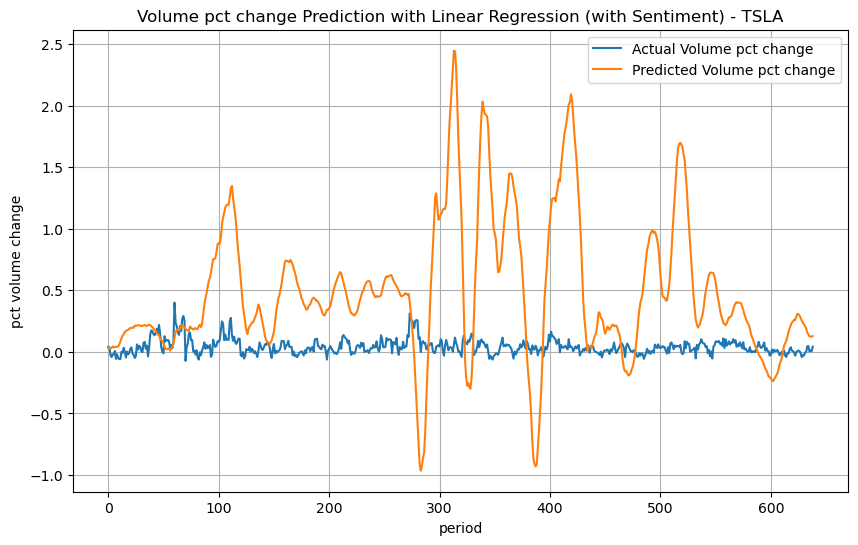

In [121]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_lr2, label='Actual Volume pct change')
plt.plot( Y_test_pred_lr2, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Linear Regression (with Sentiment) - TSLA')
plt.savefig(fig_dir+'LR_TSLA_Sent.png', transparent=False)
plt.show()

In [122]:
# Calculate MAE and RMSE
mae_lr2=metrics.mean_absolute_error(Y_test_lr2,Y_test_pred_lr2)
rmse_lr2=np.sqrt(metrics.mean_squared_error(Y_test_lr2,Y_test_pred_lr2))
mad_lr2=mda(Y_test_lr2,Y_test_pred_lr2)
print("Test MAE: ", mae_lr2)
print("Test RMSE: ", rmse_lr2)
print("Test MDA: ", mad_lr2)

Test MAE:  0.5324885153573062
Test RMSE:  0.7224459376718523
Test MDA:  0.5172413793103449


In [123]:
# visualizer = ResidualsPlot(lr2)

# plt.figure(figsize=(10, 6))
# visualizer.fit(X_train_lr2, Y_train_lr2)  # Fit the training data to the visualizer
# visualizer.score(X_test_lr2, Y_test_lr2)  # Evaluate the model on the test data
# #plt.savefig(fig_dir+'LR_RES_TSLA_NoSent.png', transparent=False)
# visualizer.show()  

In [124]:
X_train_lr2.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'sent_score_tsla', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'Price_variation_tsla', 'OBV_tsla',
       'RSI_tsla', 'EMV_tsla', 'ATR_tsla'],
      dtype='object')

In [125]:
lr2.coef_

array([ 5.55510036e-03,  4.58465022e-10,  1.81883267e-01, -1.82504771e-05,
        2.55962756e-11, -2.74775012e-03, -5.70039629e-03, -3.02690359e-11,
        1.79042500e-05, -1.69846976e-02, -4.86931373e-02])

In [126]:
features_lr2=['sent_score_tsla','ATR_tsla','EMV_tsla','Price_variation_tsla','Adj Close_tsla','Vix_index',  
           'Adj Close_nasdaq','RSI_tsla','Volume_tsla','OBV_tsla','Volume_nasdaq']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Feature: 0, Score: 0.18188
Feature: 1, Score: 0.04869
Feature: 2, Score: 0.01698
Feature: 3, Score: 0.00570
Feature: 4, Score: 0.00556
Feature: 5, Score: 0.00275
Feature: 6, Score: 0.00002
Feature: 7, Score: 0.00002
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000


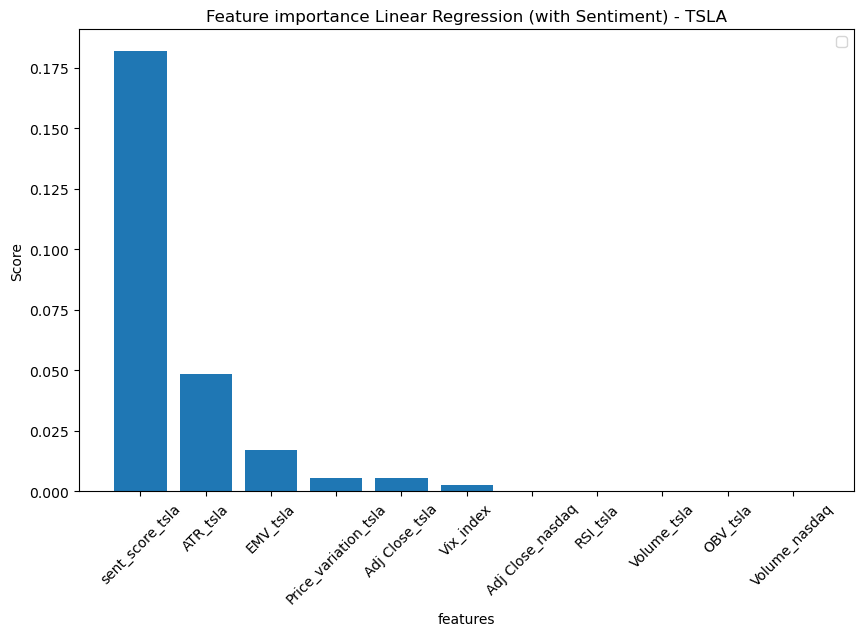

In [127]:
#Computing the features importance
# get importance
importance_lr2 = np.abs(lr2.coef_)
importance_lr2[::-1].sort()

# summarize feature importance
for i,v in enumerate(importance_lr2):
 print('Feature: %0d, Score: %.5f' % (i,v))




# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_lr2, importance_lr2)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Linear Regression (with Sentiment) - TSLA')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'LR_TSLA_FI_Sent.png', transparent=False)
plt.show()

### 11.3.2 APPL LINEAR REGRESSION MODEL

#### 11.3.2.1 APPL LR1 (No general News and no appl news)

In [128]:
df_appl_hist_lr1=df_appl_hist_merged_roll_f.copy()
df_appl_hist_lr1.columns

Index(['sent_score_appl', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_appl',
       'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl', 'ATR_appl',
       'Id'],
      dtype='object')

In [130]:
# Split the data into training and testing sets
train_appl_size_lr1 = int(0.8 * len(df_appl_hist_lr1))
train_appl_data_lr1 = df_appl_hist_lr1[:train_appl_size_lr1].reset_index().drop(columns=['index'])
test_appl_data_lr1 = df_appl_hist_lr1[train_appl_size_lr1:].reset_index().drop(columns=['index'])

X_train_appl_lr1, Y_train_appl_lr1= train_appl_data_lr1.drop(columns=['Id','pct_change_Volume_appl','sent_score_appl'], axis=1), train_appl_data_lr1['pct_change_Volume_appl']
X_test_appl_lr1, Y_test_appl_lr1= test_appl_data_lr1.drop(columns=['Id','pct_change_Volume_appl','sent_score_appl'], axis=1), test_appl_data_lr1['pct_change_Volume_appl']

In [131]:
#initializing the multiple LR model and model fitting
lr1_appl = LinearRegression()
lr1_appl.fit(X_train_appl_lr1, Y_train_appl_lr1)

#printing the coeffienct and the intercept of the mdoel
print('LR Coefficients: \n', lr1_appl.coef_)
print('LR Intercept: \n', lr1_appl.intercept_)

LR Coefficients: 
 [ 1.13658462e-10  8.70948870e-03 -4.55836615e-06 -1.66610480e-11
 -4.01860695e-04 -6.91522696e-02  7.57294844e-13  2.21289590e-04
 -1.22098582e+00 -3.46024382e-01]
LR Intercept: 
 0.00033878730111561173


In [132]:
# Make predictions on the test set
Y_test_appl_pred_lr1 = lr1_appl.predict(X_test_appl_lr1)

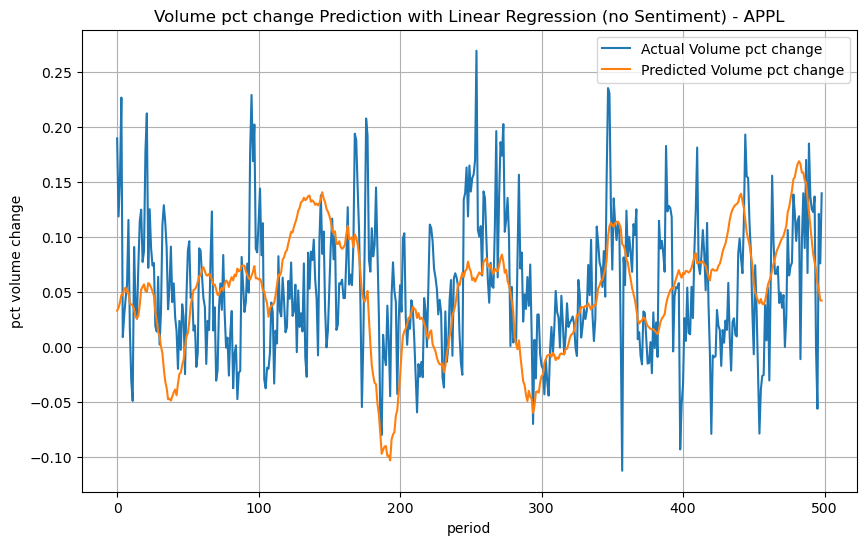

In [133]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_lr1, label='Actual Volume pct change')
plt.plot(Y_test_appl_pred_lr1, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Linear Regression (no Sentiment) - APPL')
plt.savefig(fig_dir+'LR_APPL_NoSent.png', transparent=False)
plt.show()

In [134]:
# Calculate MAE and RMSE
mae_lr1_appl=metrics.mean_absolute_error(Y_test_appl_lr1,Y_test_appl_pred_lr1)
rmse_lr1_appl=np.sqrt(metrics.mean_squared_error(Y_test_appl_lr1,Y_test_appl_pred_lr1))
mad_lr1_appl=mda(Y_test_appl_lr1,Y_test_appl_pred_lr1)
print("Test MAE: ", mae_lr1_appl)
print("Test RMSE: ", rmse_lr1_appl)
print("Test MDA: ", mad_lr1_appl)

Test MAE:  0.05379884559752634
Test RMSE:  0.06734531746645274
Test MDA:  0.5321285140562249


In [135]:
# visualizer = ResidualsPlot(lr1_appl)
# plt.figure(figsize=(10, 6))
# visualizer.fit(X_train_appl_lr1, Y_train_appl_lr1)  # Fit the training data to the visualizer
# visualizer.score(X_test_appl_lr1, Y_test_appl_lr1)  # Evaluate the model on the test data
# plt.savefig(fig_dir+'LR_RES_APPL_NoSent.png', transparent=False)
# visualizer.show()  

In [136]:
X_train_appl_lr1.columns

Index(['Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl',
       'ATR_appl'],
      dtype='object')

In [137]:
lr1_appl.coef_

array([ 1.13658462e-10,  8.70948870e-03, -4.55836615e-06, -1.66610480e-11,
       -4.01860695e-04, -6.91522696e-02,  7.57294844e-13,  2.21289590e-04,
       -1.22098582e+00, -3.46024382e-01])

In [138]:
features_lr1_appl=['EMV_appl','ATR_appl','Price_variation_appl','Adj Close_appl',
                   'Vix_index', 'RSI_appl','Adj Close_nasdaq','Volume_appl',
                   'Volume_nasdaq','OBV_appl']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Feature: 0, Score: 1.22099
Feature: 1, Score: 0.34602
Feature: 2, Score: 0.06915
Feature: 3, Score: 0.00871
Feature: 4, Score: 0.00040
Feature: 5, Score: 0.00022
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000


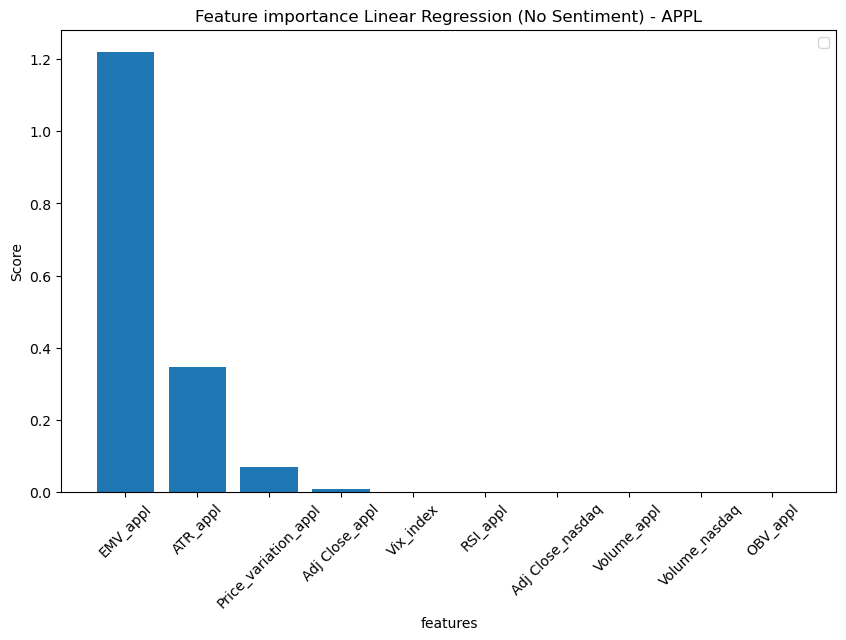

In [139]:
#Computing the features importance
# get importance
importance_lr1_appl = np.abs(lr1_appl.coef_)
importance_lr1_appl[::-1].sort()

# summarize feature importance
for i,v in enumerate(importance_lr1_appl):
 print('Feature: %0d, Score: %.5f' % (i,v))




# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_lr1_appl, importance_lr1_appl)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Linear Regression (No Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'LR_APPL_FI_NoSent.png', transparent=False)
plt.show()

#### 11.3.2.2 APPL LR2 (APPL news factored in)

In [140]:
df_appl_hist_lr2=df_appl_hist_merged_roll_f.copy()

In [141]:
# Split the data into training and testing sets
train_appl_size_lr2 = int(0.8 * len(df_appl_hist_lr2))
train_appl_data_lr2 = df_appl_hist_lr1[:train_appl_size_lr2].reset_index().drop(columns=['index'])
test_appl_data_lr2 = df_appl_hist_lr1[train_appl_size_lr2:].reset_index().drop(columns=['index'])

X_train_appl_lr2, Y_train_appl_lr2= train_appl_data_lr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), train_appl_data_lr1['pct_change_Volume_appl']
X_test_appl_lr2, Y_test_appl_lr2= test_appl_data_lr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), test_appl_data_lr1['pct_change_Volume_appl']

In [142]:
#initializing the multiple LR model and model fitting
lr2_appl = LinearRegression()
lr2_appl.fit(X_train_appl_lr2, Y_train_appl_lr2)

#printing the coeffienct and the intercept of the mdoel
print('LR Coefficients: \n', lr2_appl.coef_)
print('LR Intercept: \n', lr2_appl.intercept_)

LR Coefficients: 
 [ 1.21416015e-02  1.12582645e-10  8.66709729e-03 -4.73662386e-06
 -1.56587100e-11 -4.12506290e-04 -7.20588789e-02  7.57681900e-13
  2.21302254e-04 -1.18778201e+00 -3.45712096e-01]
LR Intercept: 
 -0.0058640286921006965


In [143]:
# Make predictions on the test set
Y_test_appl_pred_lr2 = lr2_appl.predict(X_test_appl_lr2)

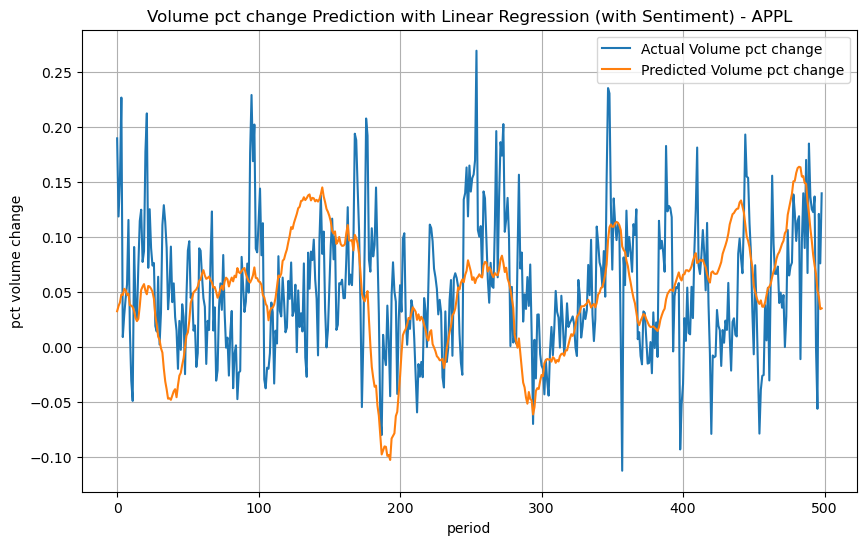

In [144]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_lr2, label='Actual Volume pct change')
plt.plot( Y_test_appl_pred_lr2, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Linear Regression (with Sentiment) - APPL')
plt.savefig(fig_dir+'LR_APPL_Sent.png', transparent=False)
plt.show()

In [145]:
# Calculate MAE and RMSE
mae_lr2_appl=metrics.mean_absolute_error(Y_test_appl_lr2,Y_test_appl_pred_lr2)
rmse_lr2_appl=np.sqrt(metrics.mean_squared_error(Y_test_appl_lr2,Y_test_appl_pred_lr2))
mad_lr2_appl=mda(Y_test_appl_lr2,Y_test_appl_pred_lr2)
print("Test MAE: ", mae_lr2_appl)
print("Test RMSE: ", rmse_lr2_appl)
print("Test MDA: ", mad_lr2_appl)

Test MAE:  0.053641441423921576
Test RMSE:  0.06719427402687089
Test MDA:  0.5502008032128514


In [146]:
# visualizer = ResidualsPlot(lr2_appl)
# plt.figure(figsize=(10, 6))
# visualizer.fit(X_train_appl_lr2, Y_train_appl_lr2)  # Fit the training data to the visualizer
# visualizer.score(X_test_appl_lr2, Y_test_appl_lr2)  # Evaluate the model on the test data
# plt.savefig(fig_dir+'LR_RES_APPL_Sent.png', transparent=False)
# visualizer.show() 

In [147]:
X_train_appl_lr2.columns

Index(['sent_score_appl', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'Price_variation_appl', 'OBV_appl',
       'RSI_appl', 'EMV_appl', 'ATR_appl'],
      dtype='object')

In [148]:
lr2_appl.coef_

array([ 1.21416015e-02,  1.12582645e-10,  8.66709729e-03, -4.73662386e-06,
       -1.56587100e-11, -4.12506290e-04, -7.20588789e-02,  7.57681900e-13,
        2.21302254e-04, -1.18778201e+00, -3.45712096e-01])

In [149]:
#importance_lr2_appl

NameError: name 'importance_lr2_appl' is not defined

In [151]:
features_lr1_appl=['EMV_appl','ATR_appl','Price_variation_appl','sent_score_appl',
                   'Adj Close_appl','Vix_index', 'RSI_appl','Adj Close_nasdaq',
                   'Volume_appl','Volume_nasdaq','OBV_appl']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Feature: 0, Score: 1.18778
Feature: 1, Score: 0.34571
Feature: 2, Score: 0.07206
Feature: 3, Score: 0.01214
Feature: 4, Score: 0.00867
Feature: 5, Score: 0.00041
Feature: 6, Score: 0.00022
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000


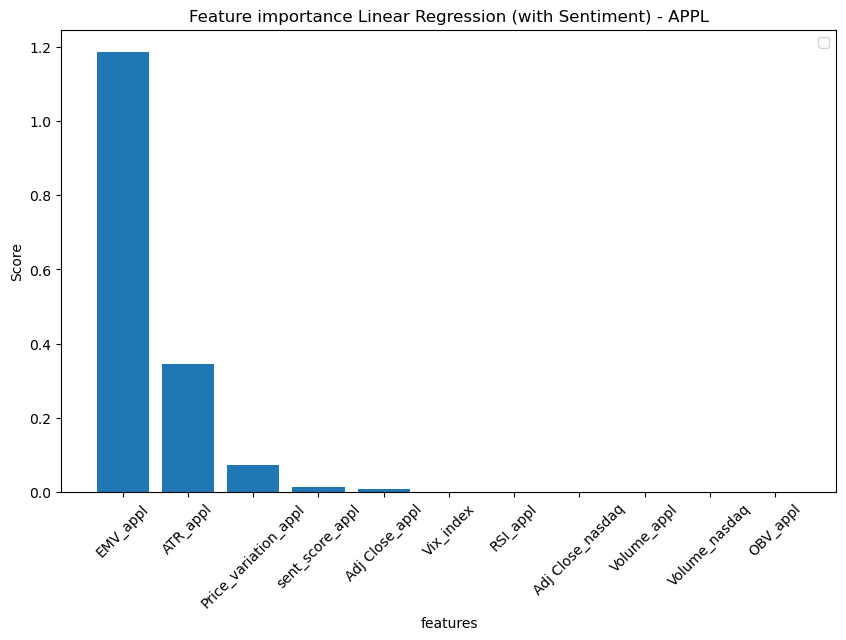

In [152]:
#Computing the features importance
# get importance
importance_lr2_appl = np.abs(lr2_appl.coef_)
importance_lr2_appl[::-1].sort()

# summarize feature importance
for i,v in enumerate(importance_lr2_appl):
 print('Feature: %0d, Score: %.5f' % (i,v))




# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_lr1_appl, importance_lr2_appl)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Linear Regression (with Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'LR_APPL_FI_Sent.png', transparent=False)
plt.show()
plt.show()

### 11.4 SUPPORT VECTOR REGRESSOR
Support Vector Machines (SVM) are widely used in machine learning for classification problems, but they can also be applied to regression problems through Support Vector Regression (SVR). SVR uses the same principles as SVM but focuses on predicting continuous outputs rather than classifying data points. Unlike Support Vector Machines (SVMs) used for classification tasks, SVR Model seeks a hyperplane that best fits the data points in a continuous space. This is achieved by mapping the input variables to a high-dimensional feature space and finding the hyperplane that maximizes the margin (distance) between the hyperplane and the closest data points, while also minimizing the prediction error. SVR Model can handle non-linear relationships between the input and target variables by using a kernel function to map the data to a higher-dimensional space. This makes it a powerful tool for regression tasks where complex relationships may exist.

### 11.4.1 TSLA SUPPORT VECTOR REGRESSOR

#### 11.4.1.1 TSLA SVR1 (No tesla news included)

In [153]:
df_tsla_hist_svr1=df_tsla_hist_merged_roll_f.copy()

In [154]:
# Split the data into training and testing sets
train_size_svr1 = int(0.8 * len(df_tsla_hist_svr1))
train_data_svr1 = df_tsla_hist_svr1[:train_size_svr1].reset_index().drop(columns=['index'])
test_data_svr1 = df_tsla_hist_svr1[train_size_svr1:].reset_index().drop(columns=['index'])

X_train_svr1, Y_train_svr1= train_data_svr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), train_data_svr1['pct_change_Volume_TSLA']
X_test_svr1, Y_test_svr1= test_data_svr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), test_data_svr1['pct_change_Volume_TSLA']

In [155]:
#Import the SVR package
from sklearn.svm import SVR

#initializing the multiple SVR model and model fitting
regressor_svr1=SVR()
regressor_svr1.fit(X_train_svr1,Y_train_svr1)

SVR()

In [156]:
# Make predictions on the test set
y_predict_svr1=regressor_svr1.predict(X_test_svr1)

In [157]:
kernel='rbf'

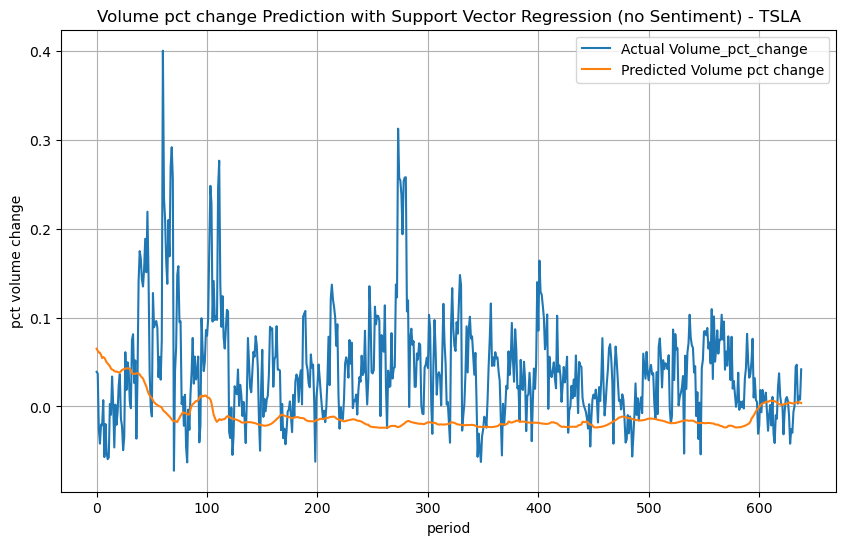

In [158]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_svr1, label='Actual Volume_pct_change')
plt.plot(y_predict_svr1, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Support Vector Regression (no Sentiment) - TSLA')
#plt.savefig(fig_dir+'SVR_TSLA_NoSent.png', transparent=False)
plt.show()

In [166]:
# Calculate MAE and RMSE
mae_svr1=metrics.mean_absolute_error(Y_test_svr1,y_predict_svr1)
rmse_svr1=np.sqrt(mean_squared_error(Y_test_svr1, y_predict_svr1))
mad_svr1=mda(Y_test_svr1,y_predict_svr1)
print("Test MAE: ",mae_svr1)
print("Test RMSE: ",rmse_svr1)
print("Test MDA: ",mad_svr1)

Test MAE:  0.06301229938337168
Test RMSE:  0.08336567796057937
Test MDA:  0.5250783699059561


In [167]:
X_train_svr1.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla',
       'ATR_tsla'],
      dtype='object')

In [185]:
importance_svr1

array([ 8.67361738e-19, -1.61423916e-06,  2.70825029e-15,  2.95955822e-05,
       -5.20417043e-19,  0.00000000e+00, -1.94001128e-04, -8.67361738e-19,
       -1.38777878e-18,  0.00000000e+00])

In [186]:
importance_svr1_abs=np.abs(importance_svr1)
importance_svr1_abs

array([8.67361738e-19, 1.61423916e-06, 2.70825029e-15, 2.95955822e-05,
       5.20417043e-19, 0.00000000e+00, 1.94001128e-04, 8.67361738e-19,
       1.38777878e-18, 0.00000000e+00])

In [187]:
importance_svr1_abs[::-1].sort()

In [188]:
importance_svr1_abs

array([1.94001128e-04, 2.95955822e-05, 1.61423916e-06, 2.70825029e-15,
       1.38777878e-18, 8.67361738e-19, 8.67361738e-19, 5.20417043e-19,
       0.00000000e+00, 0.00000000e+00])

In [189]:
features_svr1=['OBV_tsla','Volume_nasdaq','Volume_tsla','Adj Close_nasdaq',
               'EMV_tsla','Vix_index','ATR_appl','Price_variation_appl',
               'RSI_tsla','Adj Close_appl']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Feature: 0, Score: 1.18778
Feature: 1, Score: 0.34571
Feature: 2, Score: 0.07206
Feature: 3, Score: 0.01214
Feature: 4, Score: 0.00867
Feature: 5, Score: 0.00041
Feature: 6, Score: 0.00022
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000


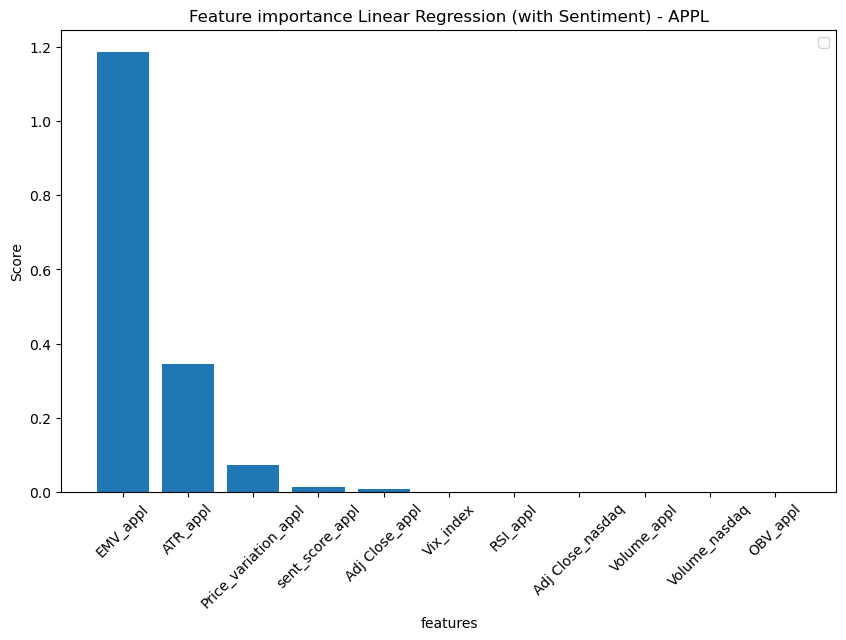

In [173]:
#Computing the features importance
# get importance
importance_svr1 = np.abs(lr2_appl.coef_)
importance_lr2_appl[::-1].sort()

# summarize feature importance
for i,v in enumerate(importance_lr2_appl):
 print('Feature: %0d, Score: %.5f' % (i,v))




# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_svr1, importance_svr1)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Support Vector Regression (with Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'LR_APPL_FI_Sent.png', transparent=False)
plt.show()
plt.show()

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00002
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00023
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000


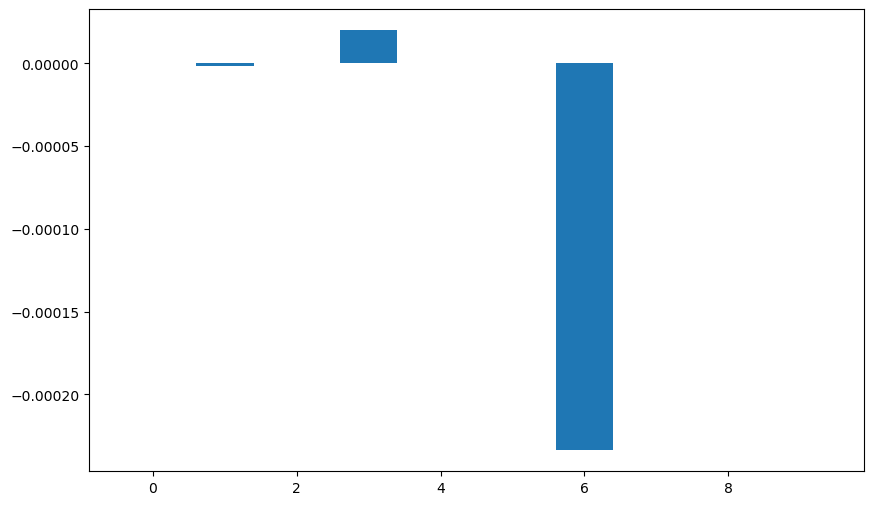

In [190]:
#Computing the Features importance
results_svr1 = permutation_importance(regressor_svr1, X_test_svr1, Y_test_svr1, scoring='neg_mean_squared_error')
# get importance
importance_svr1 = results_svr1.importances_mean
# summarize feature importance
for i,v in enumerate(importance_svr1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_svr1))], importance_svr1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


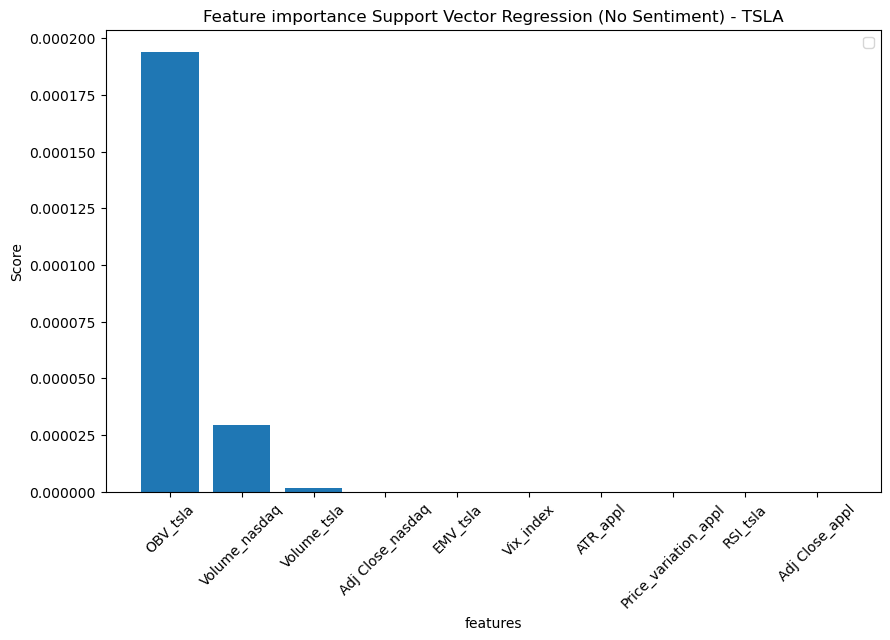

In [191]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_svr1, importance_svr1_abs)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Support Vector Regression (No Sentiment) - TSLA')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'SVR_TSLA_FI_NoSent.png', transparent=False)
plt.show()
plt.show()

#### 11.4.1.2 TSLA SVR2 (tesla news included)

In [ ]:
df_tsla_hist_svr2=df_tsla_hist_merged_roll_f.copy()

In [ ]:
# Split the data into training and testing sets
train_size_svr2 = int(0.8 * len(df_tsla_hist_svr2))
train_data_svr2 = df_tsla_hist_svr2[:train_size_svr2].reset_index().drop(columns=['index'])
test_data_svr2 = df_tsla_hist_svr2[train_size_svr2:].reset_index().drop(columns=['index'])

X_train_svr2, Y_train_svr2= train_data_svr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), train_data_svr2['pct_change_Volume_TSLA']
X_test_svr2, Y_test_svr2= test_data_svr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), test_data_svr2['pct_change_Volume_TSLA']

In [ ]:
#initializing the multiple SVR model and model fitting
regressor_svr2=SVR(kernel='rbf')
regressor_svr2.fit(X_train_svr2,Y_train_svr2)

In [ ]:
# Make predictions on the test set
y_predict_svr2=regressor_svr2.predict(X_test_svr2)

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_svr2, label='Actual Volume pct change')
plt.plot(y_predict_svr2, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Support Vector Regression (with Sentiment) - TSLA')
#plt.savefig(fig_dir+'SVR_TSLA_Sent.png', transparent=False)
plt.show()

In [ ]:
# Calculate MAE and RMSE
mae_svr2=metrics.mean_absolute_error(Y_test_svr2,y_predict_svr2)
rmse_svr2=np.sqrt(mean_squared_error(Y_test_svr2, y_predict_svr2))
mad_svr2=mda(Y_test_svr2,y_predict_svr2)
print("Test MAE: ",mae_svr2)
print("Test RMSE: ",rmse_svr2)
print("Test MDA: ",mad_svr2)

In [ ]:
X_train_svr2.columns

In [ ]:
importance_svr2

In [159]:
importance_svr2_abs=np.abs(importance_svr2)
importance_svr2_abs

NameError: name 'importance_svr2' is not defined

In [160]:
importance_svr2_abs[::-1].sort()
importance_svr2_abs

NameError: name 'importance_svr2_abs' is not defined

In [161]:
features_svr2=['OBV_tsla','Volume_nasdaq','Volume_tsla','Adj Close_nasdaq',
               'Adj Close_tsla','RSI_tsla','ATR_tsla','EMV_tsla','Vix_index',
               'Price_variation_tsla','sent_score_tsla']

In [162]:
#Computing the Features importance
results_svr2 = permutation_importance(regressor_svr2, X_test_svr2, Y_test_svr2, scoring='neg_mean_squared_error')
# get importance
importance_svr2 = results_svr2.importances_mean
# summarize feature importance
for i,v in enumerate(importance_svr2):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_svr2))], importance_svr2)
plt.show()

NameError: name 'regressor_svr2' is not defined

In [163]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_svr2, importance_svr2_abs)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Support Vector Regression (with Sentiment) - TSLA')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'SVR_TSLA_FI_Sent.png', transparent=False)
plt.show()
plt.show()

NameError: name 'importance_svr2_abs' is not defined

<Figure size 1000x600 with 0 Axes>

### 11.4.3 APPL SUPPORT VECTOR REGRESSOR

#### 11.4.3.1 APPL SVR1 (No APPL news included)

In [194]:
df_appl_hist_svr1=df_appl_hist_merged_roll_f.copy()

In [197]:
df_appl_hist_svr1.columns

Index(['sent_score_appl', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_appl',
       'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl', 'ATR_appl',
       'Id'],
      dtype='object')

In [198]:
# Split the data into training and testing sets
train_appl_size_svr1 = int(0.8 * len(df_appl_hist_svr1))
train_appl_data_svr1 = df_appl_hist_svr1[:train_appl_size_svr1].reset_index().drop(columns=['index'])
test_appl_data_svr1 = df_appl_hist_svr1[train_appl_size_svr1:].reset_index().drop(columns=['index'])

X_train_appl_svr1, Y_train_appl_svr1= train_appl_data_svr1.drop(columns=['Id','pct_change_Volume_appl','sent_score_appl'], axis=1), train_appl_data_svr1['pct_change_Volume_appl']
X_test_appl_svr1, Y_test_appl_svr1= test_appl_data_svr1.drop(columns=['Id','pct_change_Volume_appl','sent_score_appl'], axis=1), test_appl_data_svr1['pct_change_Volume_appl']

In [199]:
#initializing the multiple SVR model and model fitting
regressor_svr1_appl=SVR(kernel='rbf')
regressor_svr1_appl.fit(X_train_appl_svr1,Y_train_appl_svr1)

SVR()

In [200]:
# Make predictions on the test set
y_predict_svr1_appl=regressor_svr1_appl.predict(X_test_appl_svr1)

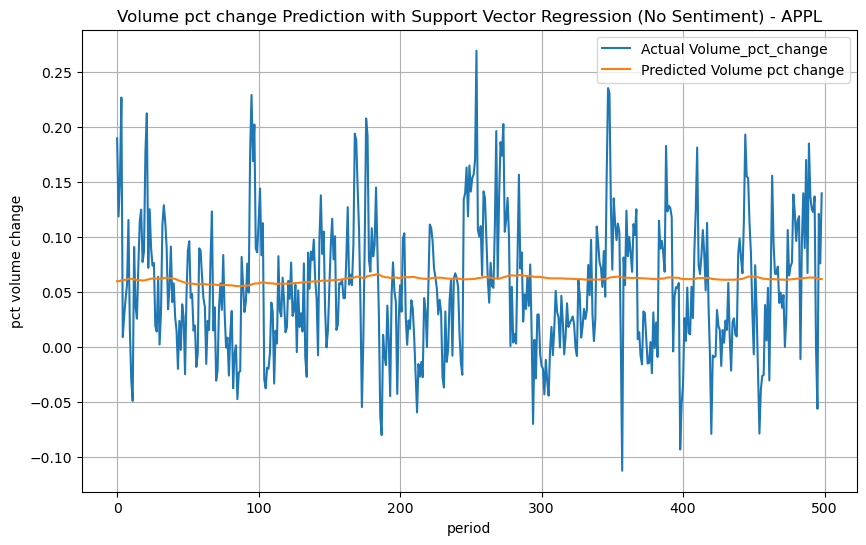

In [201]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_svr1, label='Actual Volume_pct_change')
plt.plot(y_predict_svr1_appl, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Support Vector Regression (No Sentiment) - APPL')
#plt.savefig(fig_dir+'SVR_APPL_NoSent.png', transparent=False)
plt.show()

In [202]:
# Calculate MAE and RMSE
mae_svr1_appl=metrics.mean_absolute_error(Y_test_appl_svr1,y_predict_svr1_appl)
rmse_svr1_appl=np.sqrt(mean_squared_error(Y_test_appl_svr1, y_predict_svr1_appl))
mad_svr1_appl=mda(Y_test_appl_svr1,y_predict_svr1_appl)
print("Test MAE: ",mae_svr1_appl)
print("Test RMSE: ",rmse_svr1_appl)
print("Test MDA: ",mad_svr1_appl)

Test MAE:  0.04866385840287715
Test RMSE:  0.06064885914126013
Test MDA:  0.6526104417670683


In [203]:
X_train_appl_svr1.columns

Index(['Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl',
       'ATR_appl'],
      dtype='object')

In [209]:
importance_svr1_appl

array([ 1.74558264e-05, -6.93889390e-19,  7.50267903e-17,  6.15255277e-07,
       -1.73472348e-19,  0.00000000e+00,  1.72328602e-05, -2.16840434e-18,
        0.00000000e+00,  0.00000000e+00])

In [210]:
importance_svr1_appl_abs=np.abs(importance_svr1_appl)
importance_svr1_appl_abs

array([1.74558264e-05, 6.93889390e-19, 7.50267903e-17, 6.15255277e-07,
       1.73472348e-19, 0.00000000e+00, 1.72328602e-05, 2.16840434e-18,
       0.00000000e+00, 0.00000000e+00])

In [211]:
importance_svr1_appl_abs[::-1].sort()
importance_svr1_appl_abs

array([1.74558264e-05, 1.72328602e-05, 6.15255277e-07, 7.50267903e-17,
       2.16840434e-18, 6.93889390e-19, 1.73472348e-19, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [207]:
features_svr1_appl=['Volume_appl','OBV_appl','Volume_nasdaq','Adj Close_nasdaq',
                    'RSI_appl','Adj Close_appl','Vix_index','ATR_tsla','EMV_tsla',
                    'Price_variation_tsla']

Feature: 0, Score: 0.00002
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00002
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000


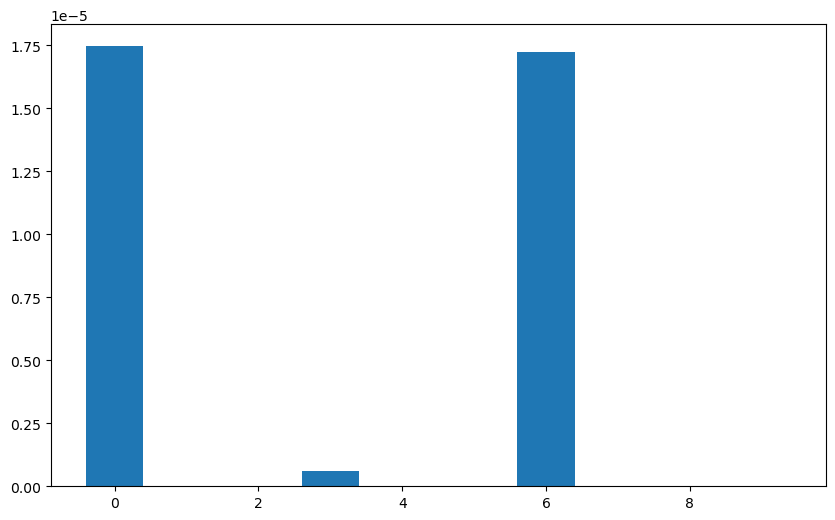

In [208]:
#Computing the feature importance
results_svr1_appl = permutation_importance(regressor_svr1_appl, X_test_appl_svr1, Y_test_appl_svr1, scoring='neg_mean_squared_error')
# get importance
importance_svr1_appl = results_svr1_appl.importances_mean
# summarize feature importance
for i,v in enumerate(importance_svr1_appl):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_svr1_appl))], importance_svr1_appl)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


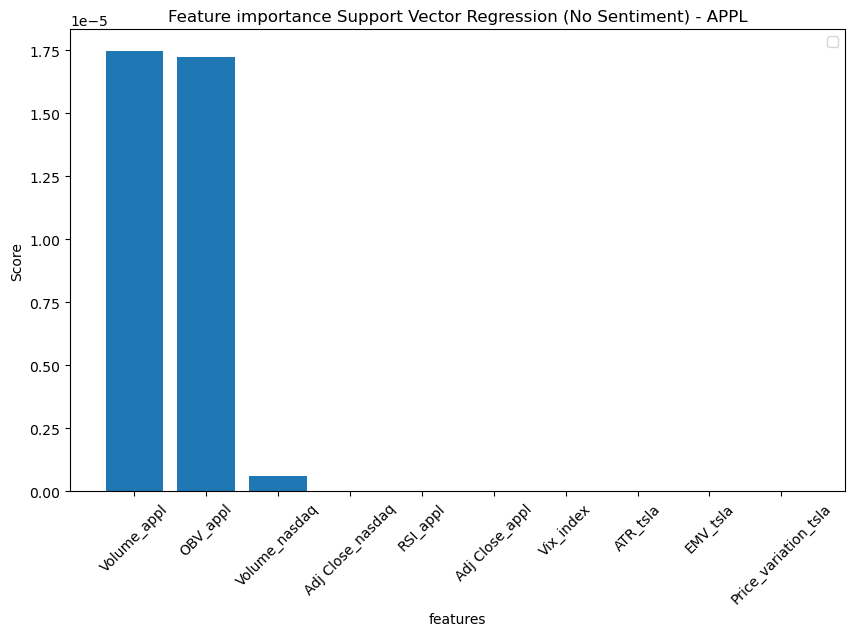

In [212]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_svr1_appl, importance_svr1_appl_abs)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Support Vector Regression (No Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'SVR_APPL_FI_NoSent.png', transparent=False)
plt.show()

#### 11.4.3.2 APPL SVR2 (Appl news included)

In [ ]:
df_appl_hist_svr2=df_appl_hist_merged_roll_f.copy()

In [ ]:
# Split the data into training and testing sets
train_appl_size_svr2 = int(0.8 * len(df_appl_hist_svr2))
train_appl_data_svr2 = df_appl_hist_svr2[:train_appl_size_svr2].reset_index().drop(columns=['index'])
test_appl_data_svr2 = df_appl_hist_svr2[train_appl_size_svr2:].reset_index().drop(columns=['index'])

X_train_appl_svr2, Y_train_appl_svr2= train_appl_data_svr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), train_appl_data_svr2['pct_change_Volume_appl']
X_test_appl_svr2, Y_test_appl_svr2= test_appl_data_svr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), test_appl_data_svr2['pct_change_Volume_appl']

In [177]:
#initializing the multiple SVR model and model fitting
regressor_svr2_appl=SVR(kernel='rbf')
regressor_svr2_appl.fit(X_train_appl_svr2,Y_train_appl_svr2)

NameError: name 'X_train_appl_svr2' is not defined

In [178]:
# Make predictions on the test set
y_predict_svr2_appl=regressor_svr2_appl.predict(X_test_appl_svr2)

NameError: name 'X_test_appl_svr2' is not defined

NameError: name 'Y_test_appl_svr2' is not defined

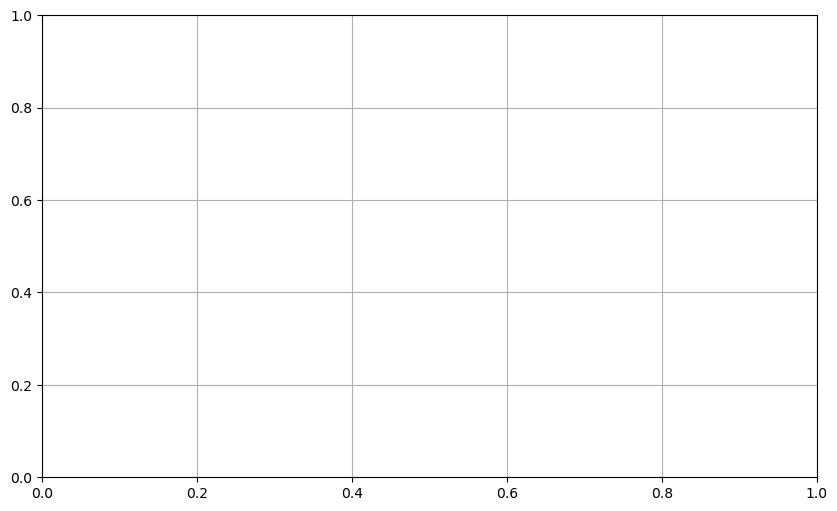

In [179]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_svr2, label='Actual Volume pct change')
plt.plot(y_predict_svr2_appl, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Support Vector Regression (with Sentiment) - APPL')
#plt.savefig(fig_dir+'SVR_APPL_Sent.png', transparent=False)
plt.show()

In [180]:
# Calculate MAE and RMSE
mae_svr2_appl=metrics.mean_absolute_error(Y_test_appl_svr2,y_predict_svr2_appl)
rmse_svr2_appl=np.sqrt(mean_squared_error(Y_test_appl_svr2, y_predict_svr2_appl))
mad_svr2_appl=mda(Y_test_appl_svr2,y_predict_svr2_appl)
print("Test MAE: ",mae_svr2_appl)
print("Test RMSE: ",rmse_svr2_appl)
print("Test MDA: ",mad_svr2_appl)

NameError: name 'Y_test_appl_svr2' is not defined

In [181]:
X_train_appl_svr2.columns

NameError: name 'X_train_appl_svr2' is not defined

In [182]:
importance_svr2_appl

NameError: name 'importance_svr2_appl' is not defined

In [183]:
importance_svr2_appl_abs=np.abs(importance_svr2_appl)
importance_svr2_appl_abs

NameError: name 'importance_svr2_appl' is not defined

In [184]:
importance_svr2_appl_abs[::-1].sort()
importance_svr2_appl_abs

NameError: name 'importance_svr2_appl_abs' is not defined

In [185]:
features_svr2_appl=['OBV_appl','Volume_appl','Volume_nasdaq','Adj Close_nasdaq',
                    'RSI_appl','Vix_index','Adj Close_appl','ATR_tsla','EMV_tsla',
                    'Price_variation_tsla','sent_score_tsla']

In [186]:
#Computing the feature importance
results_svr2_appl = permutation_importance(regressor_svr2_appl, X_train_appl_svr2, Y_train_appl_svr2, scoring='neg_mean_squared_error')
# get importance
importance_svr2_appl = results_svr2_appl.importances_mean
# summarize feature importance
for i,v in enumerate(importance_svr2_appl):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_svr2_appl))], importance_svr2_appl)
plt.show()

NameError: name 'X_train_appl_svr2' is not defined

In [187]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(features_svr2_appl, importance_svr2_appl_abs)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Support Vector Regression (with Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'SVR_APPL_FI_Sent.png', transparent=False)
plt.show()

NameError: name 'importance_svr2_appl_abs' is not defined

<Figure size 1000x600 with 0 Axes>

### 11.5 RANDOM FOREST REGRESSION
Random forest is a supervised learning algorithm, meaning that the data on which it operates contains labels or outcomes. A Random forest regression model combines multiple decision trees to create a single model. Each tree in the forest builds from a different subset of the data and makes its independent prediction. The final prediction for input is based on the average or weighted average of all the individual trees’ predictions. 
The random tree model works well with large datasets and captures non-linear relationships between input and target variables.
It is less prone to overfitting than other regression methods since it builds multiple random trees independently and averages them out at the end of its prediction process. Random forest regression is more reliable than traditional linear models for complex problems involving high dimensionality.

### 11.5.1 TSLA RANDOM FOREST REGRESSION

#### 11.5.1.1 TSLA RFR1 (No tesla news included)

In [174]:
df_tsla_hist_rfr1=df_tsla_hist_merged_roll_f.copy()

In [175]:
# Split the data into training and testing sets
train_size_rfr1 = int(0.8 * len(df_tsla_hist_rfr1))
train_data_rfr1 = df_tsla_hist_rfr1[:train_size_rfr1].reset_index().drop(columns=['index'])
test_data_rfr1 = df_tsla_hist_rfr1[train_size_rfr1:].reset_index().drop(columns=['index'])


X_train_rfr1, Y_train_rfr1= train_data_rfr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), train_data_rfr1['pct_change_Volume_TSLA']
X_test_rfr1, Y_test_rfr1= test_data_rfr1.drop(columns=['Id','pct_change_Volume_TSLA','sent_score_tsla'], axis=1), test_data_rfr1['pct_change_Volume_TSLA']

In [176]:
#Import the RFR package
from sklearn.ensemble import RandomForestRegressor

#initializing the multiple SVR model and model fitting
rfr1_model = RandomForestRegressor(n_estimators=200, random_state=42)
rfr1_model.fit(X_train_rfr1, Y_train_rfr1)

RandomForestRegressor(n_estimators=200, random_state=42)

In [177]:
# Make predictions on the test set
y_pred_rfr1 = rfr1_model.predict(X_test_rfr1)

In [178]:
Y_train_rfr1

0       0.054048
1       0.078988
2       0.047436
3       0.137898
4       0.124756
          ...   
2547    0.003317
2548    0.024778
2549    0.025533
2550   -0.006437
2551    0.044209
Name: pct_change_Volume_TSLA, Length: 2552, dtype: float64

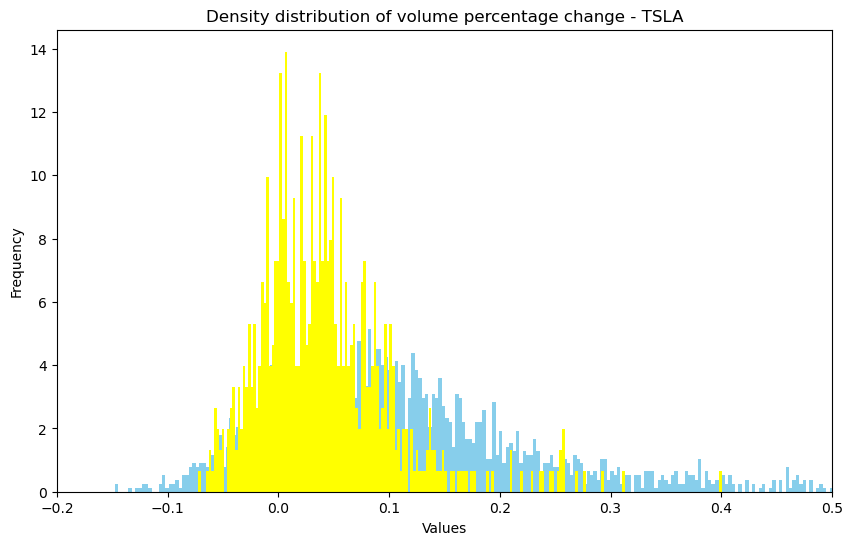

In [179]:
plt.figure(figsize=(10,6))
plt.hist(Y_train_rfr1, bins=500, color='skyblue', density=True)
plt.hist(Y_test_rfr1, bins=200, color='yellow', density=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(-0.2,0.5)
plt.title('Density distribution of volume percentage change - TSLA')
plt.show()

In [180]:
X_train_rfr1.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla',
       'ATR_tsla'],
      dtype='object')

In [181]:
X_test_rfr1.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla',
       'ATR_tsla'],
      dtype='object')

In [182]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

<Figure size 1000x600 with 0 Axes>

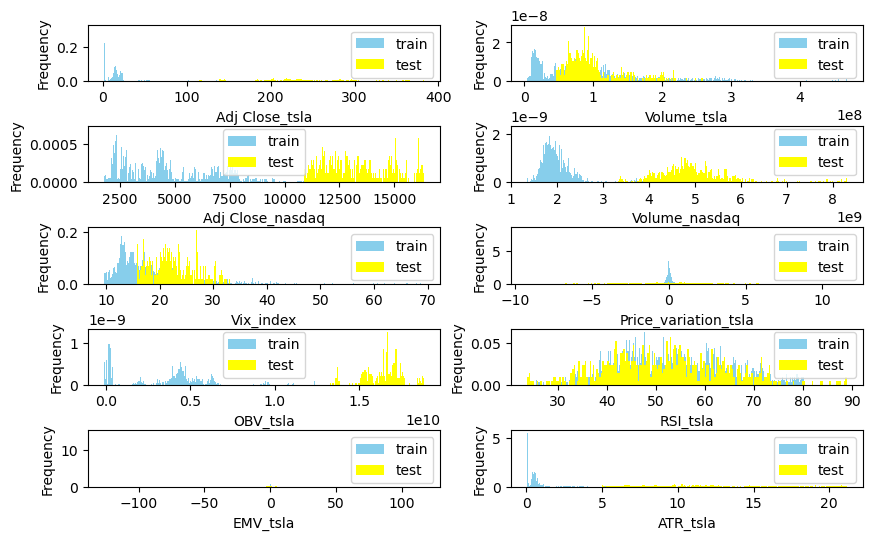

In [204]:


plt.subplot(5, 2, 1)
plt.hist(X_train_rfr1['Adj Close_tsla'], bins=500, color='skyblue', density=True, label='train')
plt.hist(X_test_rfr1['Adj Close_tsla'], bins=200, color='yellow', density=True, label='test')
plt.xlabel('Adj Close_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 2)
plt.hist(X_train_rfr1['Volume_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['Volume_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Volume_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 3)
plt.hist(X_train_rfr1['Adj Close_nasdaq'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['Adj Close_nasdaq'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Adj Close_nasdaq')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 4)
plt.hist(X_train_rfr1['Volume_nasdaq'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['Volume_nasdaq'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Volume_nasdaq')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 5)
plt.hist(X_train_rfr1['Vix_index'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['Vix_index'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Vix_index')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 6)
plt.hist(X_train_rfr1['Price_variation_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['Price_variation_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Price_variation_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 7)
plt.hist(X_train_rfr1['OBV_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['OBV_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('OBV_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 8)
plt.hist(X_train_rfr1['RSI_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['RSI_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('RSI_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 9)
plt.hist(X_train_rfr1['EMV_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['EMV_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('EMV_tsla')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 10)
plt.hist(X_train_rfr1['ATR_tsla'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_rfr1['ATR_tsla'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('ATR_tsla')
plt.ylabel('Frequency')
plt.legend()


plt.subplots_adjust(hspace=0.8)

plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(Y_train_rfr1, bins=500, color='skyblue', density=True)
plt.hist(Y_test_rfr1, bins=200, color='yellow', density=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(-0.2,0.5)
plt.title('Density distribution of volume percentage change - TSLA')
plt.show()

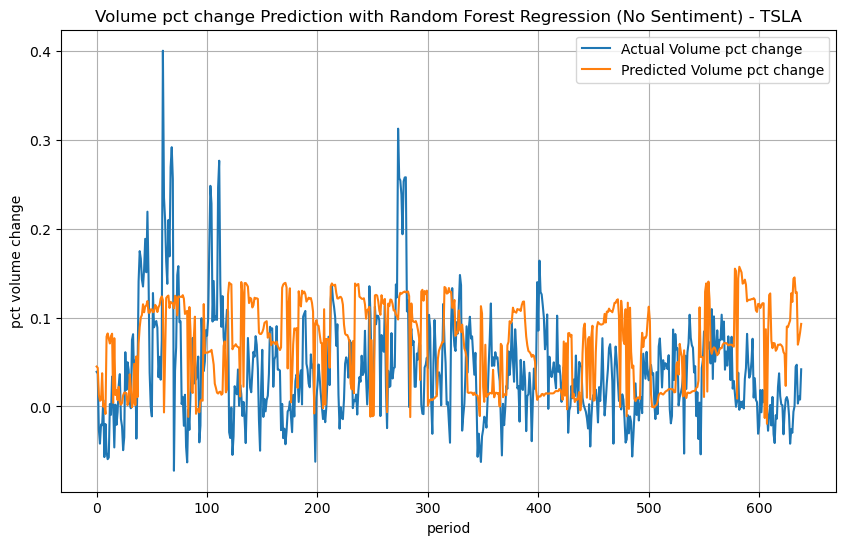

In [184]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_rfr1, label='Actual Volume pct change')
plt.plot(y_pred_rfr1, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Random Forest Regression (No Sentiment) - TSLA')
#plt.savefig(fig_dir+'RFR_TSLA_NoSent.png', transparent=False)
plt.show()

In [240]:
# Calculate MAE and RMSE
mae_rfr1=metrics.mean_absolute_error(Y_test_rfr1,y_pred_rfr1)
rmse_rfr1=np.sqrt(mean_squared_error(Y_test_rfr1, y_pred_rfr1))
mad_rfr1=mda(Y_test_rfr1,y_pred_rfr1)
print("Test MAE: ",mae_rfr1)
print("Test RMSE: ",rmse_rfr1)
print("Test MDA: ",mad_rfr1)

Test MAE:  0.06407622621371246
Test RMSE:  0.0788151429267546
Test MDA:  0.493730407523511


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


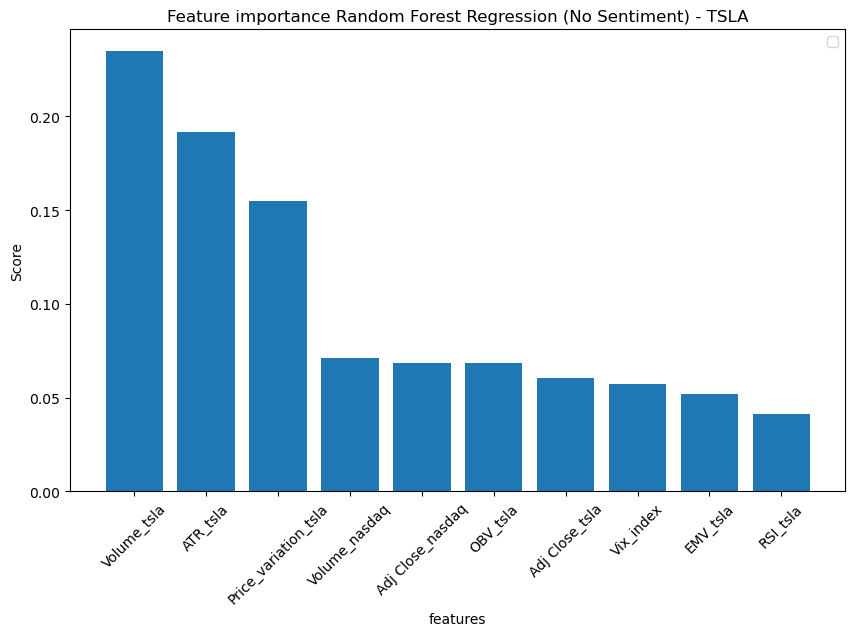

In [259]:
plt.figure(figsize=(10, 6))
plt.bar(importances_rfr1.index, importances_rfr1.values)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Random Forest Regression (No Sentiment) - TSLA')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'RFR_TSLA_FI_NoSent.png', transparent=False)
plt.show()

In [257]:
importances_rfr1.values

array([0.23469075, 0.19164164, 0.15491044, 0.07137129, 0.06826888,
       0.06825151, 0.06034721, 0.05702984, 0.05215735, 0.04133107])

In [256]:
importances_rfr1.index

Index(['Volume_tsla', 'ATR_tsla', 'Price_variation_tsla', 'Volume_nasdaq',
       'Adj Close_nasdaq', 'OBV_tsla', 'Adj Close_tsla', 'Vix_index',
       'EMV_tsla', 'RSI_tsla'],
      dtype='object')

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

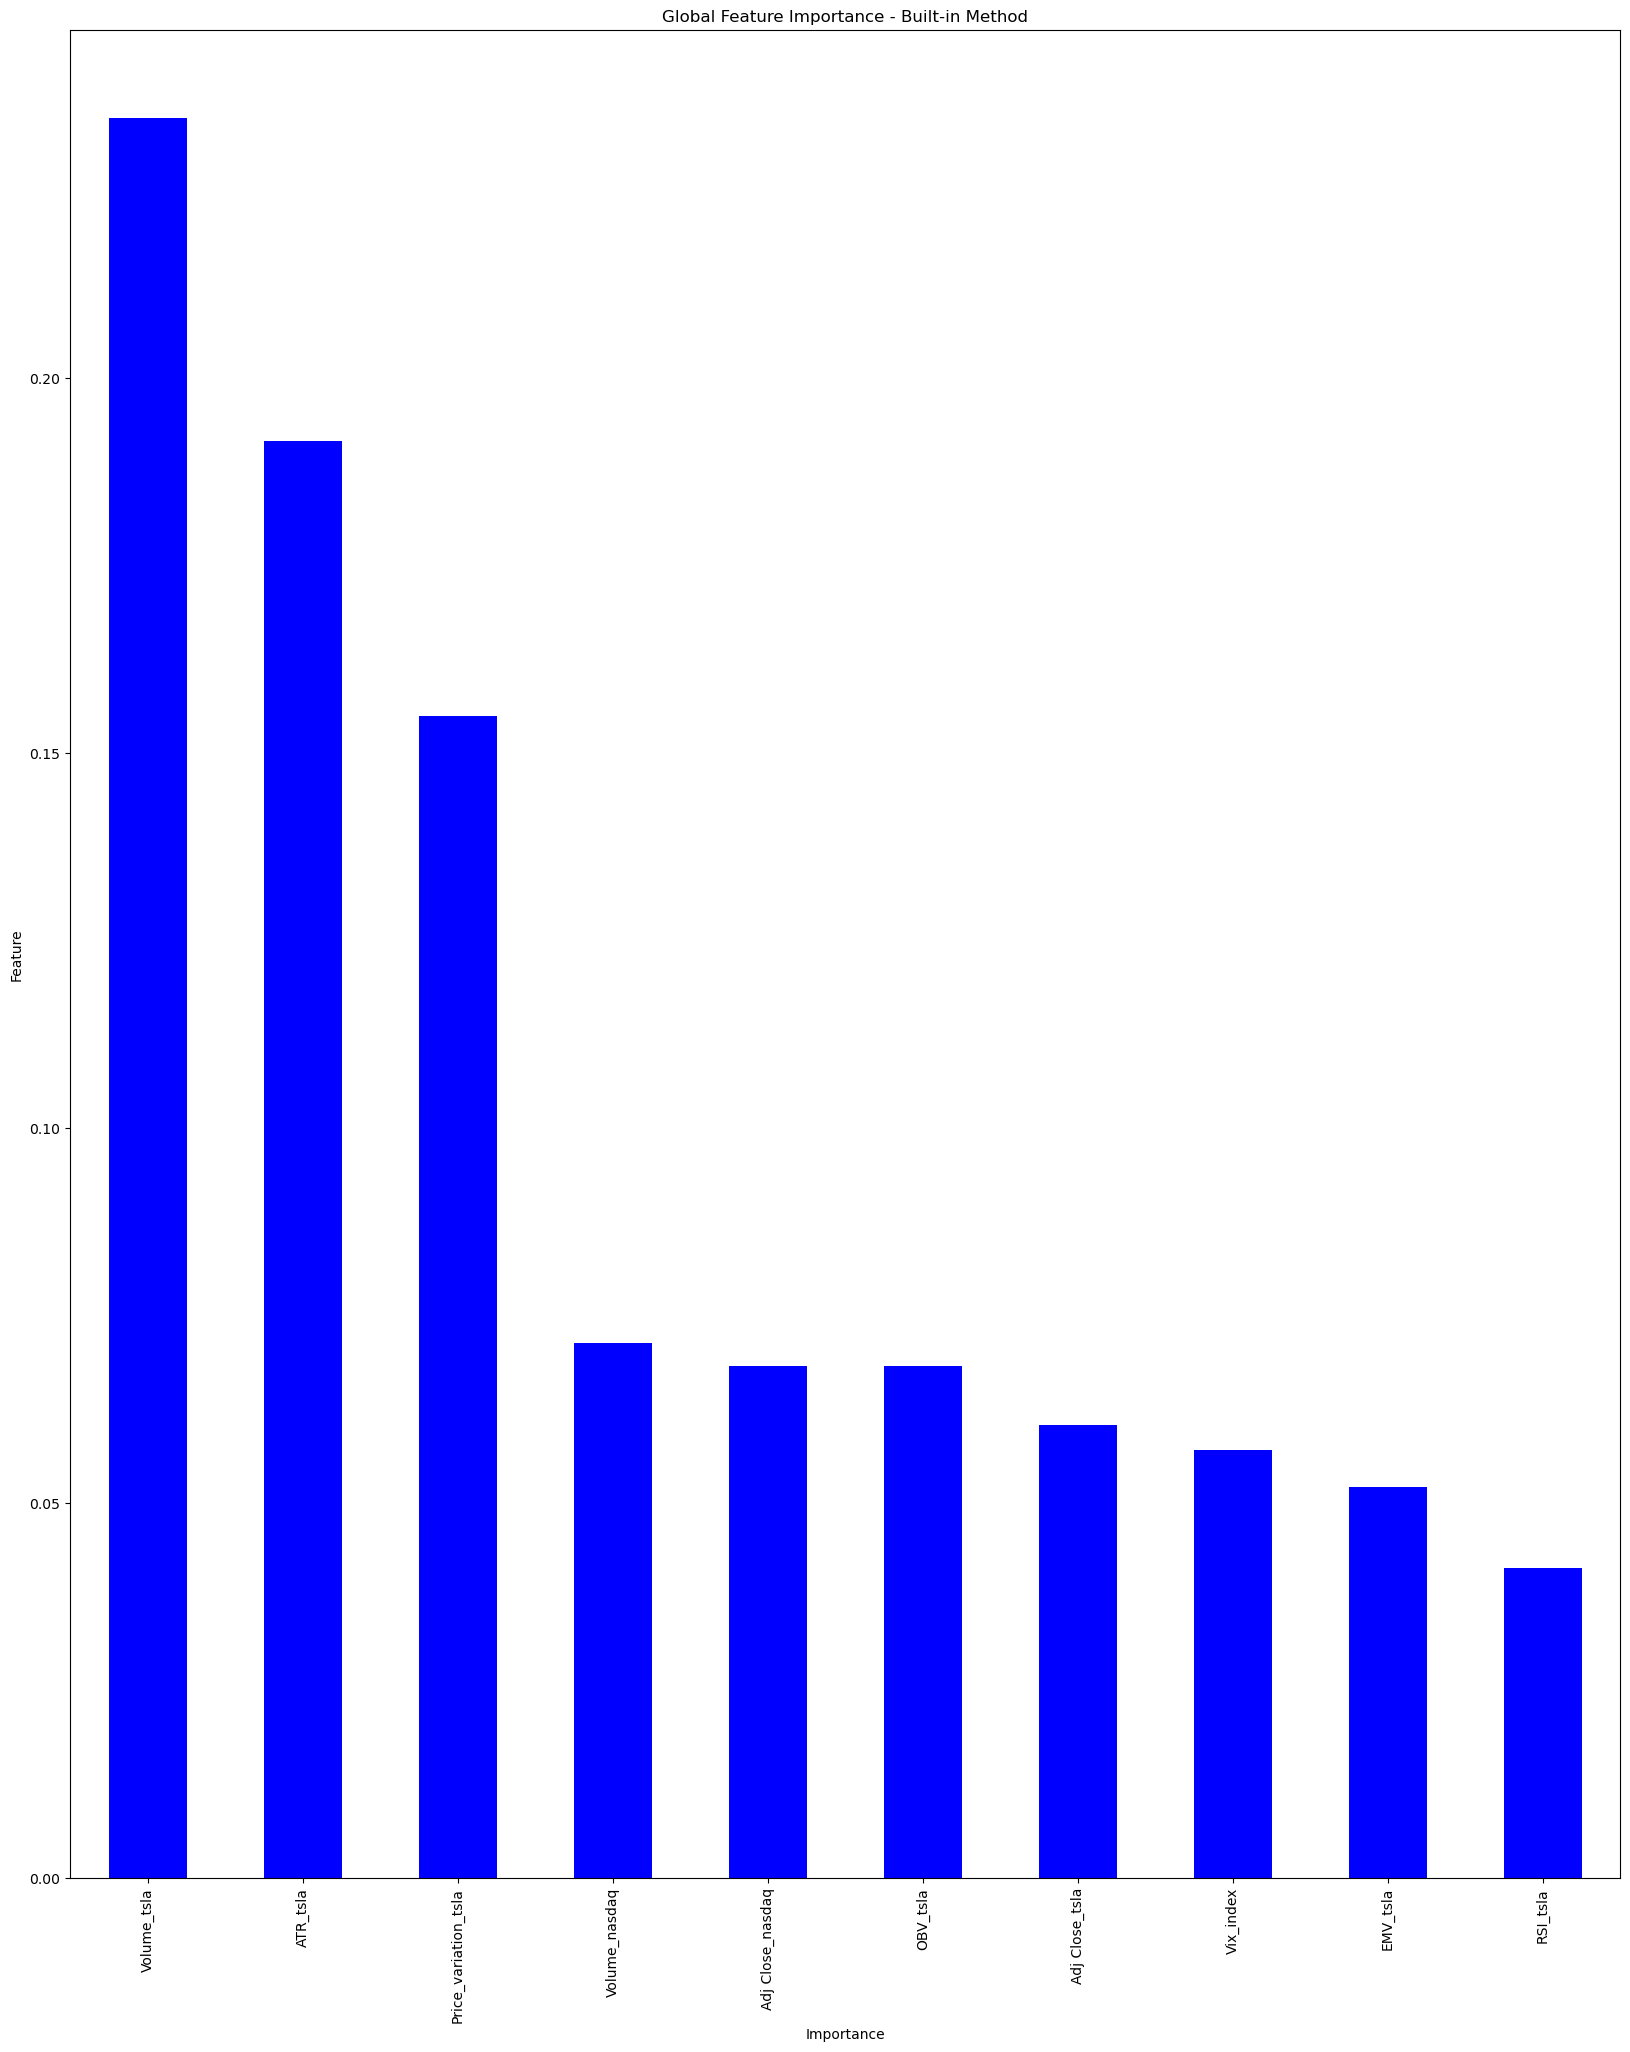

In [242]:
#Computing the features importance
importances_rfr1 = pd.Series(rfr1_model.feature_importances_, index=X_train_rfr1.columns)
importances_rfr1.sort_values(ascending=False, inplace=True)
importances_rfr1.plot.bar(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

#### 11.5.1.2 TSLA RFR2 (tesla news included)

In [261]:
df_tsla_hist_rfr2=df_tsla_hist_merged_roll_f.copy()

In [262]:
# Split the data into training and testing sets
train_size_rfr2 = int(0.8 * len(df_tsla_hist_rfr2))
train_data_rfr2 = df_tsla_hist_rfr2[:train_size_rfr2].reset_index().drop(columns=['index'])
test_data_rfr2 = df_tsla_hist_rfr2[train_size_rfr2:].reset_index().drop(columns=['index'])


X_train_rfr2, Y_train_rfr2= train_data_rfr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), train_data_rfr2['pct_change_Volume_TSLA']
X_test_rfr2, Y_test_rfr2= test_data_rfr2.drop(columns=['Id','pct_change_Volume_TSLA'], axis=1), test_data_rfr2['pct_change_Volume_TSLA']

In [263]:
#initializing the multiple SVR model and model fitting
rfr2_model = RandomForestRegressor(n_estimators=200, random_state=42)
rfr2_model.fit(X_train_rfr2, Y_train_rfr2)

RandomForestRegressor(n_estimators=200, random_state=42)

In [264]:
# Make predictions on the test set
y_pred_rfr2 = rfr2_model.predict(X_test_rfr2)

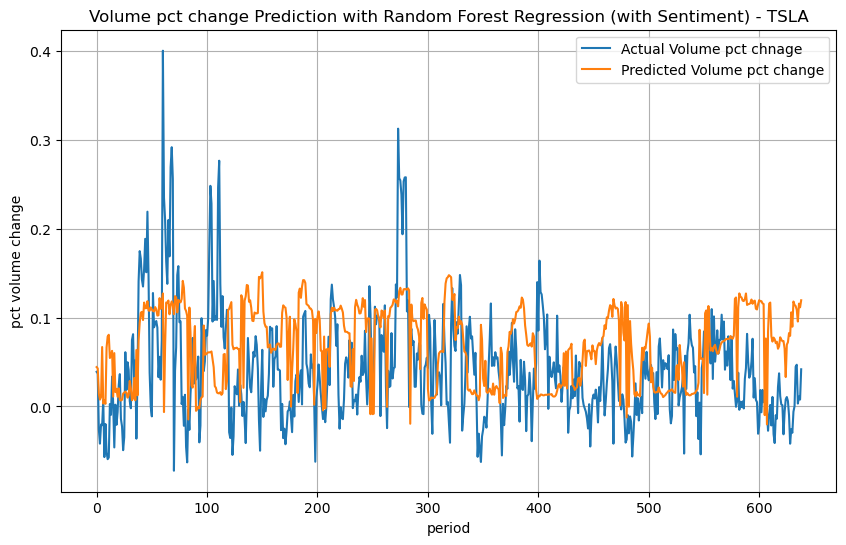

In [266]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_rfr2, label='Actual Volume pct chnage')
plt.plot(y_pred_rfr2, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Random Forest Regression (with Sentiment) - TSLA')
#plt.savefig(fig_dir+'RFR_TSLA_NoSent.png', transparent=False)
plt.show()

In [267]:
# Calculate MAE and RMSE
mae_rfr2=metrics.mean_absolute_error(Y_test_rfr2,y_pred_rfr2)
rmse_rfr2=np.sqrt(mean_squared_error(Y_test_rfr2, y_pred_rfr2))
mad_rfr2=mda(Y_test_rfr2,y_pred_rfr2)
print("Test MAE: ",mae_rfr2)
print("Test RMSE: ",rmse_rfr2)
print("Test MDA: ",mad_rfr2)

Test MAE:  0.06110393660705283
Test RMSE:  0.07554842251563286
Test MDA:  0.48119122257053293


Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

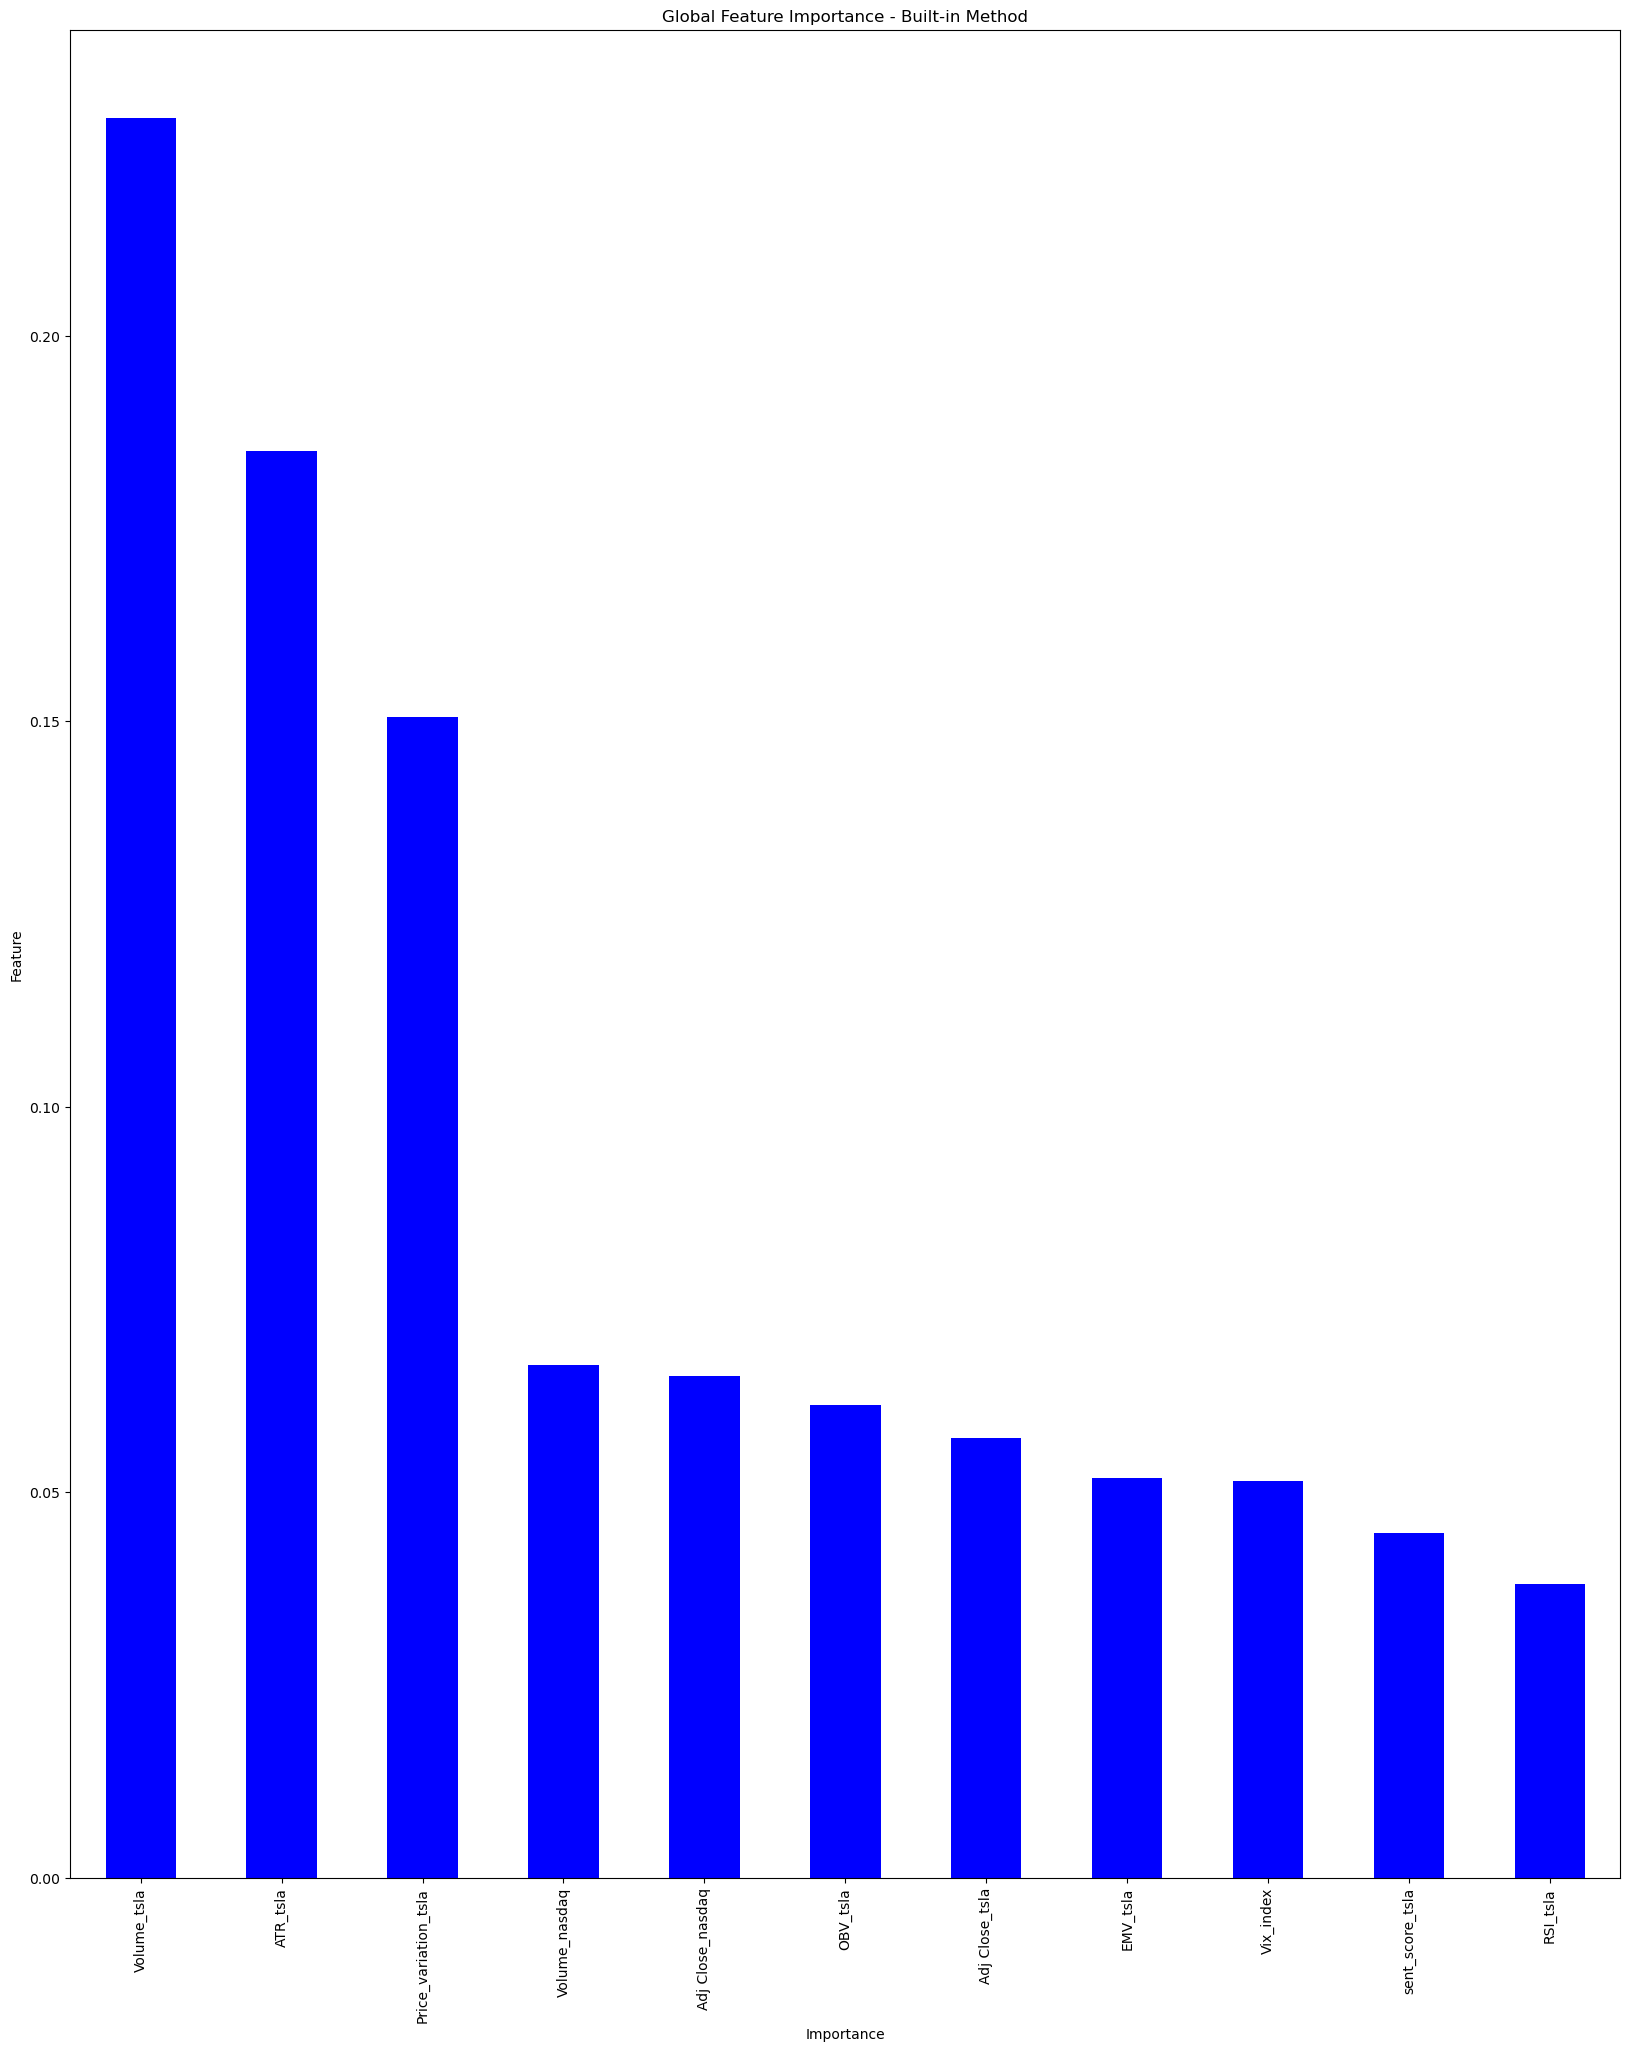

In [268]:
#Computing the features importance
importances_rfr2 = pd.Series(rfr2_model.feature_importances_, index=X_train_rfr2.columns)
importances_rfr2.sort_values(ascending=False, inplace=True)
importances_rfr2.plot.bar(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


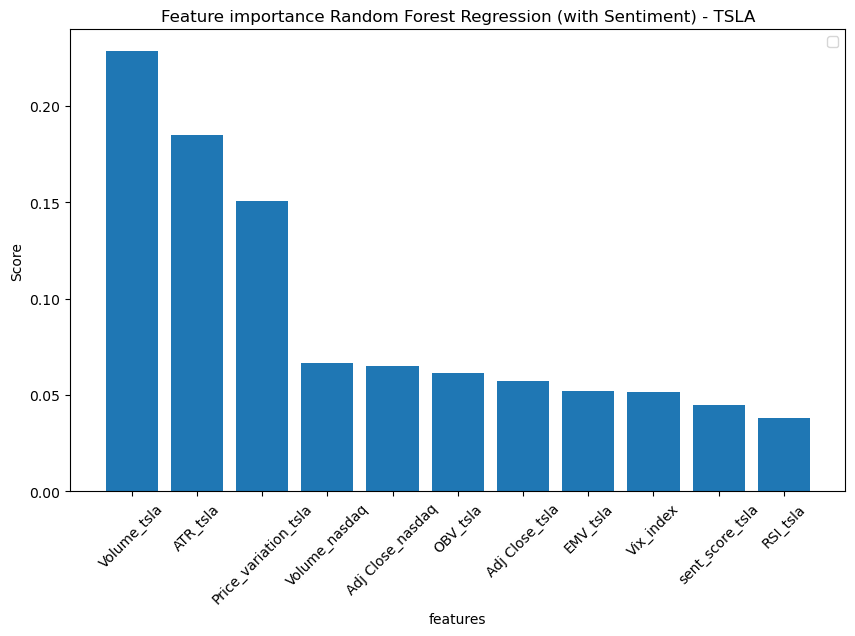

In [270]:
plt.figure(figsize=(10, 6))
plt.bar(importances_rfr2.index, importances_rfr2.values)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Random Forest Regression (with Sentiment) - TSLA')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'RFR_TSLA_FI_Sent.png', transparent=False)
plt.show()

### 11.5.3 APPL RANDOM FOREST REGRESSION

#### 11.5.3.1 APPL RFR1 (No tesla news included)

In [206]:
df_appl_hist_rfr1=df_appl_hist_merged_roll_f.copy()

In [207]:
# Split the data into training and testing sets
train_appl_size_rfr1 = int(0.8 * len(df_appl_hist_rfr1))
train_appl_data_rfr1 = df_appl_hist_rfr1[:train_appl_size_rfr1].reset_index().drop(columns=['index'])
test_appl_data_rfr1 = df_appl_hist_rfr1[train_appl_size_rfr1:].reset_index().drop(columns=['index'])


X_train_appl_rfr1, Y_train_appl_rfr1= train_appl_data_rfr1.drop(columns=['Id','pct_change_Volume_appl','compound'], axis=1), train_appl_data_rfr1['pct_change_Volume_appl']
X_test_appl_rfr1, Y_test_appl_rfr1= test_appl_data_rfr1.drop(columns=['Id','pct_change_Volume_appl','compound'], axis=1), test_appl_data_rfr1['pct_change_Volume_appl']

In [208]:
#initializing the multiple SVR model and model fitting
rfr1_model_appl = RandomForestRegressor(n_estimators=200, random_state=42)
rfr1_model_appl.fit(X_train_appl_rfr1, Y_train_appl_rfr1)

RandomForestRegressor(n_estimators=200, random_state=42)

In [209]:
# Make predictions on the test set
y_pred_rfr1_appl = rfr1_model_appl.predict(X_test_appl_rfr1)

In [210]:
print(Y_train_appl_rfr1.min(),Y_train_appl_rfr1.max())

-0.11915112436732318 0.5142971169027699


In [211]:
print(Y_test_appl_rfr1.min(),Y_test_appl_rfr1.max())

-0.112296910158342 0.2696657441935335


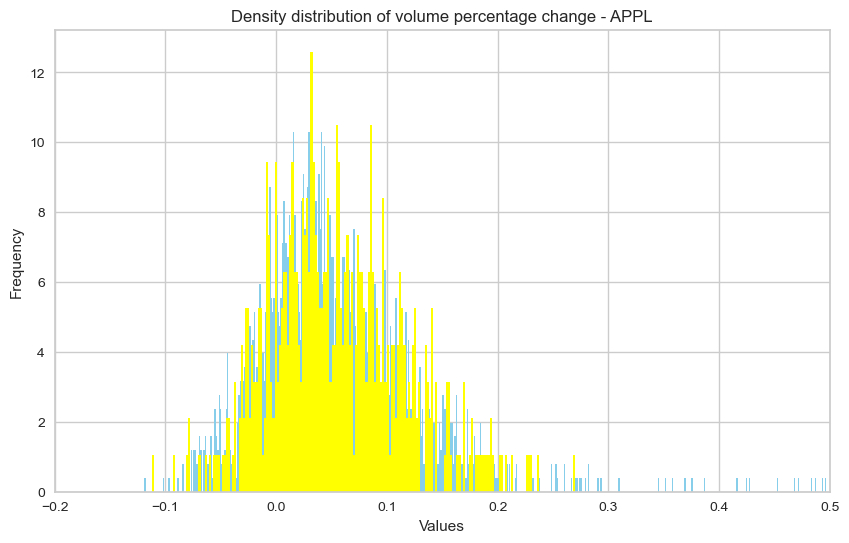

In [176]:
plt.figure(figsize=(10,6))
plt.hist(Y_train_appl_rfr1, bins=500, color='skyblue', density=True)
plt.hist(Y_test_appl_rfr1, bins=200, color='yellow', density=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(-0.2,0.5)
plt.title('Density distribution of volume percentage change - APPL')
plt.show()

In [212]:
X_train_appl_rfr1.columns

Index(['Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl',
       'ATR_appl'],
      dtype='object')

In [213]:
X_test_appl_rfr1.columns

Index(['Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq', 'Volume_nasdaq',
       'Vix_index', 'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl',
       'ATR_appl'],
      dtype='object')

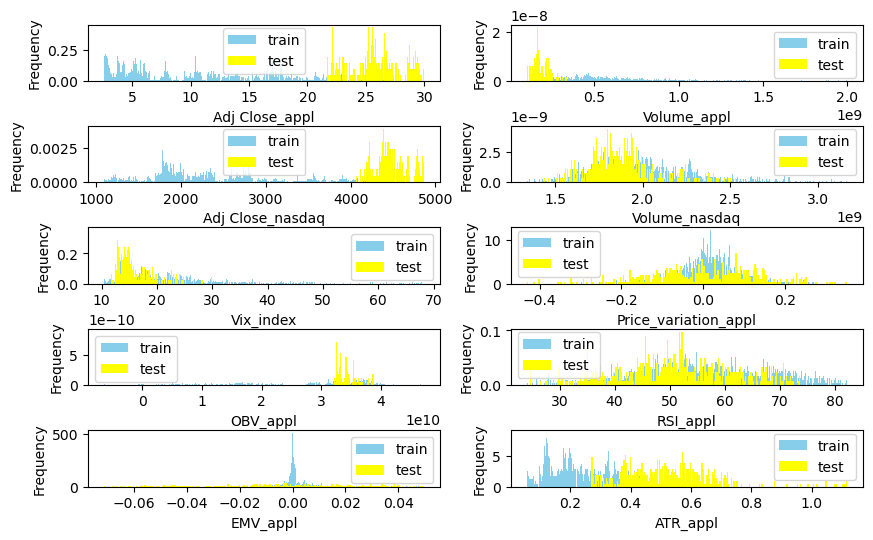

In [214]:

plt.subplot(5, 2, 1)
plt.hist(X_train_appl_rfr1['Adj Close_appl'], bins=500, color='skyblue', density=True, label='train')
plt.hist(X_test_appl_rfr1['Adj Close_appl'], bins=200, color='yellow', density=True, label='test')
plt.xlabel('Adj Close_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 2)
plt.hist(X_train_appl_rfr1['Volume_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['Volume_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Volume_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 3)
plt.hist(X_train_appl_rfr1['Adj Close_nasdaq'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['Adj Close_nasdaq'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Adj Close_nasdaq')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 4)
plt.hist(X_train_appl_rfr1['Volume_nasdaq'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['Volume_nasdaq'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Volume_nasdaq')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 5)
plt.hist(X_train_appl_rfr1['Vix_index'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['Vix_index'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Vix_index')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 6)
plt.hist(X_train_appl_rfr1['Price_variation_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['Price_variation_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('Price_variation_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 7)
plt.hist(X_train_appl_rfr1['OBV_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['OBV_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('OBV_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 8)
plt.hist(X_train_appl_rfr1['RSI_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['RSI_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('RSI_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 9)
plt.hist(X_train_appl_rfr1['EMV_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['EMV_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('EMV_appl')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(5, 2, 10)
plt.hist(X_train_appl_rfr1['ATR_appl'], bins=500, color='skyblue', density=True,label='train')
plt.hist(X_test_appl_rfr1['ATR_appl'], bins=200, color='yellow', density=True,label='test')
plt.xlabel('ATR_appl')
plt.ylabel('Frequency')
plt.legend()


plt.subplots_adjust(hspace=0.8)

plt.show()

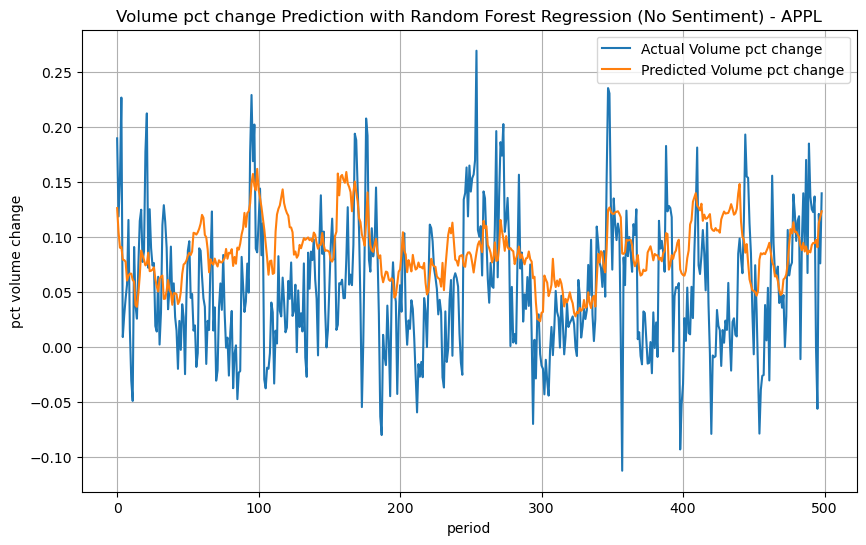

In [277]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_rfr1, label='Actual Volume pct change')
plt.plot(y_pred_rfr1_appl, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Random Forest Regression (No Sentiment) - APPL')
plt.savefig(fig_dir+'RFR_APPL_Sent.png', transparent=False)
plt.show()

In [278]:
# Calculate MAE and RMSE
mae_rfr1_appl=metrics.mean_absolute_error(Y_test_appl_rfr1,y_pred_rfr1_appl)
rmse_rfr1_appl=np.sqrt(mean_squared_error(Y_test_appl_rfr1, y_pred_rfr1_appl))
mad_rfr1_appl=mda(Y_test_appl_rfr1,y_pred_rfr1_appl)
print("Test MAE: ",mae_rfr1_appl)
print("Test RMSE: ",rmse_rfr1_appl)
print("Test MDA: ",mad_rfr1_appl)

Test MAE:  0.05356326676847407
Test RMSE:  0.0662622771648692
Test MDA:  0.536144578313253


Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

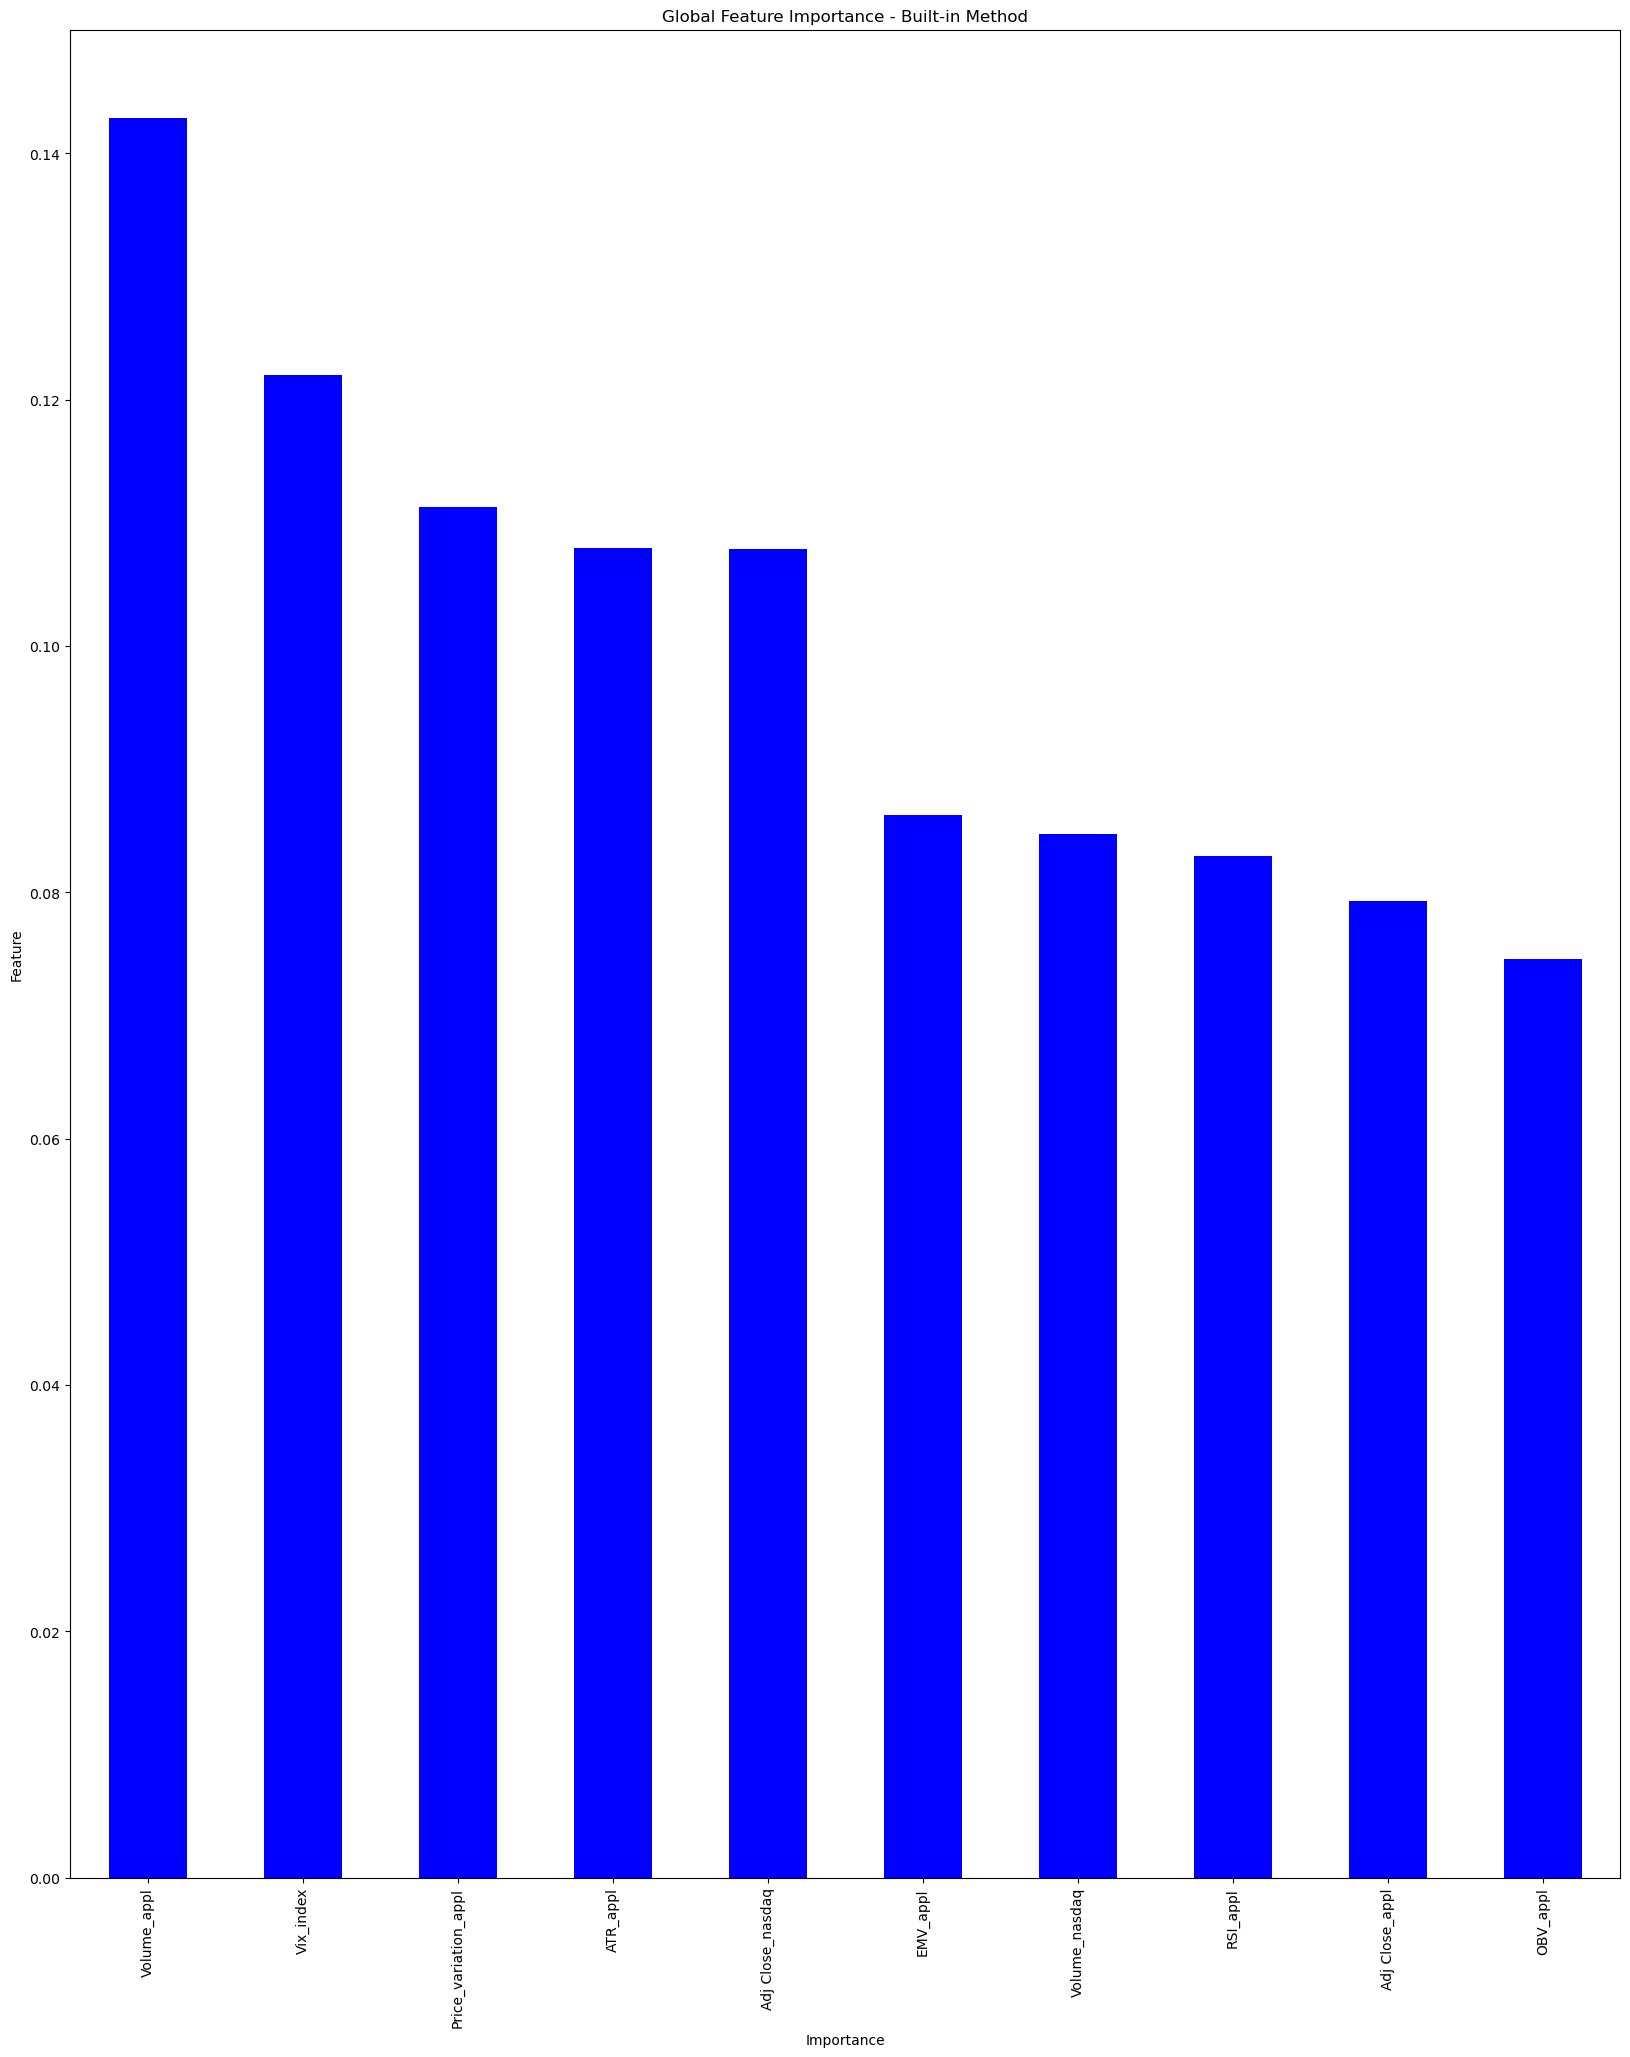

In [280]:
#Computing the feature importance
importances_rfr1_appl = pd.Series(rfr1_model_appl.feature_importances_, index=X_train_appl_rfr1.columns)
importances_rfr1_appl.sort_values(ascending=False, inplace=True)
importances_rfr1_appl.plot.bar(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


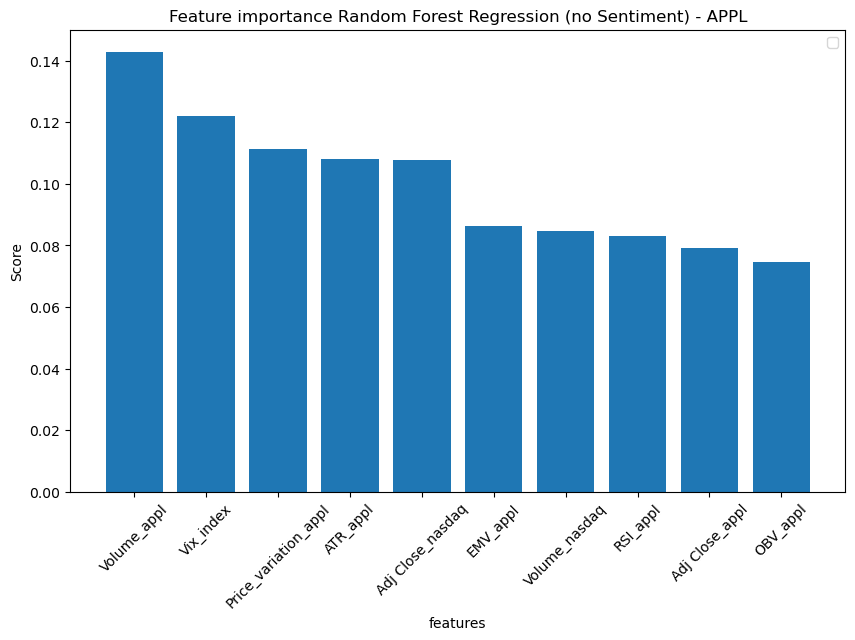

In [282]:
plt.figure(figsize=(10, 6))
plt.bar(importances_rfr1_appl.index, importances_rfr1_appl.values)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Random Forest Regression (no Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'RFR_APPL_FI_NoSent.png', transparent=False)
plt.show()

#### 11.5.3.2 APPL RFR2 (tesla news included)

In [283]:
df_appl_hist_rfr2=df_appl_hist_merged_roll_f.copy()

In [284]:
# Split the data into training and testing sets
train_appl_size_rfr2 = int(0.8 * len(df_appl_hist_rfr2))
train_appl_data_rfr2 = df_appl_hist_rfr2[:train_appl_size_rfr2].reset_index().drop(columns=['index'])
test_appl_data_rfr2 = df_appl_hist_rfr2[train_appl_size_rfr2:].reset_index().drop(columns=['index'])


X_train_appl_rfr2, Y_train_appl_rfr2= train_appl_data_rfr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), train_appl_data_rfr2['pct_change_Volume_appl']
X_test_appl_rfr2, Y_test_appl_rfr2= test_appl_data_rfr2.drop(columns=['Id','pct_change_Volume_appl'], axis=1), test_appl_data_rfr2['pct_change_Volume_appl']

In [285]:
#initializing the multiple SVR model and model fitting
rfr2_model_appl = RandomForestRegressor(n_estimators=200, random_state=42)
rfr2_model_appl.fit(X_train_appl_rfr2, Y_train_appl_rfr2)

RandomForestRegressor(n_estimators=200, random_state=42)

In [286]:
# Make predictions on the test set
y_pred_rfr2_appl = rfr2_model_appl.predict(X_test_appl_rfr2)

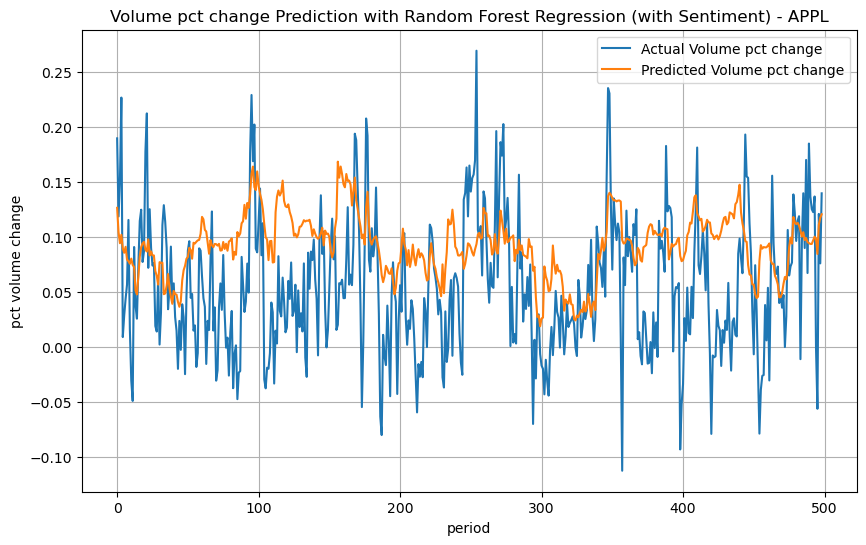

In [291]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Y_test_appl_rfr2, label='Actual Volume pct change')
plt.plot(y_pred_rfr2_appl, label='Predicted Volume pct change')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with Random Forest Regression (with Sentiment) - APPL')
plt.savefig(fig_dir+'RFR_APPL_Sent.png', transparent=False)
plt.show()

In [292]:
# Calculate MAE and RMSE
mae_rfr2_appl=metrics.mean_absolute_error(Y_test_appl_rfr2,y_pred_rfr2_appl)
rmse_rfr2_appl=np.sqrt(mean_squared_error(Y_test_appl_rfr2, y_pred_rfr2_appl))
mad_rfr2_appl=mda(Y_test_appl_rfr2,y_pred_rfr2_appl)
print("Test MAE: ",mae_rfr2_appl)
print("Test RMSE: ",rmse_rfr2_appl)
print("Test MDA: ",mad_rfr2_appl)

Test MAE:  0.05628092872030169
Test RMSE:  0.0693483861728128
Test MDA:  0.5441767068273092


Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

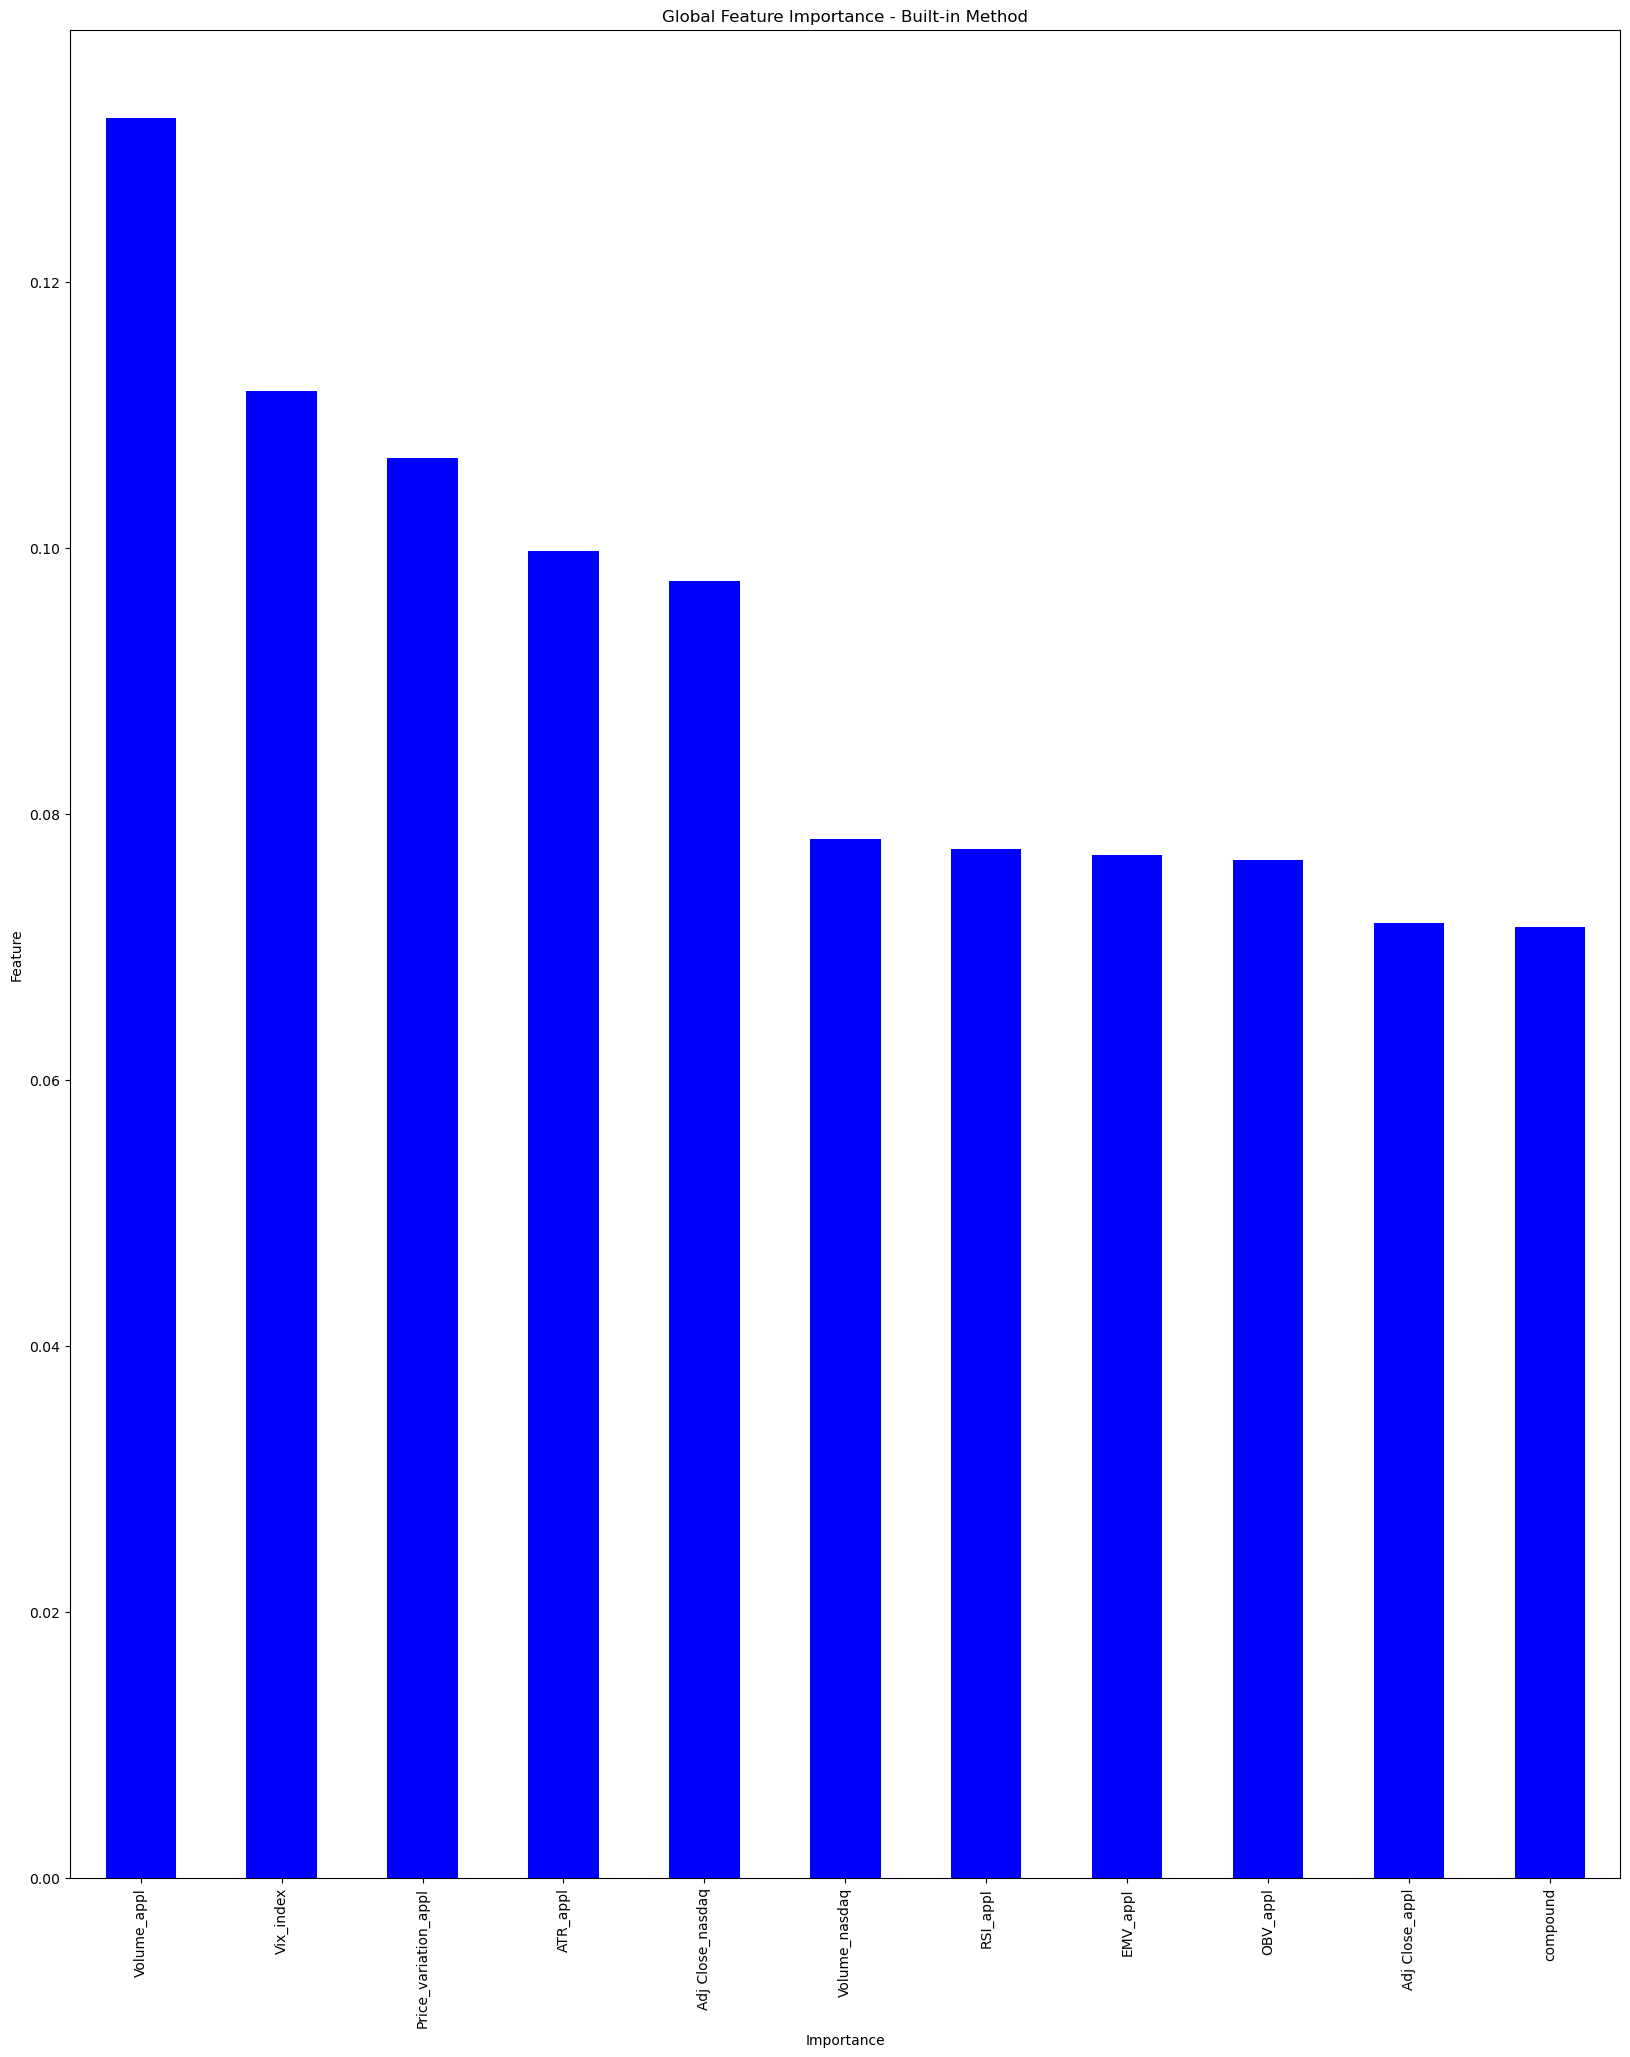

In [294]:
#Computing the feature importance
importances_rfr2_appl = pd.Series(rfr2_model_appl.feature_importances_, index=X_train_appl_rfr2.columns)
importances_rfr2_appl.sort_values(ascending=False, inplace=True)
importances_rfr2_appl.plot.bar(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


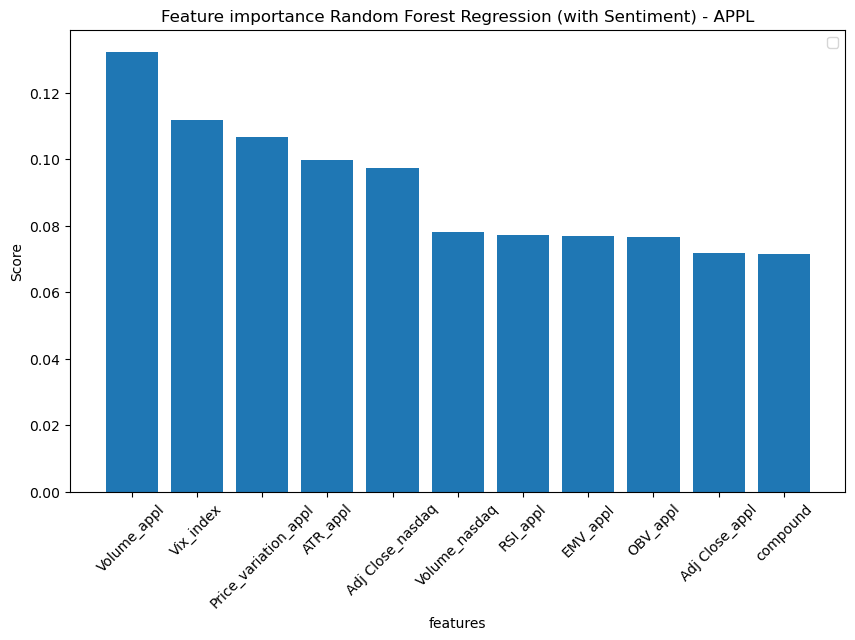

In [296]:
plt.figure(figsize=(10, 6))
plt.bar(importances_rfr2_appl.index, importances_rfr2_appl.values)
plt.xlabel('features')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Feature importance Random Forest Regression (with Sentiment) - APPL')
plt.xticks(rotation = 45)
plt.savefig(fig_dir+'RFR_APPL_FI_Sent.png', transparent=False)
plt.show()

### 11.6 LSTM
Long Short-Term Memory Networks is a deep learning, sequential neural network that allows information to persist. It is a special type of Recurrent Neural Network which is capable of handling the vanishing gradient problem faced by RNN. It excels at capturing long-term dependencies, making it ideal for sequence prediction tasks.  LSTM incorporates feedback connections, allowing it to process entire sequences of data, not just individual data points. This makes it highly effective in understanding and predicting patterns in sequential data like time series, text, and speech.

In [71]:
#Import the LSTM package

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler

### 11.6.1 TSLA Long Short-Term Memory

#### 11.6.1.1 TSLA LSTM1 (no tesla news included)

In [72]:
df_lstm1=df_tsla_hist_merged_roll_f.copy()
df_tsla_hist_merged_roll_f.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'sent_score_tsla', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_TSLA',
       'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla', 'ATR_tsla',
       'Id'],
      dtype='object')

In [73]:
df_lstm1.shape

(3191, 13)

In [74]:
df_lstm1.to_csv('df_lstm1.csv')

In [76]:
df_appl_hist_merged_roll_f.columns

Index(['compound', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_appl',
       'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl', 'ATR_appl',
       'Id'],
      dtype='object')

In [75]:
# Split the data into training and testing sets
train_lstm1_size = int(0.8 * len(df_lstm1))
train_lstm1 = df_lstm1[:train_lstm1_size].reset_index().drop(columns=['index'])
test_lstm1 = df_lstm1[train_lstm1_size:].reset_index().drop(columns=['index'])

In [76]:
print(train_lstm1.shape,test_lstm1.shape)

(2552, 13) (639, 13)


In [77]:
train_lstm1.drop(columns=['sent_score_tsla'], axis=1, inplace=True)
train_lstm1 = train_lstm1[['Id','pct_change_Volume_TSLA', 'Adj Close_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq','Vix_index',
                    'Volume_tsla','Price_variation_tsla','OBV_tsla','RSI_tsla','EMV_tsla','ATR_tsla']]

In [78]:
#separate dates for future plots
train_dates1=train_lstm1['Id']
#variable for trainig
cols1=list(train_lstm1)[1:12]

In [79]:
cols2=list(train_lstm1)[2:12]
cols2

['Adj Close_tsla',
 'Adj Close_nasdaq',
 'Volume_nasdaq',
 'Vix_index',
 'Volume_tsla',
 'Price_variation_tsla',
 'OBV_tsla',
 'RSI_tsla',
 'EMV_tsla',
 'ATR_tsla']

In [80]:
#separate dates for future plots
test_dates1=test_lstm1['Id']
#variable for trainig
cols1_test=list(test_lstm1)[1:12]

In [81]:
cols2_test=list(test_lstm1)[2:12]
cols2_test

['sent_score_tsla',
 'Adj Close_nasdaq',
 'Volume_nasdaq',
 'Vix_index',
 'pct_change_Volume_TSLA',
 'Price_variation_tsla',
 'OBV_tsla',
 'RSI_tsla',
 'EMV_tsla',
 'ATR_tsla']

In [82]:
#set content to float type so we don't loose any information during normalization.
df_for_training1=train_lstm1[cols1].astype(float)

#Normalize the dataset
scaler1=StandardScaler()
scaler1=scaler1.fit(df_for_training1)
df_for_training_scaled1=scaler1.transform(df_for_training1)

In [83]:
trainX1=[]
trainY1=[]

#Number of days we want to predict in the future
n_future1=1
#Number of past days we want to use to predict the future
n_past1=14

for i in range (n_past1, len(df_for_training_scaled1)-n_future1+1):
  trainX1.append(df_for_training_scaled1[i-n_past1:i, 0:df_for_training1.shape[1]])
  trainY1.append(df_for_training_scaled1[i+n_future1-1:i+n_future1,0])
  
trainX1, trainY1=np.array(trainX1), np.array(trainY1)

print('trainX1 shape =={}.'.format(trainX1.shape))
print('trainY1 shape =={}.'.format(trainY1.shape))

trainX1 shape ==(2538, 14, 11).
trainY1 shape ==(2538, 1).


In [84]:
#set content to float type so we don't loose any information during normalization.
df_for_test1=test_lstm1[cols1_test].astype(float)

#Normalize the dataset
scaler1_test=StandardScaler()
scaler1_test=scaler1_test.fit(df_for_test1)
df_for_test_scaled1=scaler1_test.transform(df_for_test1)

In [85]:
testX1=[]
testY1=[]

#Number of days we want to predict in the future
n_future1=1
#Number of past days we want to use to predict the future
n_past1=14

for i in range (n_past1, len(df_for_test_scaled1)-n_future1+1):
  testX1.append(df_for_test_scaled1[i-n_past1:i, 0:df_for_test1.shape[1]])
  testY1.append(df_for_test_scaled1[i+n_future1-1:i+n_future1,0])
  
testX1, testY1=np.array(testX1), np.array(testY1)

print('testX1 shape =={}.'.format(testX1.shape))
print('testY1 shape =={}.'.format(testY1.shape))

testX1 shape ==(625, 14, 11).
testY1 shape ==(625, 1).


In [86]:
#Define the LSTM architecture
model1=Sequential()
model1.add(LSTM(64, activation='relu',input_shape=(trainX1.shape[1],trainX1.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY1.shape[1]))

model1.compile(optimizer='adam',loss='mse')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            19456     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________


In [87]:
#fit the model
history1=model1.fit(trainX1, trainY1, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
143/143 [==============================] - 7s 20ms/step - loss: 0.8129 - val_loss: 1.4361
Epoch 2/100
143/143 [==============================] - 2s 15ms/step - loss: 0.5225 - val_loss: 0.9371
Epoch 3/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4437 - val_loss: 3.6236
Epoch 4/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4059 - val_loss: 0.5801
Epoch 5/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3828 - val_loss: 0.6689
Epoch 6/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4116 - val_loss: 2.0097
Epoch 7/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3633 - val_loss: 0.3152
Epoch 8/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3858 - val_loss: 0.4197
Epoch 9/100
143/143 [==============================] - 2s 15ms/step - loss: 0.3561 - val_loss: 0.8180
Epoch 10/100
143/143 [==============================] - 2s 15ms/step - loss: 0.382

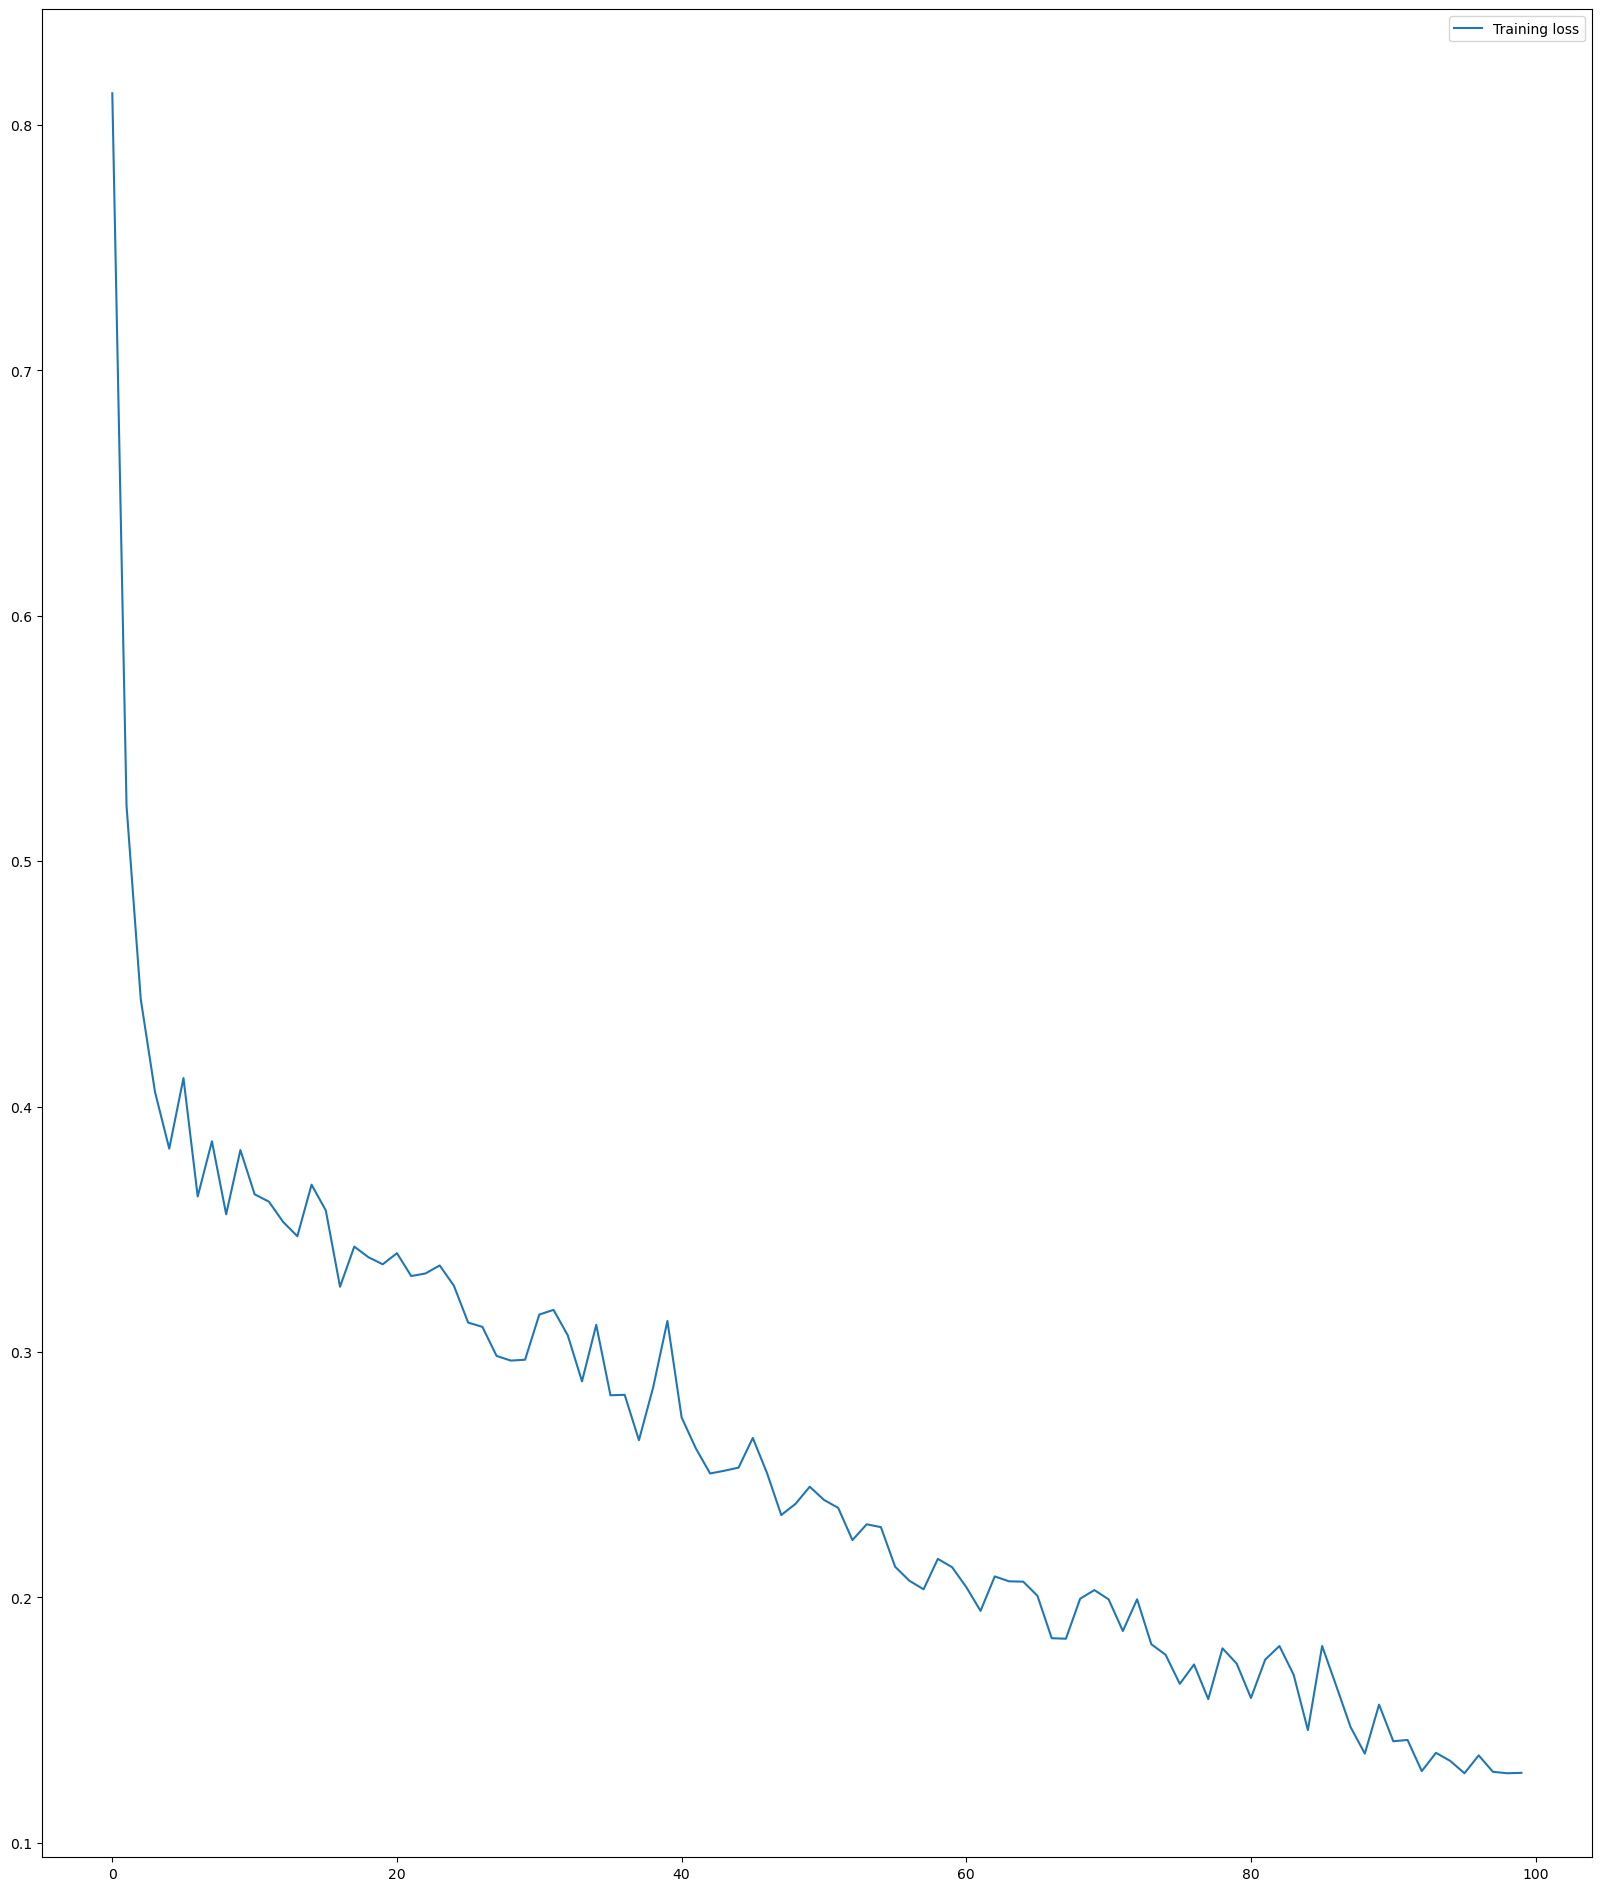

In [91]:
#Plot the Train and test loss during epoch
plt.plot(history1.history['loss'], label='Training loss')
#plt.plot(history1.history['val_loss'], label='Validation loss')
plt.legend()

In [92]:
#model1.save('my_model1.h5') 

In [93]:
forecast1=model1.predict(testX1)

20/20 [==============================] - 1s 9ms/step


In [94]:
forecast_copies1=np.repeat(forecast1, df_for_test1.shape[1], axis=-1)

y_pred_future1=scaler1_test.inverse_transform(forecast_copies1)[:,0]

#forecast_dates1_test=[]

#for time_i in forecast_period_dates1:
  #forecast_dates1_test.append(time_i.date)
  

#df_forecast1_test=pd.DataFrame({'date':np.array(forecast_dates1),'pct_change_Volume_TSLA':y_pred_future1})

In [95]:
#y_pred_future1

In [96]:
actualX_test = test_lstm1.iloc[14:]
actualX_test

Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
14       144.612665  134894880.0         0.041512      11657.584082   
15       144.636664  130374150.0         0.053627      11689.121094   
16       145.455998  118777920.0         0.047437      11748.769043   
17       145.627666  116247420.0         0.057298      11761.298047   
18       145.892999  111000420.0         0.061615      11799.955078   
..              ...          ...              ...               ...   
634      194.375002  135746050.0        -0.013434      12822.738086   
635      193.875002  133053290.0        -0.056066      12858.602051   
636      193.312003  131403900.0        -0.069168      12898.607031   
637      192.596002  129370300.0        -0.030865      12931.943945   
638      192.006001  131954520.0        -0.030030      12960.362012   

     Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
14    3.760443e+09     26.873                0.033583              1.076334   
15    3.692380e+09     26.900                0.002695              0.023999   
16    3.635927e+09     26.878               -0.046197              0.819334   
17    3.621276e+09     27.000                0.001907              0.171668   
18    3.533184e+09     26.987               -0.020747              0.265333   
..             ...        ...                     ...                   ...   
634   4.702981e+09     20.395                0.046903              1.152000   
635   4.649870e+09     20.157                0.003212             -0.500000   
636   4.589570e+09     19.839                0.011044             -0.562999   
637   4.484104e+09     19.418                0.007668             -0.716000   
638   4.481146e+09     19.141                0.041776             -0.590001   

         OBV_tsla   RSI_tsla  EMV_tsla  ATR_tsla    Id  
14   1.363888e+10  55.033872 -1.186300  7.316688  2566  
15   1.367551e+10  54.882136 -1.287140  6.914402  2567  
16   1.372373e+10  55.163353 -1.058180  6.576736  2568  
17   1.374765e+10  55.006863 -0.511802  6.282307  2569  
18   1.377681e+10  54.846581 -0.038476  5.985474  2570  
..            ...        ...       ...       ...   ...  
634  1.877270e+10  54.917432  3.055642  8.525787  3186  
635  1.877348e+10  54.314307  3.924793  8.476073  3187  
636  1.877592e+10  53.687692  3.871187  8.411930  3188  
637  1.875154e+10  52.967639  4.020229  8.309930  3189  
638  1.872459e+10  52.340403  4.171237  8.207859  3190  

[625 rows x 13 columns]

In [97]:
actual1=actualX_test['pct_change_Volume_TSLA'].reset_index()
predicted1=pd.DataFrame(y_pred_future1)

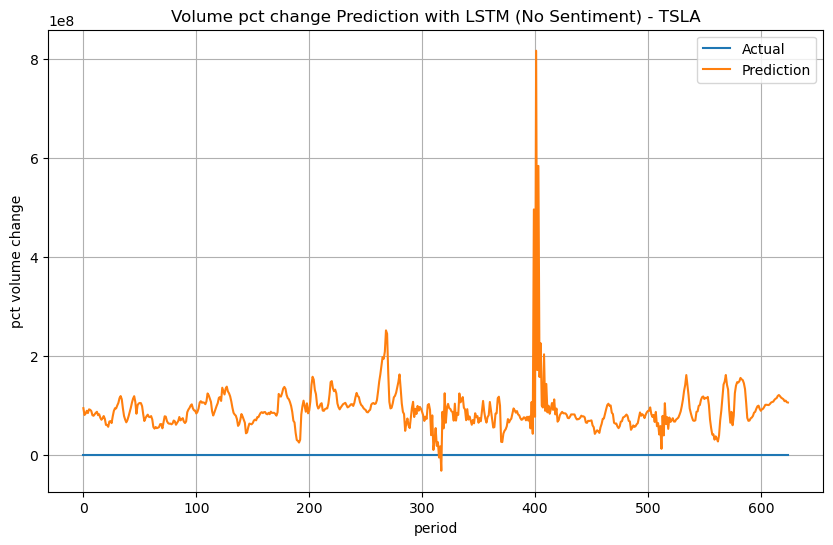

In [98]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(actual1['pct_change_Volume_TSLA'], label='Actual')
plt.plot(y_pred_future1, label='Prediction')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with LSTM (No Sentiment) - TSLA')
#plt.savefig(fig_dir+'RFR_APPL_Sent.png', transparent=False)
plt.legend()

In [130]:
# Calculate MAE and RMSE
from sklearn import metrics
mae_lstm1=metrics.mean_absolute_error(actual1['pct_change_Volume_TSLA'], predicted1)
rmse_lstm1=np.sqrt(metrics.mean_squared_error(actual1['pct_change_Volume_TSLA'], predicted1))
mad_lstm1=mda(actual1['pct_change_Volume_TSLA'],predicted1[0])
print(f'MAE is :', mae_lstm1)
print(f'RMSE is :', rmse_lstm1)
print(f'MDAE is :', mad_lstm1)

MAE is : 0.05643482455754057
RMSE is : 0.091400339548878
MDAE is : 0.46474358974358976


In [137]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

In [131]:
import shap



In [136]:
import tensorflow as tf
import sys
import google.protobuf
import h5py

assert tf.__version__ == '1.14.0'
assert sys.version_info[0] == 3 and sys.version_info[1] == 7
assert google.protobuf.__version__ == '3.20.0'
assert h5py.__version__ == '2.10.0'

AssertionError: 

In [132]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [138]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model1, trainX1)


In [139]:
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(testX1)


StagingError: in user code:

    File "C:\Users\loren\anaconda3\envs\myenvpython\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 259, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [ ]:

# init the JS visualization code
shap.initjs()

In [101]:
df_lstm1.drop(columns=['sent_score_tsla'], axis=1, inplace=True)
df_lstm1 = df_lstm1[['Id','pct_change_Volume_TSLA', 'Adj Close_tsla', 'Adj Close_nasdaq', 'Volume_nasdaq','Vix_index',
                    'Volume_tsla','Price_variation_tsla','OBV_tsla','RSI_tsla','EMV_tsla','ATR_tsla']]

In [102]:
#separate dates for future plots
train_dates1=df_lstm1['Id']
#variable for trainig
cols1=list(df_lstm1)[1:12]

In [103]:
cols2=list(df_lstm1)[2:12]
cols2

['Adj Close_tsla',
 'Adj Close_nasdaq',
 'Volume_nasdaq',
 'Vix_index',
 'Volume_tsla',
 'Price_variation_tsla',
 'OBV_tsla',
 'RSI_tsla',
 'EMV_tsla',
 'ATR_tsla']

In [104]:
#set content to float type so we don't loose any information during normalization.
df_for_training1=df_lstm1[cols1].astype(float)

#Normalize the dataset
scaler1=StandardScaler()
scaler1=scaler1.fit(df_for_training1)
df_for_training_scaled1=scaler1.transform(df_for_training1)

In [105]:
trainX1=[]
trainY1=[]

#Number of days we want to predict in the future
n_future1=1
#Number of past days we want to use to predict the future
n_past1=14

for i in range (n_past1, len(df_for_training_scaled1)-n_future1+1):
  trainX1.append(df_for_training_scaled1[i-n_past1:i, 0:df_for_training1.shape[1]])
  trainY1.append(df_for_training_scaled1[i+n_future1-1:i+n_future1,0])
  
trainX1, trainY1=np.array(trainX1), np.array(trainY1)

print('trainX1 shape =={}.'.format(trainX1.shape))
print('trainY1 shape =={}.'.format(trainY1.shape))

trainX1 shape ==(3177, 14, 11).
trainY1 shape ==(3177, 1).


In [106]:
#Define the LSTM architecture

model1=Sequential()
model1.add(LSTM(64, activation='relu',input_shape=(trainX1.shape[1],trainX1.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY1.shape[1]))

model1.compile(optimizer='adam',loss='mse')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            19456     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________


In [107]:
#fit the model
history1=model1.fit(trainX1, trainY1, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
179/179 [==============================] - 7s 18ms/step - loss: 0.8451 - val_loss: 0.2263
Epoch 2/100
179/179 [==============================] - 3s 15ms/step - loss: 0.5008 - val_loss: 0.1374
Epoch 3/100
179/179 [==============================] - 3s 14ms/step - loss: 0.4428 - val_loss: 0.1032
Epoch 4/100
179/179 [==============================] - 3s 15ms/step - loss: 0.4184 - val_loss: 0.1123
Epoch 5/100
179/179 [==============================] - 3s 15ms/step - loss: 0.4135 - val_loss: 0.0859
Epoch 6/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3867 - val_loss: 0.0847
Epoch 7/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3844 - val_loss: 0.0793
Epoch 8/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3754 - val_loss: 0.0682
Epoch 9/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3610 - val_loss: 0.0779
Epoch 10/100
179/179 [==============================] - 3s 15ms/step - loss: 0.369

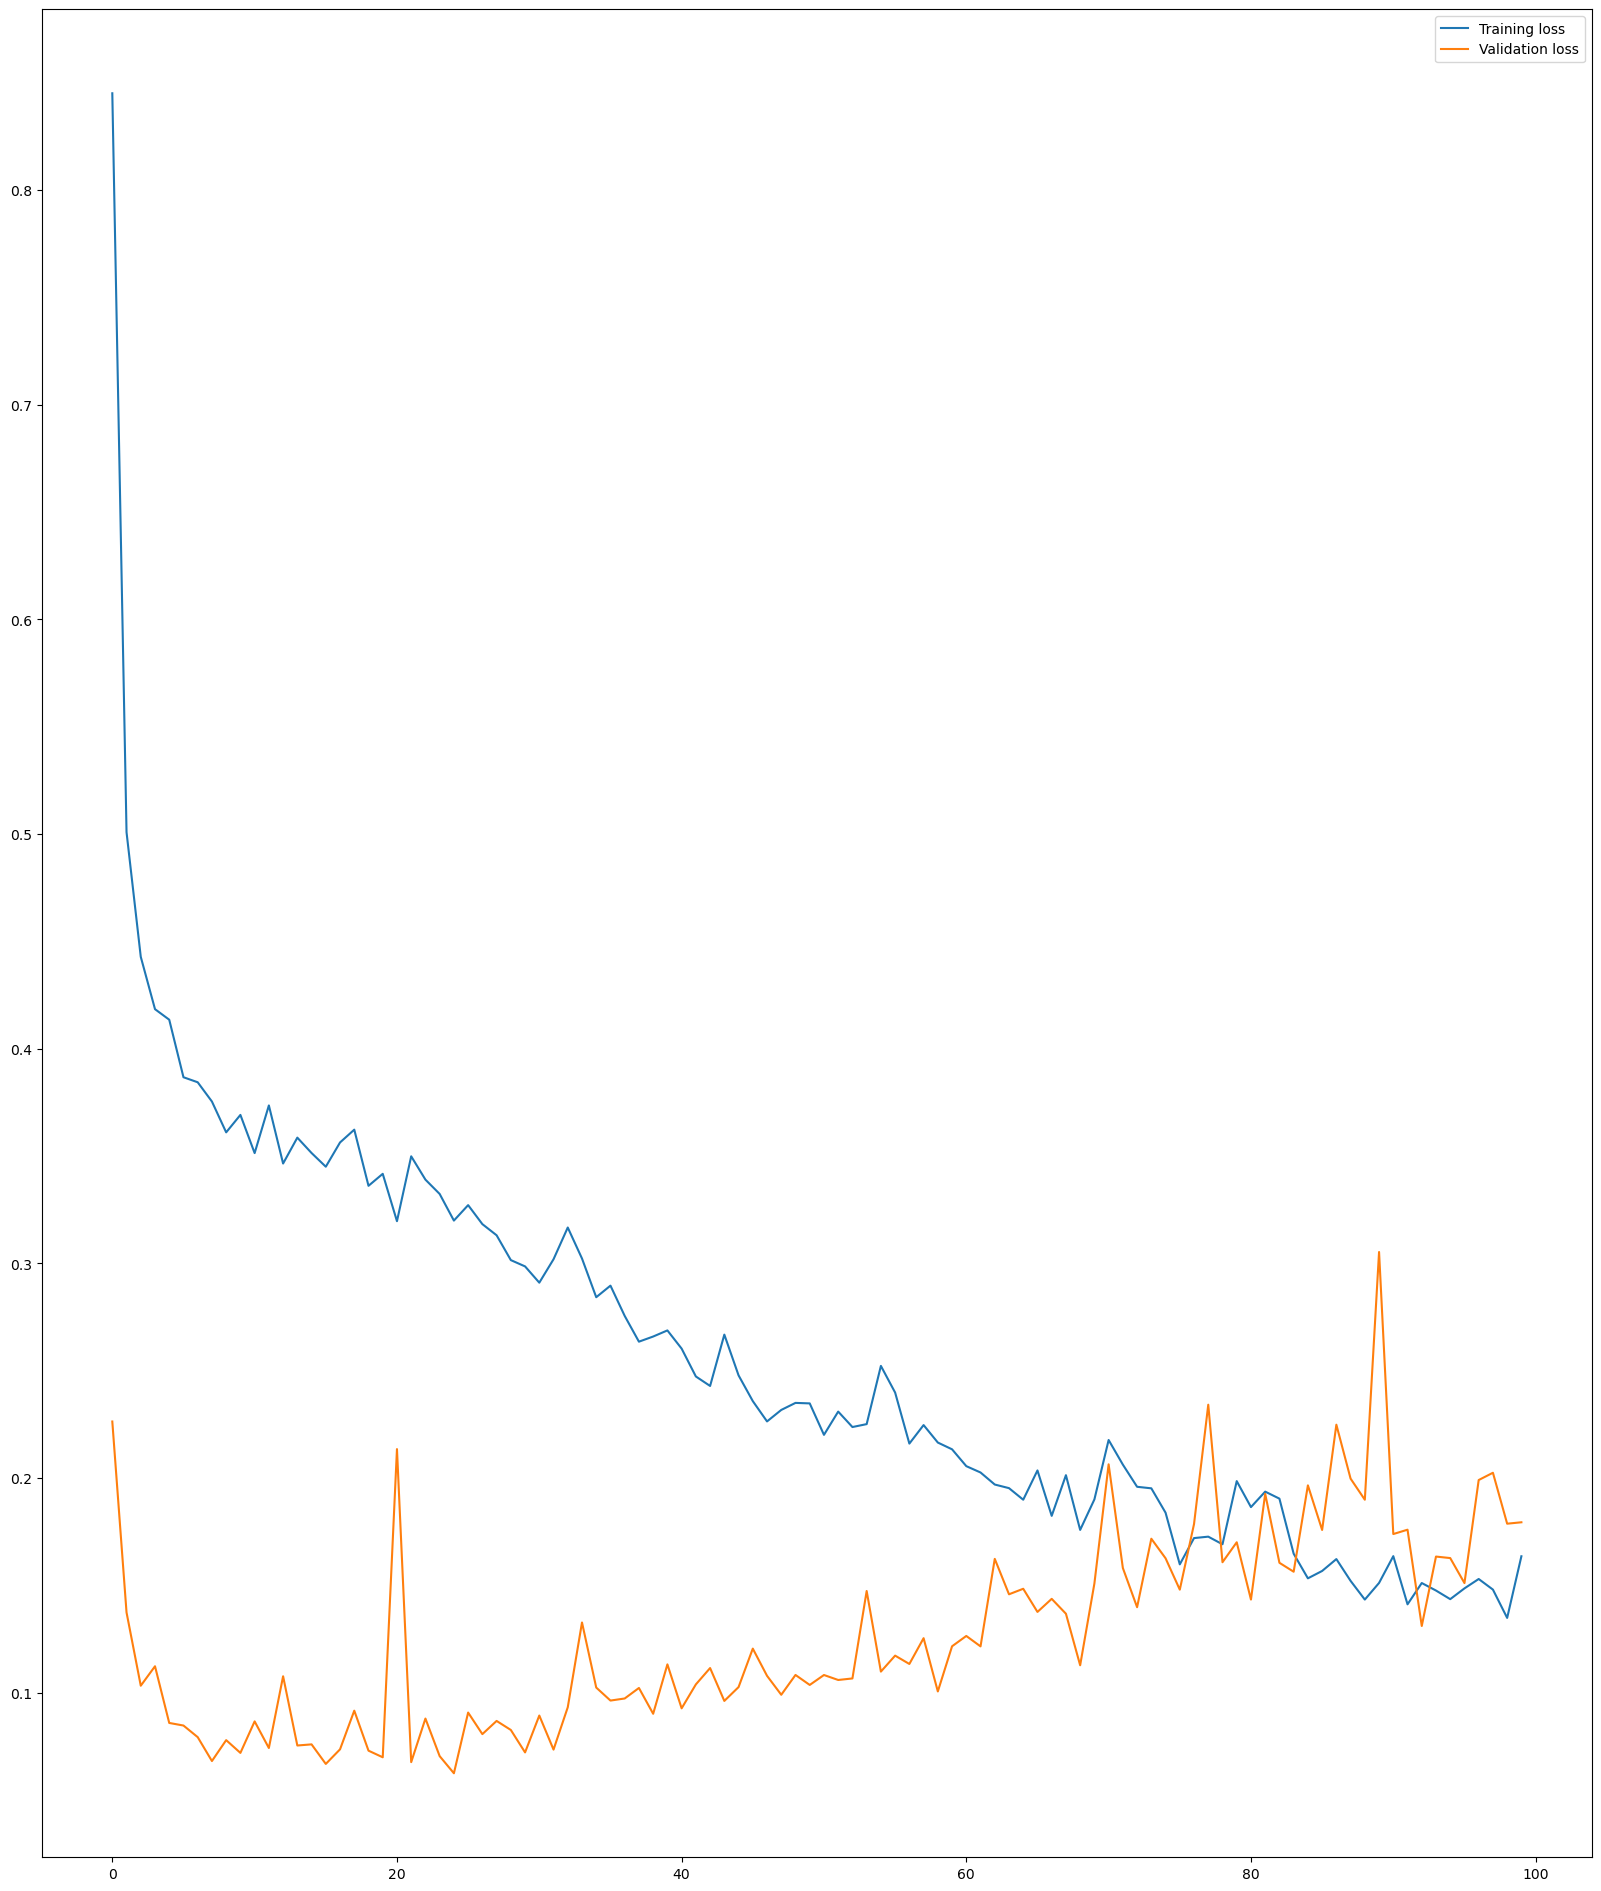

In [108]:
#Plot the Train and test loss during epoch
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.legend()

In [109]:
#Forecasting

#Start with the last date in traingi dataset and predict future values
n_future1=639
forecast_period_dates1=pd.date_range(list(train_dates1)[-1],periods=n_future1, freq='1d').tolist()

forecast1=model1.predict(trainX1[-n_future1:])

20/20 [==============================] - 1s 7ms/step


In [110]:
forecast_copies1=np.repeat(forecast1, df_for_training1.shape[1], axis=-1)

y_pred_future1=scaler1.inverse_transform(forecast_copies1)[:,0]

forecast_dates1=[]

for time_i in forecast_period_dates1:
  forecast_dates1.append(time_i.date)
  

df_forecast1=pd.DataFrame({'date':np.array(forecast_dates1),'pct_change_Volume_TSLA':y_pred_future1})

In [111]:
df_forecast1

date  pct_change_Volume_TSLA
0    <bound method Timestamp.date of Timestamp('197...                0.007504
1    <bound method Timestamp.date of Timestamp('197...                0.038746
2    <bound method Timestamp.date of Timestamp('197...                0.014174
3    <bound method Timestamp.date of Timestamp('197...               -0.020777
4    <bound method Timestamp.date of Timestamp('197...               -0.015882
..                                                 ...                     ...
634  <bound method Timestamp.date of Timestamp('197...                0.047712
635  <bound method Timestamp.date of Timestamp('197...               -0.006309
636  <bound method Timestamp.date of Timestamp('197...               -0.003383
637  <bound method Timestamp.date of Timestamp('197...                0.009365
638  <bound method Timestamp.date of Timestamp('197...                0.004735

[639 rows x 2 columns]

In [112]:
#define actual and predicted dataframe
actual1=df_for_training1[-639:]['pct_change_Volume_TSLA'].reset_index()
predicted1=pd.DataFrame(y_pred_future1)

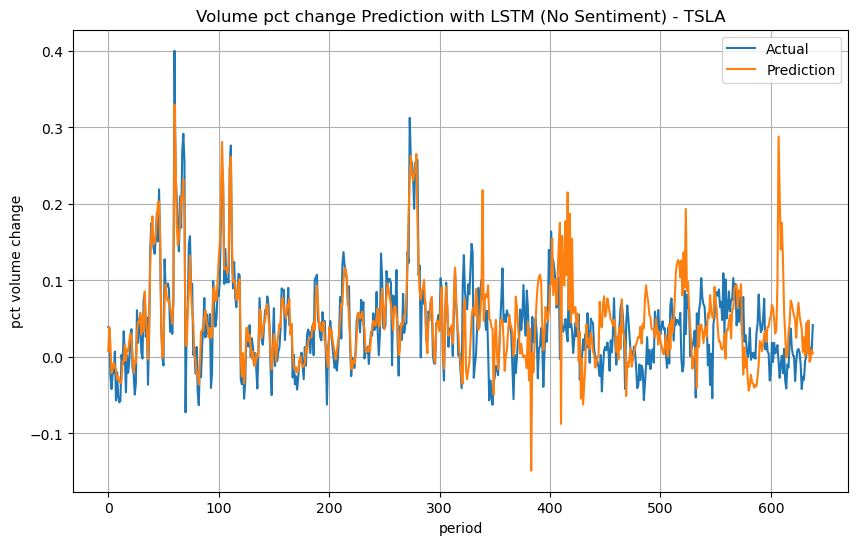

In [131]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(actual1['pct_change_Volume_TSLA'], label='Actual')
plt.plot(predicted1, label='Prediction')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with LSTM (No Sentiment) - TSLA')
plt.savefig(fig_dir+'LSTM_TSLA_NoSent.png', transparent=False)
plt.legend()

In [115]:
# Calculate MAE and RMSE
from sklearn import metrics
mae_lstm1=metrics.mean_absolute_error(actual1['pct_change_Volume_TSLA'], predicted1)
rmse_lstm1=np.sqrt(metrics.mean_squared_error(actual1['pct_change_Volume_TSLA'], predicted1))
mad_lstm1=mda(actual1['pct_change_Volume_TSLA'],predicted1[0])
print(f'MAE is :', mae_lstm1)
print(f'RMSE is :', rmse_lstm1)
print(f'MDAE is :', mad_lstm1)

MAE is : 0.03423726785002658
RMSE is : 0.04837170547008905
MDAE is : 0.5595611285266457


In [116]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [88]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [90]:
trainX1.shape

(3177, 14, 11)

In [ ]:
trainX1=[]
trainY1=[]

#Number of days we want to predict in the future
n_future1=1
#Number of past days we want to use to predict the future
n_past1=14

for i in range (n_past1, len(df_for_training_scaled1)-n_future1+1):
  trainX1.append(df_for_training_scaled1[i-n_past1:i, 0:df_for_training1.shape[1]])
  trainY1.append(df_for_training_scaled1[i+n_future1-1:i+n_future1,0])
  
trainX1, trainY1=np.array(trainX1), np.array(trainY1)

print('trainX1 shape =={}.'.format(trainX1.shape))
print('trainY1 shape =={}.'.format(trainY1.shape))

In [ ]:
explainer = shap.DeepExplainer(model1, trainX1)

In [85]:
from platform import python_version

print(python_version())

3.10.13


In [92]:
!pip install tensorflow==1.14.0

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==1.14.0


In [85]:
model1.save('my_model.h5') 

In [88]:
from tensorflow.keras.models import load_model

SymbolAlreadyExposedError: Symbol Zeros is already exposed as ().

In [87]:
model_lstm1= load_model('my_model.h5')

NameError: name 'load_model' is not defined

In [89]:
import shap

# Create a DeepExplainer for your model
explainer = shap.DeepExplainer(model1, trainX1)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [91]:
# Generate SHAP values for a specific input
x = testX1[0]
shap_values = explainer.shap_values(x)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [208]:
from platform import python_version

print(python_version())

3.10.13


In [203]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [90]:
testX1=trainX1[-n_future1:]
print('testX1 shape =={}.'.format(testX1.shape))

testX1 shape ==(639, 14, 11).


In [204]:
import shap

In [205]:
explainer = shap.DeepExplainer(model1, trainX1)

In [206]:
shap_values = explainer.shap_values(testX1)

StagingError: in user code:

    File "C:\Users\loren\anaconda3\envs\myenvpython\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 259, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [ ]:
shap.initjs()

array([[[-0.52242425,  0.87549503,  1.36047357, ...,  1.88302371,
          0.50786159,  0.97095764],
        [-0.37742193,  0.87838406,  1.36215452, ...,  1.70453199,
          0.45047398,  1.07885923],
        [-0.30187334,  0.8531763 ,  1.34815094, ...,  1.41740105,
          0.36515271,  1.18477992],
        ...,
        [-0.53496178,  0.77149592,  1.16658684, ...,  0.05415872,
         -0.24483062,  1.90181768],
        [-0.74874023,  0.80412752,  1.16955142, ...,  0.16151792,
         -0.24846371,  1.91351617],
        [-0.41007953,  0.80901428,  1.15543214, ...,  0.14944804,
         -0.22313101,  1.90055836]],

       [[-0.37742193,  0.87838406,  1.36215452, ...,  1.70453199,
          0.45047398,  1.07885923],
        [-0.30187334,  0.8531763 ,  1.34815094, ...,  1.41740105,
          0.36515271,  1.18477992],
        [-0.19691569,  0.83985295,  1.33996932, ...,  1.1822104 ,
          0.2848415 ,  1.29448125],
        ...,
        [-0.74874023,  0.80412752,  1.16955142, ...,  

In [212]:
import shap

In [208]:
explainer = shap.Explainer(model1)

In [214]:
#shap_values = explainer.shap_values(trainX1)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
df_forecast1['pct_change_Volume_TSLA']

In [189]:
results = []
print(' Computing LSTM feature importance...')

 Computing LSTM feature importance...


In [198]:
oof_preds = df_forecast1['pct_change_Volume_TSLA']

In [200]:
baseline_mae = np.mean(np.abs( oof_preds-actual1['pct_change_Volume_TSLA']))

In [203]:
results.append({'feature':'BASELINE','mae':baseline_mae})

In [ ]:
COLS = list(train.columns)

In [ ]:
for k in tqdm(range(len(cols1))):
    # SHUFFLE FEATURE K
    save_col = X_valid[:,:,k].copy()
    np.random.shuffle(X_valid[:,:,k])
                        
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = df_forecast1['pct_change_Volume_TSLA'] 
    mae = np.mean(np.abs( oof_preds-y_valid ))
    results.append({'feature':COLS[k],'mae':mae})
    X_valid[:,:,k] = save_col

In [222]:
#import optuna

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

In [216]:
df_lstm1

Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
0           1.389200   11045100.0         0.000000       1885.646008   
1           1.377867   11177550.0         0.000000       1888.396008   
2           1.368867   11013300.0         0.000000       1890.873010   
3           1.358733   12005700.0         0.000000       1891.916003   
4           1.339933   12501300.0         0.000000       1889.192004   
...              ...          ...              ...               ...   
3186      194.375002  135746050.0        -0.013434      12822.738086   
3187      193.875002  133053290.0        -0.056066      12858.602051   
3188      193.312003  131403900.0        -0.069168      12898.607031   
3189      192.596002  129370300.0        -0.030865      12931.943945   
3190      192.006001  131954520.0        -0.030030      12960.362012   

      Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
0      2.069850e+09     23.022                0.054048             -0.003667   
1      2.016453e+09     22.849                0.078988             -0.011333   
2      1.961483e+09     22.790                0.047436             -0.009000   
3      1.958903e+09     22.708                0.137898             -0.010133   
4      2.001497e+09     22.822                0.124756             -0.018800   
...             ...        ...                     ...                   ...   
3186   4.702981e+09     20.395                0.046903              1.152000   
3187   4.649870e+09     20.157                0.003212             -0.500000   
3188   4.589570e+09     19.839                0.011044             -0.562999   
3189   4.484104e+09     19.418                0.007668             -0.716000   
3190   4.481146e+09     19.141                0.041776             -0.590001   

          OBV_tsla   RSI_tsla  EMV_tsla  ATR_tsla    Id  
0    -6.601770e+07  57.500583  0.000613  0.086819     0  
1    -6.994785e+07  55.908102 -0.000123  0.082114     1  
2    -7.127565e+07  54.606542 -0.001014  0.078219     2  
3    -7.359585e+07  53.290087 -0.001844  0.074400     3  
4    -7.781325e+07  51.285659 -0.002988  0.071395     4  
...            ...        ...       ...       ...   ...  
3186  1.877270e+10  54.917432  3.055642  8.525787  3186  
3187  1.877348e+10  54.314307  3.924793  8.476073  3187  
3188  1.877592e+10  53.687692  3.871187  8.411930  3188  
3189  1.875154e+10  52.967639  4.020229  8.309930  3189  
3190  1.872459e+10  52.340403  4.171237  8.207859  3190  

[3191 rows x 13 columns]

In [217]:
# Split the data into training and testing sets
train_lstm1_size = int(0.8 * len(df_lstm1))
train_lstm1 = df_lstm1[:train_lstm1_size].reset_index().drop(columns=['index'])
test_lstm1 = df_lstm1[train_lstm1_size:].reset_index().drop(columns=['index'])

In [218]:
print('Train dataframe shape',train_lstm1.shape)
train_lstm1.head()

Train dataframe shape (2552, 13)


Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
0        1.389200   11045100.0              0.0       1885.646008   
1        1.377867   11177550.0              0.0       1888.396008   
2        1.368867   11013300.0              0.0       1890.873010   
3        1.358733   12005700.0              0.0       1891.916003   
4        1.339933   12501300.0              0.0       1889.192004   

   Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
0   2.069850e+09     23.022                0.054048             -0.003667   
1   2.016453e+09     22.849                0.078988             -0.011333   
2   1.961483e+09     22.790                0.047436             -0.009000   
3   1.958903e+09     22.708                0.137898             -0.010133   
4   2.001497e+09     22.822                0.124756             -0.018800   

     OBV_tsla   RSI_tsla  EMV_tsla  ATR_tsla  Id  
0 -66017700.0  57.500583  0.000613  0.086819   0  
1 -69947850.0  55.908102 -0.000123  0.082114   1  
2 -71275650.0  54.606542 -0.001014  0.078219   2  
3 -73595850.0  53.290087 -0.001844  0.074400   3  
4 -77813250.0  51.285659 -0.002988  0.071395   4

In [224]:
test_lstm1

Adj Close_tsla  Volume_tsla  sent_score_tsla  Adj Close_nasdaq  \
0        139.706998  257158350.0         0.029894      11096.595020   
1        140.860998  259105650.0         0.060349      11102.967969   
2        140.913664  249115350.0         0.053188      11111.637012   
3        139.890665  234991680.0         0.093011      11100.045019   
4        139.465665  227751570.0         0.148038      11117.091016   
..              ...          ...              ...               ...   
634      194.375002  135746050.0        -0.013434      12822.738086   
635      193.875002  133053290.0        -0.056066      12858.602051   
636      193.312003  131403900.0        -0.069168      12898.607031   
637      192.596002  129370300.0        -0.030865      12931.943945   
638      192.006001  131954520.0        -0.030030      12960.362012   

     Volume_nasdaq  Vix_index  pct_change_Volume_TSLA  Price_variation_tsla  \
0     3.993128e+09     26.837                0.038896              0.548334   
1     4.008630e+09     26.788                0.037008              1.154000   
2     3.994043e+09     26.822               -0.025747              0.052666   
3     3.954336e+09     26.890               -0.041939             -1.023000   
4     4.012597e+09     26.923               -0.020355             -0.425000   
..             ...        ...                     ...                   ...   
634   4.702981e+09     20.395                0.046903              1.152000   
635   4.649870e+09     20.157                0.003212             -0.500000   
636   4.589570e+09     19.839                0.011044             -0.562999   
637   4.484104e+09     19.418                0.007668             -0.716000   
638   4.481146e+09     19.141                0.041776             -0.590001   

         OBV_tsla   RSI_tsla  EMV_tsla   ATR_tsla    Id  
0    1.296972e+10  54.869359 -4.973222  12.262685  2552  
1    1.303460e+10  55.091846 -4.183551  12.118866  2553  
2    1.308948e+10  54.797175 -3.239430  11.897108  2554  
3    1.310012e+10  54.060227 -2.823377  11.604303  2555  
4    1.314687e+10  53.655763 -2.463064  11.252032  2556  
..            ...        ...       ...        ...   ...  
634  1.877270e+10  54.917432  3.055642   8.525787  3186  
635  1.877348e+10  54.314307  3.924793   8.476073  3187  
636  1.877592e+10  53.687692  3.871187   8.411930  3188  
637  1.875154e+10  52.967639  4.020229   8.309930  3189  
638  1.872459e+10  52.340403  4.171237   8.207859  3190  

[639 rows x 13 columns]

In [220]:
targets_lstm1 = train_lstm1[['pct_change_Volume_TSLA']].to_numpy().reshape(-1, 58)
train_lstm1.drop(['pct_change_Volume_TSLA'], axis=1, inplace=True)
#test = test.drop(['id', 'breath_id'], axis=1)

COLS = list(train_lstm1.columns)
print('Number of feature columns =', len(COLS) )



Number of feature columns = 12


In [225]:
RS = RobustScaler()
train_lstm1 = RS.fit_transform(train_lstm1)
test_lstm1 = RS.transform(test_lstm1)

train_lstm1 = train_lstm1.reshape(-1, 58, train_lstm1.shape[-1])
test_lstm1 = test_lstm1.reshape(-1, 71, train_lstm1.shape[-1])

X has feature names, but RobustScaler was fitted without feature names


ValueError: X has 13 features, but RobustScaler is expecting 12 features as input.

In [ ]:
X_train_lstm1, Y_train_lstm1= train_lstm1.drop(columns=['Id','pct_change_Volume_appl'], axis=1), train_lstm1['pct_change_Volume_appl']
X_test_lstm1, Y_test_lstm1= test_lstm1.drop(columns=['Id','pct_change_Volume_appl'], axis=1), test_lstm1['pct_change_Volume_appl']

#### 11.6.1.2 TSLA LSTM2 (tesla news included)

In [117]:
df_lstm2=df_tsla_hist_merged_roll_f.copy()
df_lstm2.columns

Index(['Adj Close_tsla', 'Volume_tsla', 'sent_score_tsla', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_TSLA',
       'Price_variation_tsla', 'OBV_tsla', 'RSI_tsla', 'EMV_tsla', 'ATR_tsla',
       'Id'],
      dtype='object')

In [118]:
#df_lstm2.drop(columns=['Adj Close','Volume'], axis=1, inplace=True)
df_lstm2 = df_lstm2[['Id','pct_change_Volume_TSLA', 'Adj Close_tsla', 'sent_score_tsla', 'Adj Close_nasdaq','Volume_nasdaq','Vix_index',
                     'Volume_tsla','Price_variation_tsla','OBV_tsla','RSI_tsla','EMV_tsla','ATR_tsla']]

In [119]:
#separate dates for future plots
train_dates2=df_lstm2['Id']
#variable for trainig
cols2=list(df_lstm2)[1:13]

In [120]:
#set content to float type so we don't loose any information during normalization.
df_for_training2=df_lstm2[cols2].astype(float)

#Normalize the dataset
scaler2=StandardScaler()
scaler2=scaler2.fit(df_for_training2)
df_for_training_scaled2=scaler2.transform(df_for_training2)

In [121]:
trainX2=[]
trainY2=[]

#Number of days we want to predict in the future
n_future2=1
#Number of past days we want to use to predict the future
n_past2=14

for i in range (n_past2, len(df_for_training_scaled2)-n_future2+1):
  trainX2.append(df_for_training_scaled2[i-n_past2:i, 0:df_for_training2.shape[1]])
  trainY2.append(df_for_training_scaled2[i+n_future2-1:i+n_future2,0])
  
trainX2, trainY2=np.array(trainX2), np.array(trainY2)

print('trainX2 shape =={}.'.format(trainX2.shape))
print('trainY2 shape =={}.'.format(trainY2.shape))

trainX2 shape ==(3177, 14, 12).
trainY2 shape ==(3177, 1).


In [122]:
#Define the LSTM architecture

model2=Sequential()
model2.add(LSTM(64, activation='relu',input_shape=(trainX2.shape[1],trainX2.shape[2]), return_sequences=True))
model2.add(LSTM(32, activation='relu', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(trainY2.shape[1]))

model2.compile(optimizer='adam',loss='mse')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            19712     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [123]:
#fit the model
history2=model2.fit(trainX2, trainY2, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
179/179 [==============================] - 7s 18ms/step - loss: 0.7825 - val_loss: 0.1052
Epoch 2/100
179/179 [==============================] - 3s 15ms/step - loss: 0.5320 - val_loss: 0.0977
Epoch 3/100
179/179 [==============================] - 3s 14ms/step - loss: 0.4426 - val_loss: 0.0776
Epoch 4/100
179/179 [==============================] - 3s 15ms/step - loss: 0.4202 - val_loss: 0.0736
Epoch 5/100
179/179 [==============================] - 3s 15ms/step - loss: 0.4007 - val_loss: 0.1809
Epoch 6/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3659 - val_loss: 0.0720
Epoch 7/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3866 - val_loss: 0.0824
Epoch 8/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3575 - val_loss: 0.0757
Epoch 9/100
179/179 [==============================] - 3s 15ms/step - loss: 0.3691 - val_loss: 0.0691
Epoch 10/100
179/179 [==============================] - 3s 15ms/step - loss: 0.349

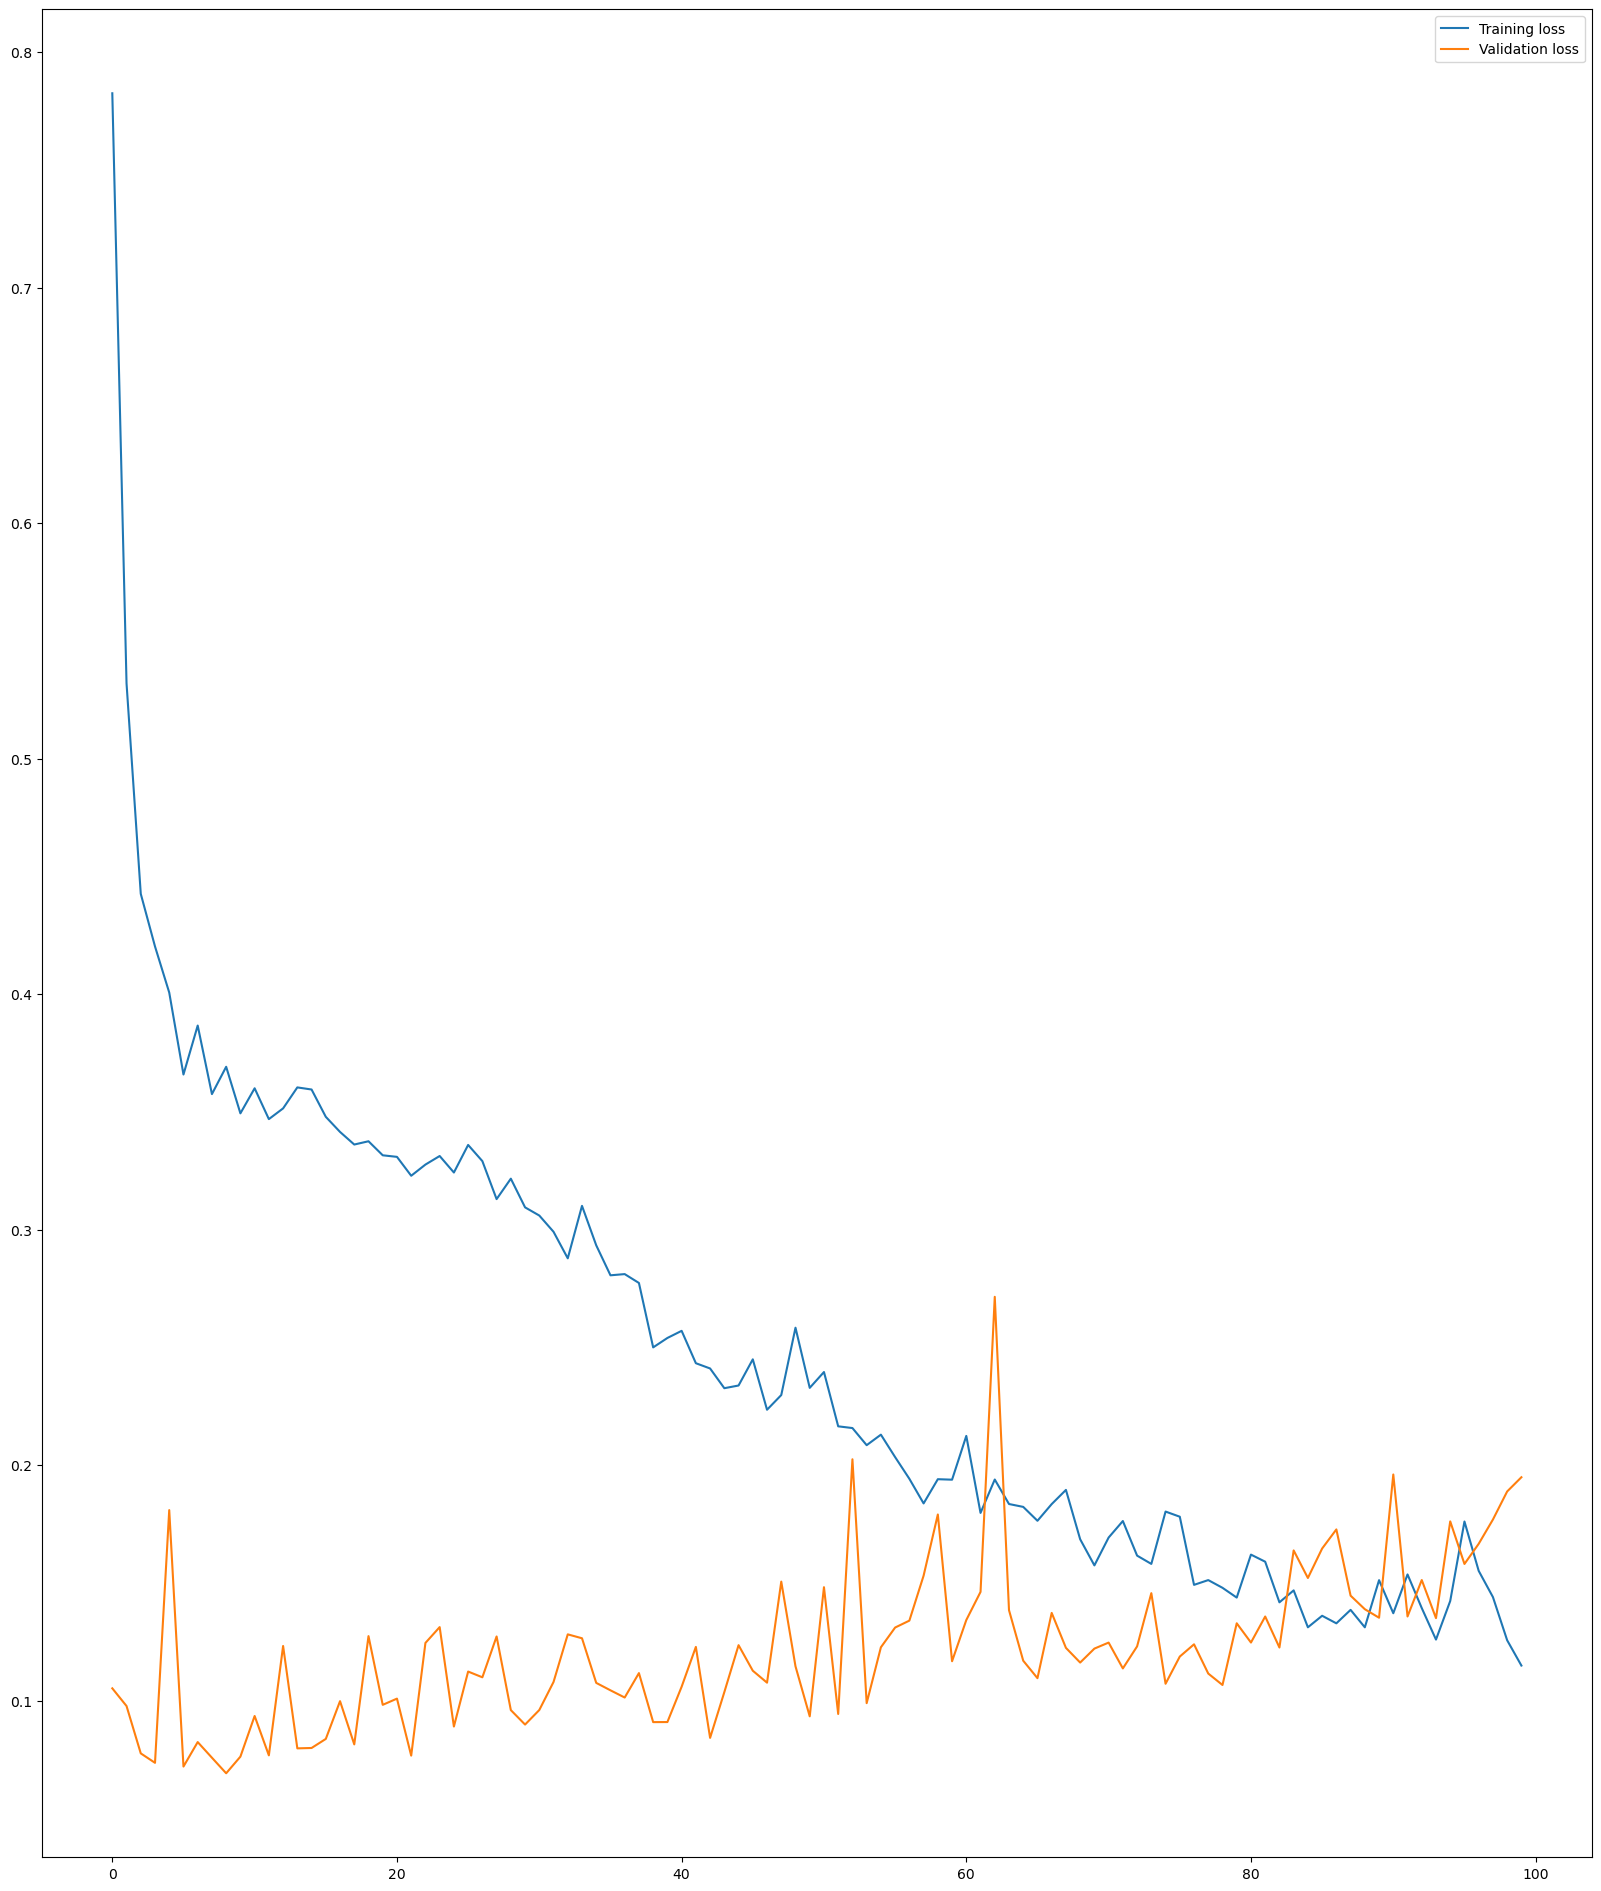

In [125]:
#Plot the Train and test loss during epoch
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()

In [126]:
#Forecasting

#Start with the last date in traingi dataset and predict future values
n_future2=639
forecast_period_dates2=pd.date_range(list(train_dates2)[-1],periods=n_future2, freq='1d').tolist()

forecast2=model2.predict(trainX2[-n_future2:])

20/20 [==============================] - 1s 7ms/step


In [127]:
forecast_copies2=np.repeat(forecast2, df_for_training2.shape[1], axis=-1)

y_pred_future2=scaler2.inverse_transform(forecast_copies2)[:,0]

forecast_dates2=[]

for time_i in forecast_period_dates2:
  forecast_dates2.append(time_i.date)
  

df_forecast2=pd.DataFrame({'id':np.array(forecast_dates2),'pct_change_Volume_TSLA':y_pred_future2})

In [128]:
#define actual and predicted dataframe
actual2=df_for_training2[-639:]['pct_change_Volume_TSLA'].reset_index()
predicted2=pd.DataFrame(y_pred_future2)

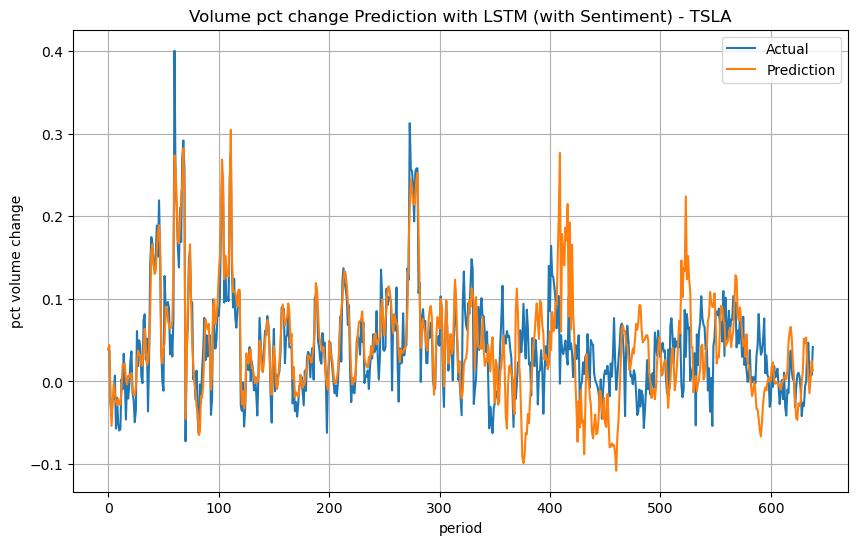

In [130]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(actual2['pct_change_Volume_TSLA'], label='Actual')
plt.plot(predicted2, label='Prediction')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with LSTM (with Sentiment) - TSLA')
plt.savefig(fig_dir+'LSTM_TSLA_Sent.png', transparent=False)
plt.legend()

In [132]:
# Calculate MAE and RMSE
mae_lstm2=metrics.mean_absolute_error(actual2['pct_change_Volume_TSLA'], predicted2)
rmse_lstm2=np.sqrt(metrics.mean_squared_error(actual2['pct_change_Volume_TSLA'], predicted2))
mad_lstm2=mda(actual2['pct_change_Volume_TSLA'],predicted2[0])
print(f'MAE is :', mae_lstm2)
print(f'RMSE is :', rmse_lstm2)
print(f'MDAE is :', mad_lstm2)

MAE is : 0.035599377695582
RMSE is : 0.05019501810158554
MDAE is : 0.5924764890282131


### 11.6.3 APPL Long Short-Term Memory

#### 11.6.3.1 APPL LSTM1 (no appl news included)

In [77]:
df_lstm1_appl=df_appl_hist_merged_roll_f.copy()
df_appl_hist_merged_roll_f.columns

Index(['compound', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_appl',
       'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl', 'ATR_appl',
       'Id'],
      dtype='object')

In [78]:
df_lstm1_appl.to_csv('df_lstm1_appl.csv')

In [74]:
df_lstm1_appl.drop(columns=['compound'], axis=1, inplace=True)
df_lstm1_appl = df_lstm1_appl[['Id','pct_change_Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq', 'Volume_nasdaq','Vix_index',
                    'Volume_appl','Price_variation_appl','OBV_appl','RSI_appl','EMV_appl','ATR_appl']]

In [138]:
#separate dates for future plots
train_dates1_appl=df_lstm1_appl['Id']
#variable for trainig
cols1_appl=list(df_lstm1_appl)[1:12]

In [139]:
#set content to float type so we don't loose any information during normalization.
df_for_training1_appl=df_lstm1_appl[cols1_appl].astype(float)

#Normalize the dataset
scaler1_appl=StandardScaler()
scaler1_appl=scaler1_appl.fit(df_for_training1_appl)
df_for_training_scaled1_appl=scaler1_appl.transform(df_for_training1_appl)

In [140]:
trainX1_appl=[]
trainY1_appl=[]

#Number of days we want to predict in the future
n_future1=1
#Number of past days we want to use to predict the future
n_past1=14

for i in range (n_past1, len(df_for_training_scaled1_appl)-n_future1+1):
  trainX1_appl.append(df_for_training_scaled1_appl[i-n_past1:i, 0:df_for_training1_appl.shape[1]])
  trainY1_appl.append(df_for_training_scaled1_appl[i+n_future1-1:i+n_future1,0])
  
trainX1_appl, trainY1_appl=np.array(trainX1_appl), np.array(trainY1_appl)

print('trainX1_appl shape =={}.'.format(trainX1_appl.shape))
print('trainY1_appl shape =={}.'.format(trainY1_appl.shape))

trainX1_appl shape ==(2479, 14, 11).
trainY1_appl shape ==(2479, 1).


In [141]:
#Define the LSTM architecture

model1_appl=Sequential()
model1_appl.add(LSTM(64, activation='relu',input_shape=(trainX1_appl.shape[1],trainX1_appl.shape[2]), return_sequences=True))
model1_appl.add(LSTM(32, activation='relu', return_sequences=False))
model1_appl.add(Dropout(0.2))
model1_appl.add(Dense(trainY1_appl.shape[1]))

model1_appl.compile(optimizer='adam',loss='mse')
model1_appl.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            19456     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________


In [142]:
#fit the model
history1_appl=model1_appl.fit(trainX1_appl, trainY1_appl, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
140/140 [==============================] - 6s 19ms/step - loss: 0.7985 - val_loss: 0.6485
Epoch 2/100
140/140 [==============================] - 2s 15ms/step - loss: 0.6194 - val_loss: 0.4879
Epoch 3/100
140/140 [==============================] - 2s 15ms/step - loss: 0.5611 - val_loss: 0.5021
Epoch 4/100
140/140 [==============================] - 2s 15ms/step - loss: 0.5152 - val_loss: 0.5116
Epoch 5/100
140/140 [==============================] - 2s 14ms/step - loss: 0.4904 - val_loss: 0.6656
Epoch 6/100
140/140 [==============================] - 2s 15ms/step - loss: 0.4906 - val_loss: 0.4968
Epoch 7/100
140/140 [==============================] - 2s 15ms/step - loss: 0.4847 - val_loss: 0.5492
Epoch 8/100
140/140 [==============================] - 2s 15ms/step - loss: 0.4698 - val_loss: 0.5264
Epoch 9/100
140/140 [==============================] - 2s 15ms/step - loss: 0.4563 - val_loss: 0.5115
Epoch 10/100
140/140 [==============================] - 2s 15ms/step - loss: 0.468

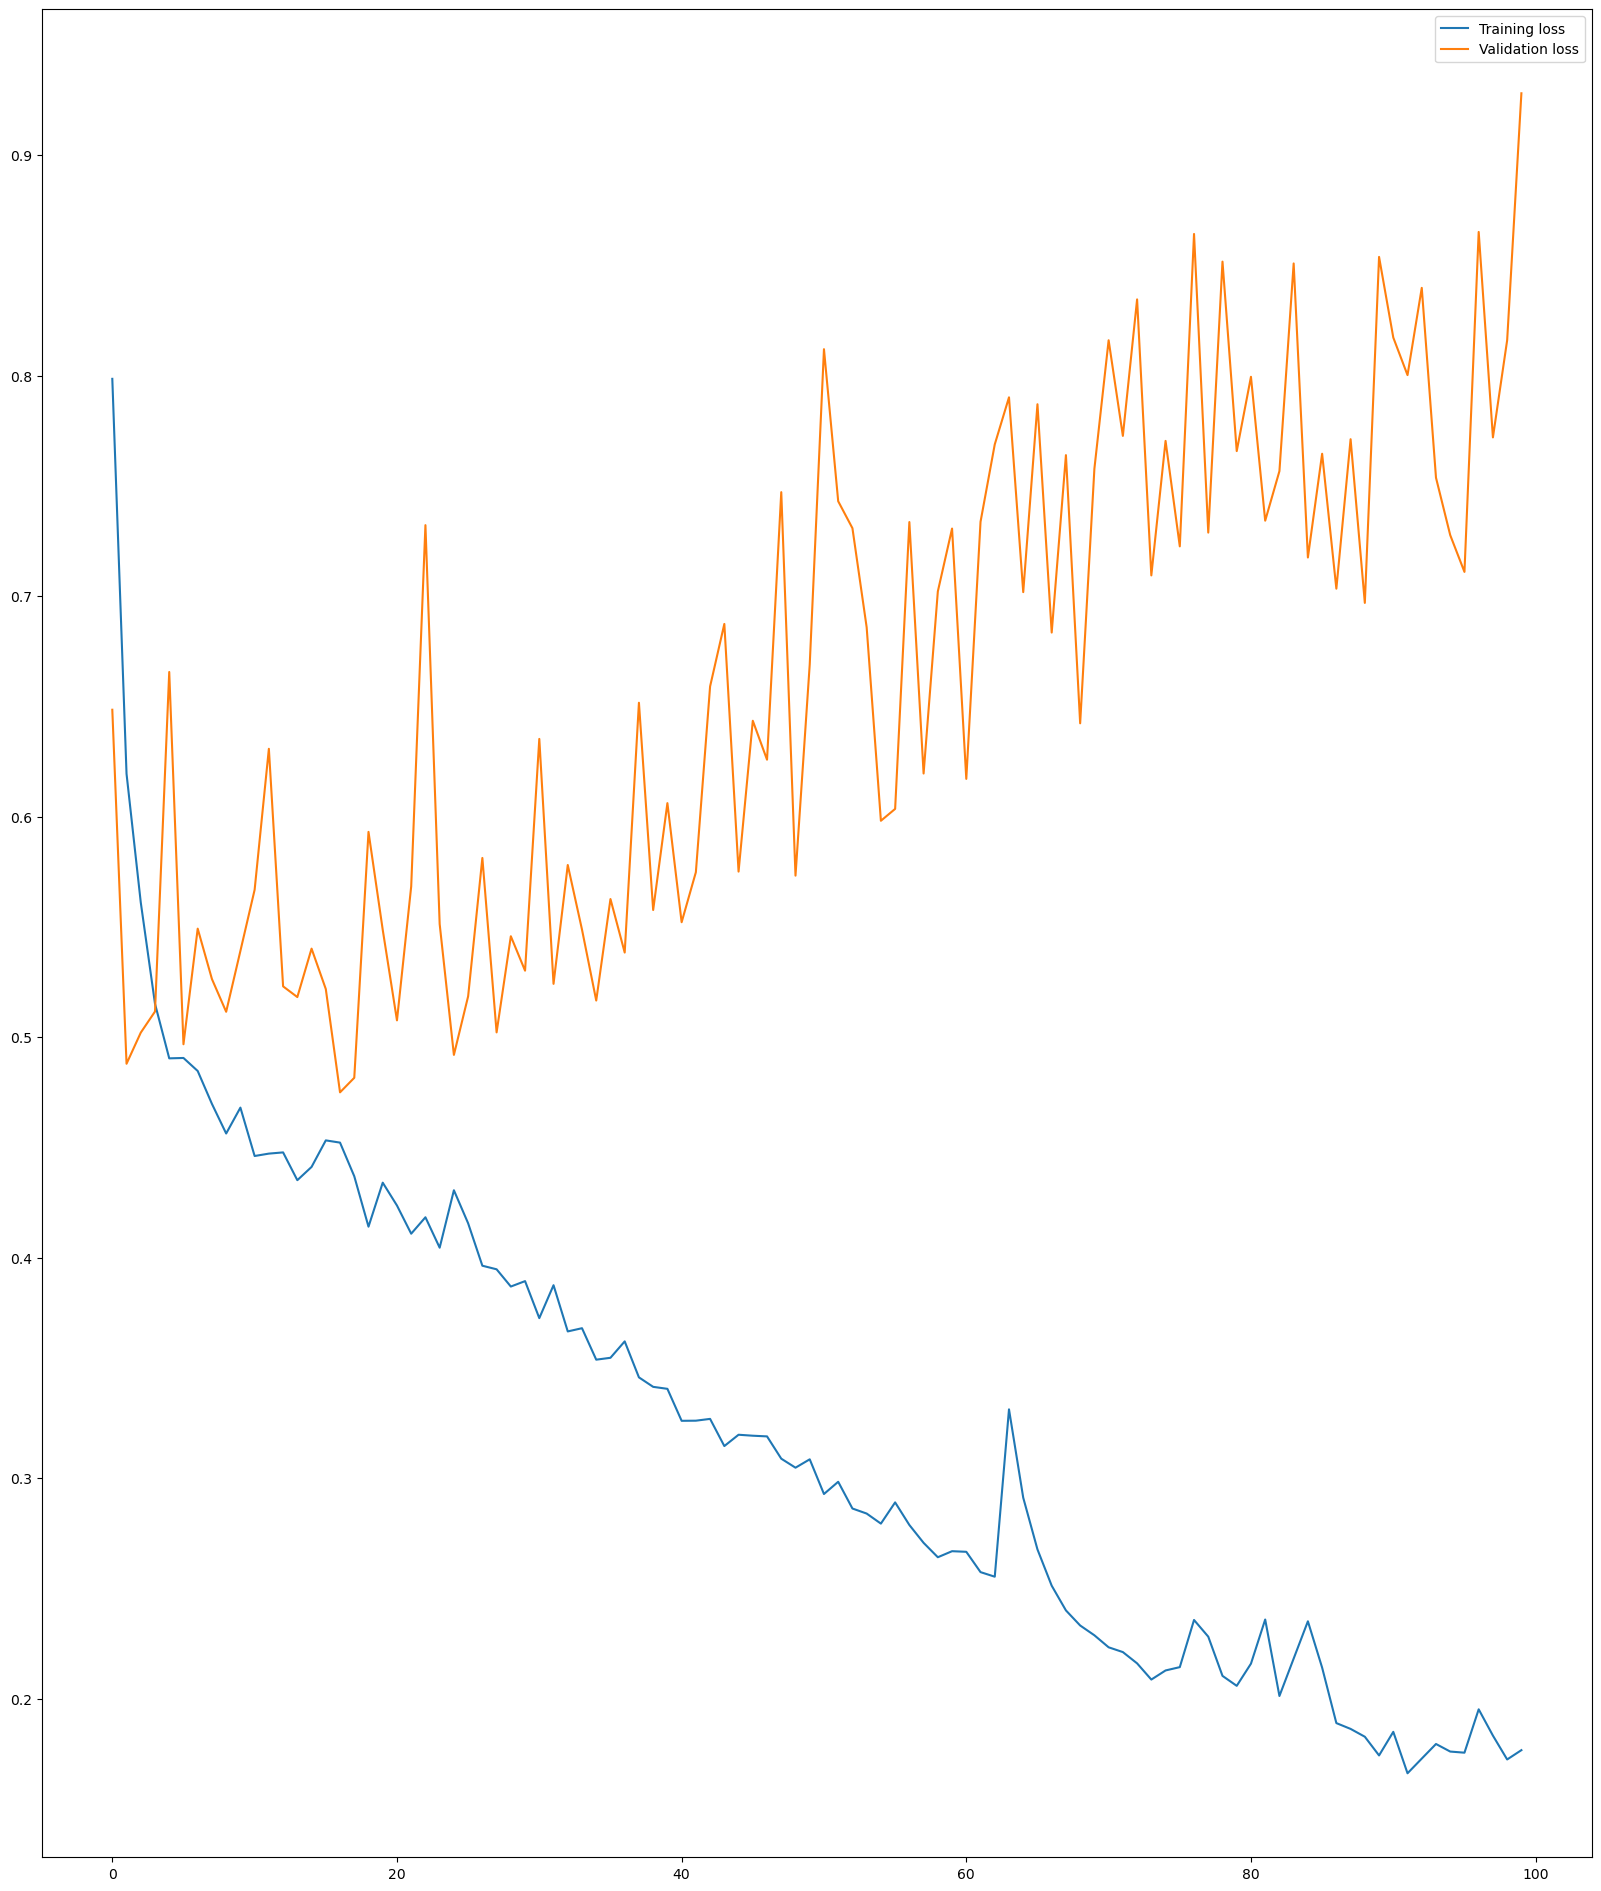

In [143]:
#Plot the Train and test loss during epoch
plt.plot(history1_appl.history['loss'], label='Training loss')
plt.plot(history1_appl.history['val_loss'], label='Validation loss')
plt.legend()

In [144]:
#Start with the last date in traingi dataset and predict future values
n_future1=499
forecast_period_dates1_appl=pd.date_range(list(train_dates1_appl)[-1],periods=n_future1, freq='1d').tolist()

forecast1_appl=model1_appl.predict(trainX1_appl[-n_future1:])

16/16 [==============================] - 1s 8ms/step


In [145]:
forecast_copies1_appl=np.repeat(forecast1_appl, df_for_training1_appl.shape[1], axis=-1)

y_pred_future1_appl=scaler1_appl.inverse_transform(forecast_copies1_appl)[:,0]

forecast_dates1_appl=[]

for time_i in forecast_period_dates1_appl:
  forecast_dates1_appl.append(time_i.date)
  

df_forecast1_appl=pd.DataFrame({'date':np.array(forecast_dates1_appl),'pct_change_Volume_appl':y_pred_future1_appl})

In [146]:
#define actual and predicted dataframe
actual1_appl=df_for_training1_appl[-499:]['pct_change_Volume_appl'].reset_index()
predicted1_appl=pd.DataFrame(y_pred_future1_appl)

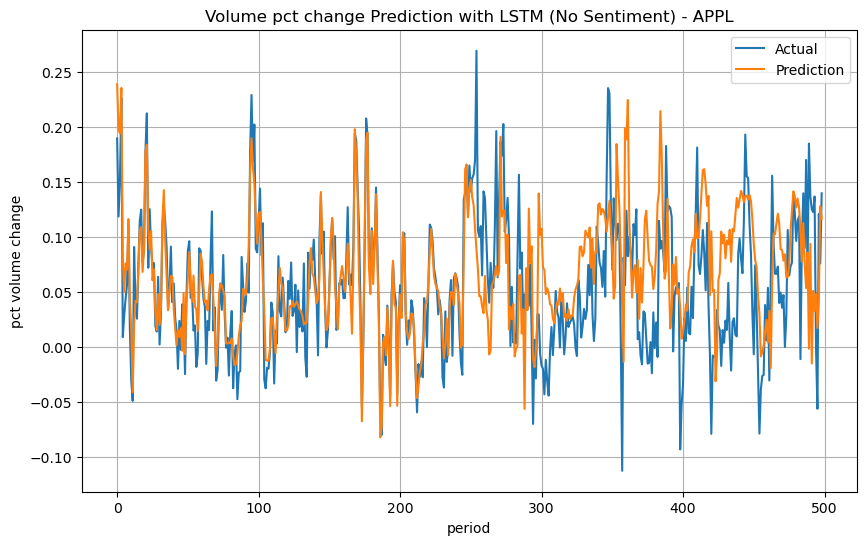

In [147]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(actual1_appl['pct_change_Volume_appl'], label='Actual')
plt.plot(predicted1_appl, label='Prediction')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with LSTM (No Sentiment) - APPL')
#plt.savefig(fig_dir+'LSTM_APPL_NoSent.png', transparent=False)
plt.legend()

In [148]:
# Calculate MAE and RMSE
mae_lstm1_appl=metrics.mean_absolute_error(actual1_appl['pct_change_Volume_appl'], predicted1_appl)
rmse_lstm1_appl=np.sqrt(metrics.mean_squared_error(actual1_appl['pct_change_Volume_appl'], predicted1_appl))
mad_lstm1_appl=mda(actual1_appl['pct_change_Volume_appl'],predicted1_appl[0])
print(f'MAE is :', mae_lstm1_appl)
print(f'RMSE is :', rmse_lstm1_appl)
print(f'MDAE is :', mad_lstm1_appl)

MAE is : 0.03647154250290669
RMSE is : 0.05009116070629205
MDAE is : 0.5582329317269076


#### 11.6.3.2 APPL LSTM2 (appl news included)

In [149]:
df_lstm2_appl=df_appl_hist_merged_roll_f.copy()
df_lstm2_appl.columns

Index(['compound', 'Volume_appl', 'Adj Close_appl', 'Adj Close_nasdaq',
       'Volume_nasdaq', 'Vix_index', 'pct_change_Volume_appl',
       'Price_variation_appl', 'OBV_appl', 'RSI_appl', 'EMV_appl', 'ATR_appl',
       'Id'],
      dtype='object')

In [150]:
df_lstm2_appl = df_lstm2_appl[['Id','pct_change_Volume_appl', 'Adj Close_appl', 'compound', 'Adj Close_nasdaq','Volume_nasdaq','Vix_index',
                               'Volume_appl','Price_variation_appl','OBV_appl','RSI_appl','EMV_appl','ATR_appl']]

In [151]:
#separate dates for future plots
train_dates2_appl=df_lstm2_appl['Id']
#variable for trainig
cols2_appl=list(df_lstm2_appl)[1:13]

In [152]:
#set content to float type so we don't loose any information during normalization.
df_for_training2_appl=df_lstm2_appl[cols2_appl].astype(float)

#Normalize the dataset
scaler2_appl=StandardScaler()
scaler2_appl=scaler2_appl.fit(df_for_training2_appl)
df_for_training_scaled2_appl=scaler2_appl.transform(df_for_training2_appl)

In [153]:
trainX2_appl=[]
trainY2_appl=[]

#Number of days we want to predict in the future
n_future2=1
#Number of past days we want to use to predict the future
n_past2=14

for i in range (n_past2, len(df_for_training_scaled2_appl)-n_future2+1):
  trainX2_appl.append(df_for_training_scaled2_appl[i-n_past2:i, 0:df_for_training2_appl.shape[1]])
  trainY2_appl.append(df_for_training_scaled2_appl[i+n_future2-1:i+n_future2,0])
  
trainX2_appl, trainY2_appl=np.array(trainX2_appl), np.array(trainY2_appl)

print('trainX2_appl shape =={}.'.format(trainX2_appl.shape))
print('trainY2_appl shape =={}.'.format(trainY2_appl.shape))

trainX2_appl shape ==(2479, 14, 12).
trainY2_appl shape ==(2479, 1).


In [154]:
#Define the LSTM architecture

model2_appl=Sequential()
model2_appl.add(LSTM(64, activation='relu',input_shape=(trainX2_appl.shape[1],trainX2_appl.shape[2]), return_sequences=True))
model2_appl.add(LSTM(32, activation='relu', return_sequences=False))
model2_appl.add(Dropout(0.2))
model2_appl.add(Dense(trainY2_appl.shape[1]))

model2_appl.compile(optimizer='adam',loss='mse')
model2_appl.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            19712     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [155]:
#fit the model
history2_appl=model2_appl.fit(trainX2_appl, trainY2_appl, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
140/140 [==============================] - 7s 20ms/step - loss: 0.8317 - val_loss: 0.6857
Epoch 2/100
140/140 [==============================] - 2s 16ms/step - loss: 0.6630 - val_loss: 0.5710
Epoch 3/100
140/140 [==============================] - 2s 15ms/step - loss: 0.5895 - val_loss: 0.5041
Epoch 4/100
140/140 [==============================] - 2s 15ms/step - loss: 0.5264 - val_loss: 0.4761
Epoch 5/100
140/140 [==============================] - 3s 24ms/step - loss: 0.5152 - val_loss: 0.4492
Epoch 6/100
140/140 [==============================] - 4s 30ms/step - loss: 0.4950 - val_loss: 0.4840
Epoch 7/100
140/140 [==============================] - 4s 27ms/step - loss: 0.4919 - val_loss: 0.4693
Epoch 8/100
140/140 [==============================] - 3s 23ms/step - loss: 0.4621 - val_loss: 0.5600
Epoch 9/100
140/140 [==============================] - 3s 20ms/step - loss: 0.4566 - val_loss: 0.4969
Epoch 10/100
140/140 [==============================] - 2s 16ms/step - loss: 0.442

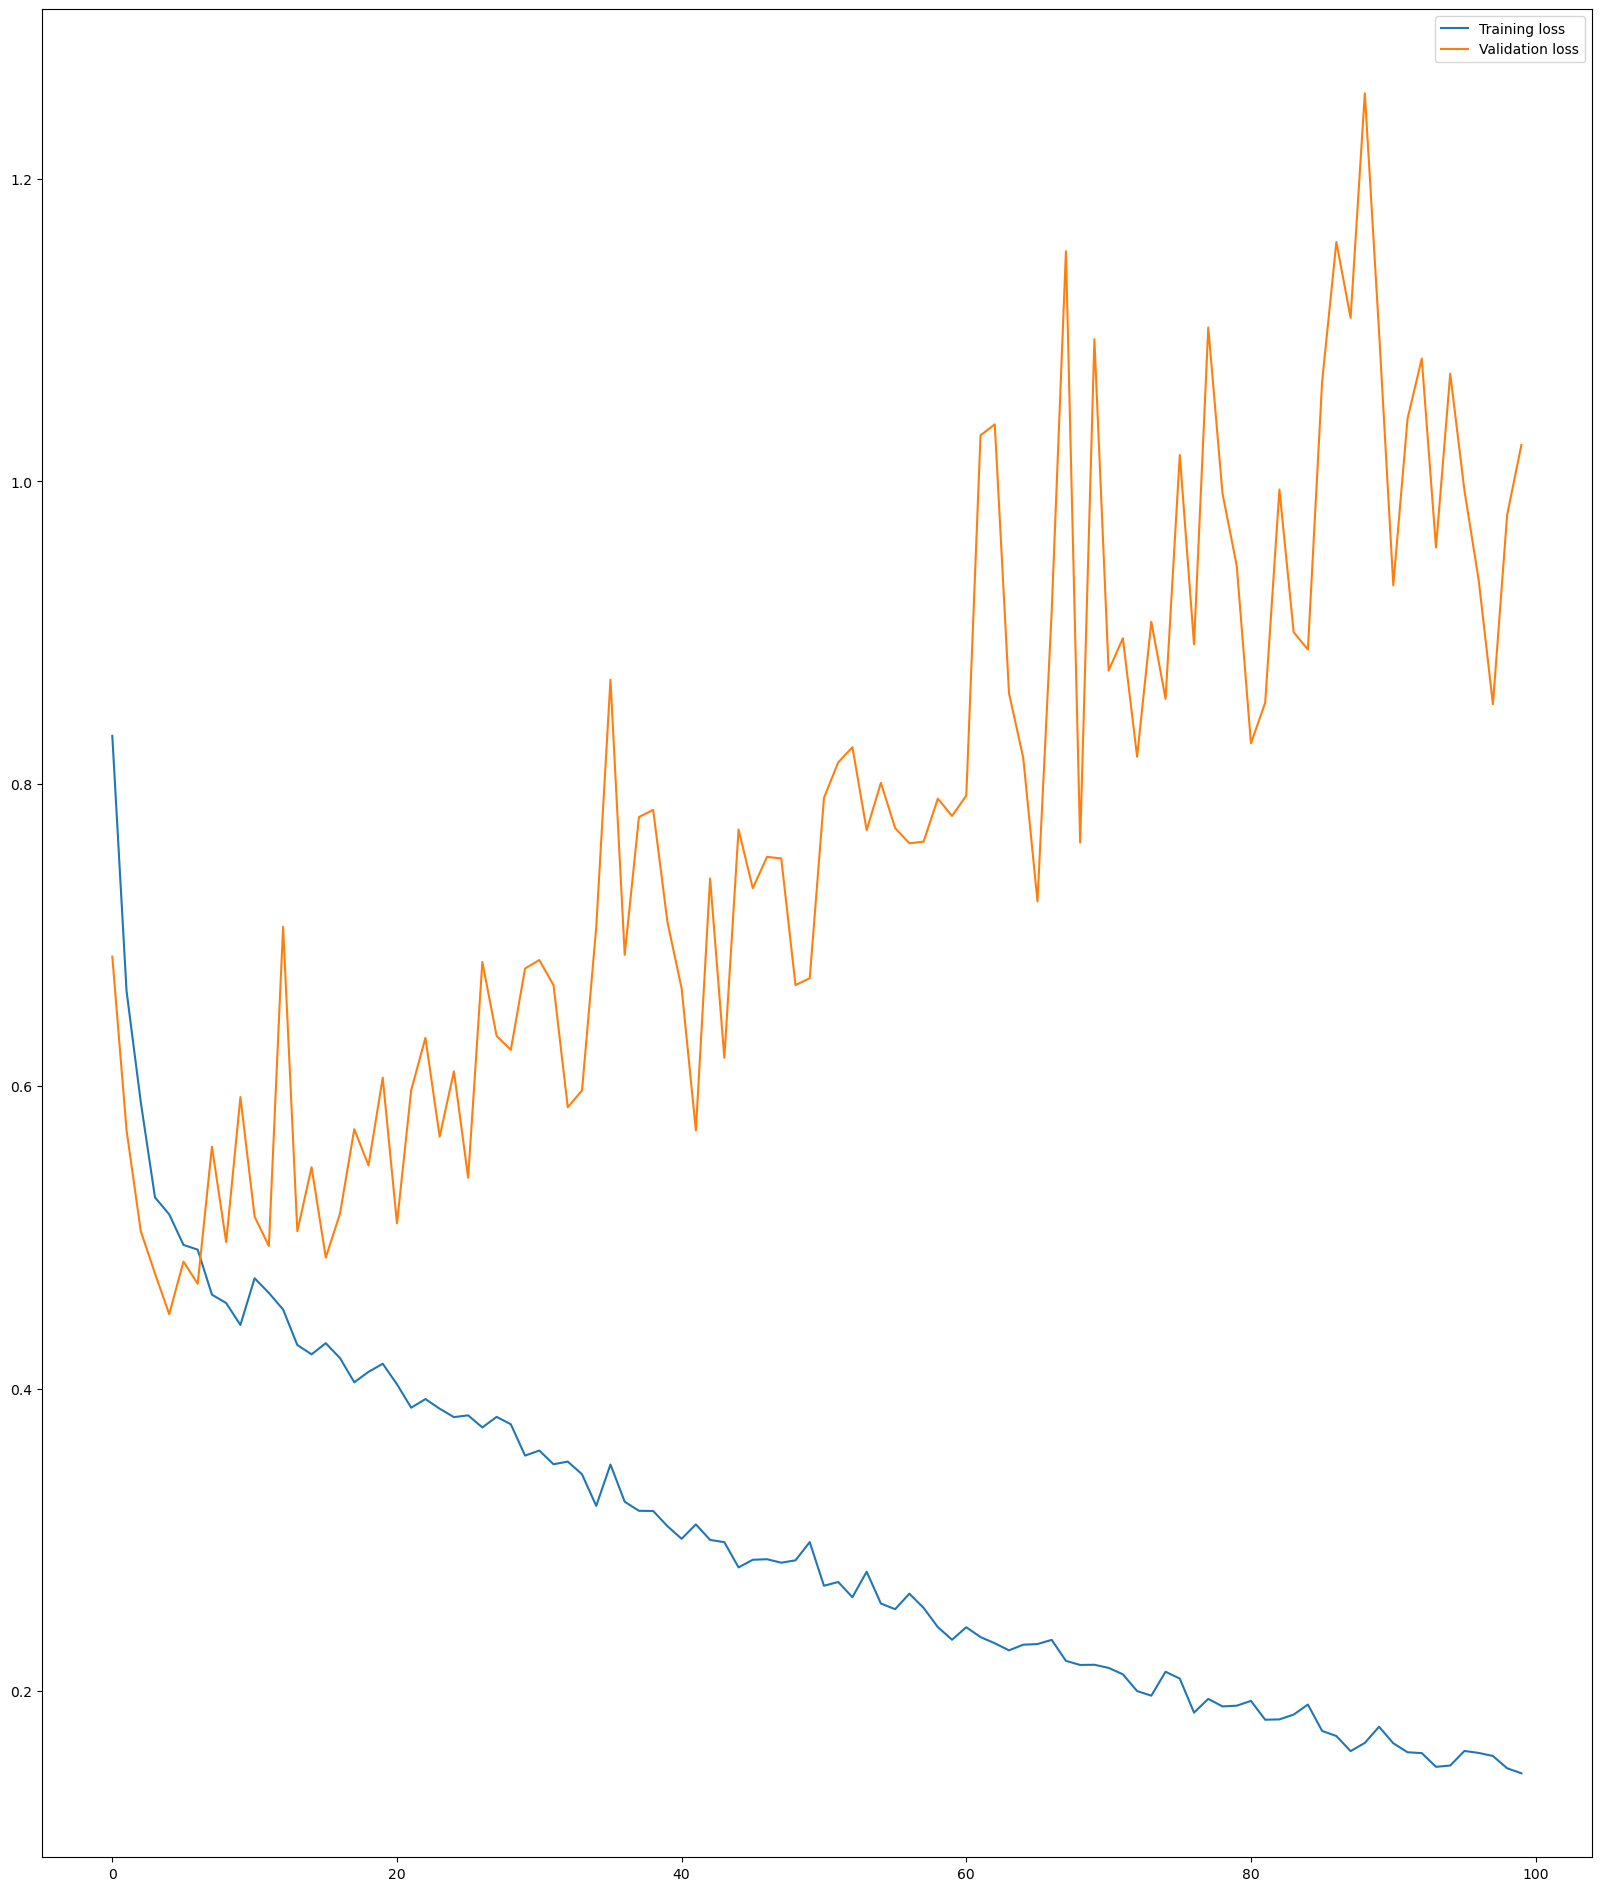

In [156]:
#Plot the Train and test loss during epoch
plt.plot(history2_appl.history['loss'], label='Training loss')
plt.plot(history2_appl.history['val_loss'], label='Validation loss')
plt.legend()

In [157]:
#Forecasting

#Start with the last date in traingi dataset and predict future values
n_future2=499
forecast_period_dates2_appl=pd.date_range(list(train_dates2_appl)[-1],periods=n_future2, freq='1d').tolist()

forecast2_appl=model2_appl.predict(trainX2_appl[-n_future2:])

16/16 [==============================] - 1s 7ms/step


In [158]:
forecast_copies2_appl=np.repeat(forecast2_appl, df_for_training2_appl.shape[1], axis=-1)

y_pred_future2_appl=scaler2_appl.inverse_transform(forecast_copies2_appl)[:,0]

forecast_dates2_appl=[]

for time_i in forecast_period_dates2_appl:
  forecast_dates2_appl.append(time_i.date)
  

df_forecast2_appl=pd.DataFrame({'id':np.array(forecast_dates2_appl),'Volume_appl':y_pred_future2_appl})

In [159]:
#define actual and predicted dataframe
actual2_appl=df_for_training2_appl[-499:]['pct_change_Volume_appl'].reset_index()
predicted2_appl=pd.DataFrame(y_pred_future2_appl)

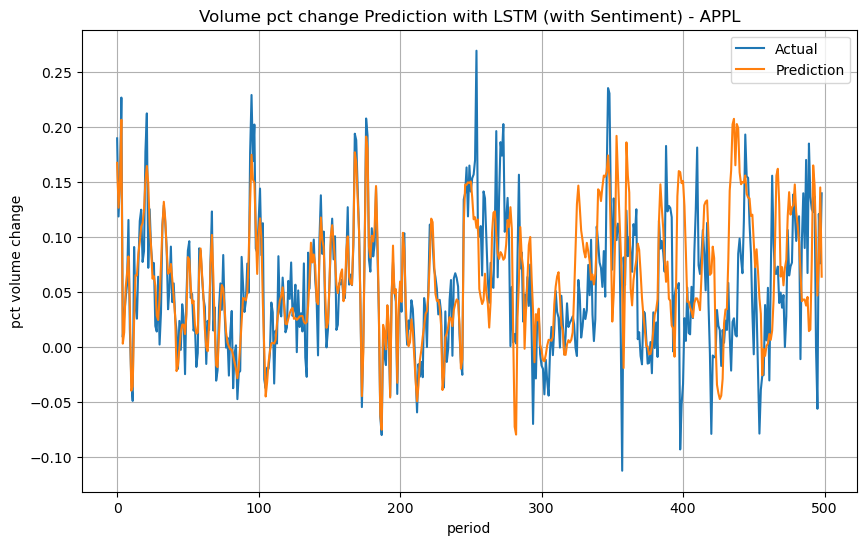

In [166]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(actual2_appl['pct_change_Volume_appl'], label='Actual')
plt.plot(predicted2_appl, label='Prediction')
plt.xlabel('period')
plt.ylabel('pct volume change')
plt.legend(loc='best')
plt.title('Volume pct change Prediction with LSTM (with Sentiment) - APPL')
#plt.savefig(fig_dir+'LSTM_APPL_Sent.png', transparent=False)
plt.legend()

In [163]:
# Calculate MAE and RMSE
mae_lstm2_appl=metrics.mean_absolute_error(actual2_appl['pct_change_Volume_appl'], predicted2_appl)
rmse_lstm2_appl=np.sqrt(metrics.mean_squared_error(actual2_appl['pct_change_Volume_appl'], predicted2_appl))
mad_lstm2_appl=mda(actual2_appl['pct_change_Volume_appl'],predicted2_appl[0])
print(f'MAE is :', mae_lstm2_appl)
print(f'RMSE is :', rmse_lstm2_appl)
print(f'MDAE is :', mad_lstm2_appl)

MAE is : 0.035720479814247544
RMSE is : 0.051814177385205495
MDAE is : 0.6224899598393574


## 8 RESULT SUMMARY

In the table below are reported the performance metrics computed for each of the predictive models.

In [164]:
from prettytable import PrettyTable 

In [165]:
# Specify the Column Names while initializing the Table 
myTable_TSLA = PrettyTable(["Predictive Model", "MAE", "RMSE","MDA"]) 
 
# Add rows 
myTable_TSLA.add_row(["Moving Average (benchmark)-TSLA", round(mae_ma,5), round(rmse_ma,5), round(mda_ma,5)]) 
myTable_TSLA.add_row(["Autoregressive model (benchmark)-TSLA", round(mae_ar,5), round(rmse_ar,5),round(mad_ar,5)]) 
myTable_TSLA.add_row(["Linear Regression model (no tsla news)-TSLA", round(mae_lr1,5), round(rmse_lr1,5),round(mad_lr1,5)]) 
myTable_TSLA.add_row(["Linear regression model (tsla news)-TSLA", round(mae_lr2,5), round(rmse_lr2,5),round(mad_lr2,5)]) 
myTable_TSLA.add_row(["Support Vector Regression model (no tsla news)-TSLA", round(mae_svr1,5), round(rmse_svr1,5),round(mad_svr1,5)]) 
myTable_TSLA.add_row(["Support Vector Regression model (tsla news)-TSLA", round(mae_svr2,5), round(rmse_svr2,5),round(mad_svr2,5)]) 
myTable_TSLA.add_row(["Random Forest Regression model (no tsla news)-TSLA", round(mae_rfr1,5), round(rmse_rfr1,5),round(mad_rfr1,5)])
myTable_TSLA.add_row(["Random Forest Regression model (tsla news)-TSLA", round(mae_rfr2,5), round(rmse_rfr2,5),round(mad_rfr2,5)]) 
myTable_TSLA.add_row(["LSTM model (no tsla news)-TSLA", round(mae_lstm1,5), round(rmse_lstm1,5),round(mad_lstm1,5)])
myTable_TSLA.add_row(["LSTM (tsla news)-TSLA", round(mae_lstm2,5), round(rmse_lstm2,5),round(mad_lstm2,5)]) 
 
print(myTable_TSLA)

NameError: name 'mae_ma' is not defined

In [ ]:
# Specify the Column Names while initializing the Table 
myTable_APPL = PrettyTable(["Predictive Model", "MAE", "RMSE","MDA"]) 
 
# Add rows 
myTable_APPL.add_row(["Moving Average (benchmark)-APPL", round(mae_ma_appl,5), round(rmse_ma_appl,5), round(mad_ma_appl,5)]) 
myTable_APPL.add_row(["Autoregressive model (benchmark)-APPL", round(mae_ar_appl,5), round(rmse_ar_appl,5),round(mad_ar_appl,5)]) 
myTable_APPL.add_row(["Linear Regression model (no tsla news-APPL)", round(mae_lr1_appl,5), round(rmse_lr1_appl,5),round(mad_lr1_appl,5)]) 
myTable_APPL.add_row(["Linear regression model (tsla news)-APPL", round(mae_lr2_appl,5), round(rmse_lr2_appl,5),round(mad_lr2_appl,5)]) 
myTable_APPL.add_row(["Support Vector Regression model (no tsla news)-APPL", round(mae_svr1_appl,5), round(rmse_svr1_appl,5),round(mad_svr1_appl,5)]) 
myTable_APPL.add_row(["Support Vector Regression model (tsla news)-APPL", round(mae_svr2_appl,5), round(rmse_svr2_appl,5),round(mad_svr2_appl,5)]) 
myTable_APPL.add_row(["Random Forest Regression model (no tsla news)-APPL", round(mae_rfr1_appl,5), round(rmse_rfr1_appl,5),round(mad_rfr1_appl,5)])
myTable_APPL.add_row(["Random Forest Regression model (tsla news)-APPL", round(mae_rfr2_appl,5), round(rmse_rfr2_appl,5),round(mad_rfr2_appl,5)]) 
myTable_APPL.add_row(["LSTM model (no tsla news)-APPL", round(mae_lstm1,5), round(rmse_lstm1,5),round(mad_lstm1_appl,5)])
myTable_APPL.add_row(["LSTM (tsla news)-APPL", round(mae_lstm2_appl,5), round(rmse_lstm2_appl,5),round(mad_lstm2_appl,5)]) 
 
print(myTable_APPL)

Looking at the results reported in the table, the main conclusion we can currently draw are:  
- For TSLA, the supervised ML predictive models considered perform approximatively like the benchmark models both. The only exception is the Linear regression model in TSLA which obtaiend the worst performance in term of MAE and RMSE. As regards the Deep learning model LSTM, it observable a relevant improvement in performance for both the stocks when compared to the remaning models (benchmark and supervised ML models).
- With respect to supervised ML models, SVR and RFR, they have all a comparable perfomance with no model overperforming the other models for both of the stocks. The only exceptions is the LR model for TSLA, which obtained overall the worst performance.
- Both in TSLA and APPL, a relevant improvement in performance is observed for the LSTM model when compared to the supervised machine learning models. 
- With respect to market sentiment information, factoring in the data related to news, it looks as if no improvement is achieved. Only in RFR model for TSLA a very small improvement is recorded for the prediction accuracy.